In [1]:
#import the necessary libraries
import findspark
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pandas as pd
import pyspark.sql 
import xlrd
from pyspark.sql.functions import *
from pyspark_dist_explore import hist 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from matplotlib.ticker import FormatStrFormatter
from pyspark.sql.types import DoubleType
import warnings
warnings.filterwarnings("ignore")
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark import SparkContext
import pyspark.sql 
from pandas import read_excel
from pyspark.sql import SQLContext
import pyspark.sql.functions as func
import math
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import seaborn as sns
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import *

In [2]:
#pip install pyspark_dist_explore 
#pip install seaborn
#pip install pandas
#pip install xlrd
#pip install plotly

# Start a SPARK SESSION- Connection with Python-PySpark 

In [3]:
#insert-connect the python 3 version with spark
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["SPARK_LOCAL_IP"]="127.0.0.1"

In [4]:
#start spark session
spark = SparkSession.builder.appName("spark").getOrCreate()

# Internet Banking

# Production data (PRO DATA)

## Read the total dataset which is about the whole 2 years (1/08/2017-31/07/2019)

In [5]:
# read the data απο τ0 Hue εχω επιλέξει μόνο εκεινες τις συναλλαγές που δεν έχουν καποιο error και έχω βγάλει τους χρηστες που δεν έχουν τίποτα σαν username)
#I had clients who were called NULL as users
prod_data=spark.read.csv("churn_results_3_merged.csv",header=True,sep="\t")
#rename the columns
ibanknew = prod_data.withColumnRenamed("client_username_MASKED","client_username")
ibanknew = ibanknew.withColumnRenamed("START_TRANS_END_DATA","start_trans_end_data")

ibanknew.printSchema()


root
 |-- client_username: string (nullable = true)
 |-- countt: string (nullable = true)
 |-- recency: string (nullable = true)
 |-- frequency: string (nullable = true)
 |-- max_dist: string (nullable = true)
 |-- average_trans_dur: string (nullable = true)
 |-- diff_maxd_mind_days: string (nullable = true)
 |-- start_trans_end_data: string (nullable = true)



In [6]:
#Show the data
ibanknew.show()

+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|     client_username|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|-3076708436585629202|    38|    290|        9|      61|33.77777777777778|                304|                 594|
| 7468171856771848261|     1|    575|        1|       0|                0|                  0|                 575|
| 5894351967915548207|     1|    705|        1|       0|                0|                  0|                 705|
|-1383360085895621481|  7128|      0|      213|       6|1.248826291079812|                266|                 266|
|-6214343568176160212|     1|    228|        1|       0|                0|                  0|                 228|
|-1932624376972617513|    22|     19|       16|     118|           41.37

In [415]:
#define a function that checks if the count results are the same

def count_results(dataframe):
    dataframe.agg( *[ count(c).alias(c) for c in dataframe.columns ] ).show()
    
    

In [8]:
#apply the above function
count_results(ibanknew)

+---------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+
|client_username| countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+---------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+
|        4645949|4645949|4645949|  4645949| 4645949|          4645949|            4645949|             4645949|
+---------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+



Since the count results are the same, we have not null values

# The number of different users  

In [9]:
#Count the number of rows (users)
ibanknew.count()

4645949

In [9]:
#number of diff. users in the clenaed dataset
n=ibanknew.select("client_username").distinct().count()
print("The number of  different users is : ",n)

The number of  different users is :  4645949


# The initial number of users is 4.645.949 

In [10]:
#see the type of columns
ibanknew.dtypes

[('client_username', 'string'),
 ('countt', 'string'),
 ('recency', 'string'),
 ('frequency', 'string'),
 ('max_dist', 'string'),
 ('average_trans_dur', 'string'),
 ('diff_maxd_mind_days', 'string'),
 ('start_trans_end_data', 'string')]

### convert the data to the same type (double) so as to get the describing meters for the data for clustering


In [7]:
ibanknew = ibanknew.withColumn("recency", ibanknew["recency"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("frequency", ibanknew["frequency"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("countt", ibanknew["countt"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("max_dist", ibanknew["max_dist"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("average_trans_dur", ibanknew["average_trans_dur"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("diff_maxd_mind_days", ibanknew["diff_maxd_mind_days"].cast(DoubleType()))
ibanknew = ibanknew.withColumn("start_trans_end_data", ibanknew["start_trans_end_data"].cast(DoubleType()))
#see the type of columns
ibanknew.dtypes

[('client_username', 'string'),
 ('countt', 'double'),
 ('recency', 'double'),
 ('frequency', 'double'),
 ('max_dist', 'double'),
 ('average_trans_dur', 'double'),
 ('diff_maxd_mind_days', 'double'),
 ('start_trans_end_data', 'double')]

In [8]:
#round the column average_trans_dur
ibanknew_filt = ibanknew.withColumn("average_trans_dur", func.round(ibanknew["average_trans_dur"], 2))

# TIME OF PERIOD OF DATA

### Start date    :     01/08/2017 

### End date     :    31/07/2019

# Data processing

#### Before starting the analysis we have to examine how many clients we are going to take into account because some of them did their "first" transaction close to the end date of data collection. As a result there is not enough time to study their behavior in such a short period so as to come to a conclusion for their pattern.
  
####  The main question is how far back in time we have to go so as to drop that specific clients?
An approach is to see the distribution of the parameter  'start_trans_end_data' for all clients and make assumptions.
 
   

### plot the variable " start_trans_end_data"

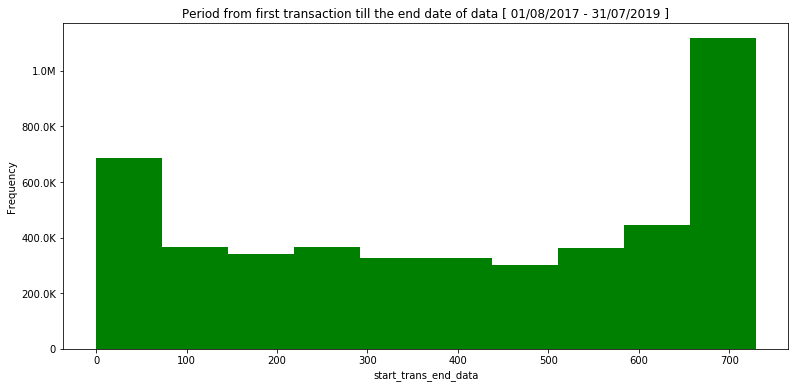

In [11]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Period from first transaction till the end date of data [ 01/08/2017 - 31/07/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('start_trans_end_data')
hist(ax,ibanknew_filt.select("start_trans_end_data"),color='green')

plt.show()

At a glance we could say that the right part (mainly) and a little the left part of the graph have a great deal of weight of clients.There are many clients (over 1.000.000 ) who did their first transaction approximately 650 days before the end date of collection data ( 31/07/2019 ) and over and a sufficient amount of clients (approximately 700.000 clients) who did their respective one close to the collection end date(approximately the last 2 months).  

### Statistics about the specific variable "start_trans_end_data"

In [18]:
#define a function that computes summary statisstics
def describe_stats(dataframe, columns, deciles=False):

    if deciles:
        percentiles = np.array(range(0, 110, 10)) #takes all the percentages from 0% -100%  with step 10 
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(dataframe.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)  #create a dataframe with the percentages
    percs['summary'] = [str(p) + '%' for p in percentiles]  #create a new column named "summary"  

    spark_describe = dataframe.describe().toPandas()  #convert the output of the command 'decribe' in panads data frame
   
    #for median
    df_pd=dataframe.toPandas()
    ms=df_pd.loc[:,"start_trans_end_data"].median()
    ma=df_pd.loc[:,"average_trans_dur"].median()
    
    mednew= [{'start_trans_end_data': ms,'average_trans_dur':ma}]
    median_df=pd.DataFrame(mednew, index =['median'])
    #concat the basic statistic measures from command describe and the percentiles
    new_df = pd.concat([spark_describe,median_df,percs],ignore_index=True)
    new_df = new_df.round(2)
    new_df=new_df[['summary'] + columns]
    new_df.loc[5,'summary'] = 'median'
    
    return new_df


In [19]:
#apply the above function for the feature 

summtvar=describe_stats(ibanknew_filt,['start_trans_end_data','average_trans_dur'],1) #not adding the value 1 we will get only the percentages 25% , 50% , 75%
summtvar  #for the total two years transactions

,summary,start_trans_end_data,average_trans_dur
0,count,4645949,4645949
1,mean,400.43961459757736,15.13173442928631
2,stddev,251.66151530084846,38.45998090599425
3,min,0.0,0.0
4,max,729.0,364.5
5,median,414,0
6,0%,0,0
7,10%,30,0
8,20%,119,0
9,30%,217,0


## 1st assumption

### Drop the clients that have made their first transaction 4 months before the end of collection data

In [9]:
stendfilt=ibanknew_filt.filter((ibanknew_filt.start_trans_end_data>121))
stendfilt.show()

+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|     client_username|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|-3076708436585629202|  38.0|  290.0|      9.0|    61.0|            33.78|              304.0|               594.0|
| 7468171856771848261|   1.0|  575.0|      1.0|     0.0|              0.0|                0.0|               575.0|
| 5894351967915548207|   1.0|  705.0|      1.0|     0.0|              0.0|                0.0|               705.0|
|-1383360085895621481|7128.0|    0.0|    213.0|     6.0|             1.25|              266.0|               266.0|
|-6214343568176160212|   1.0|  228.0|      1.0|     0.0|              0.0|                0.0|               228.0|
|-1932624376972617513|  22.0|   19.0|     16.0|   118.0|            41.3

### Number of clients that made first transaction over 4 months from the end date of collection data 

In [21]:
#get the number of users
print('The clients after filtering are :', stendfilt.count())

The clients after filtering are : 3690586


### Number of clients that have first transaction on the same day as the end date of collection data. 

In [22]:
same_day=ibanknew_filt.filter((ibanknew_filt.start_trans_end_data==0))
same_day.count()

20417

### Number of clients that have first transaction 4 months before the end date of collection data ( but not the same day)

In [23]:
four_months_b=ibanknew_filt.filter((ibanknew_filt.start_trans_end_data<=121)& (ibanknew_filt.start_trans_end_data!=0))
four_months_b.count()

934946

In [24]:
#assess the numbers (all-over4months)
4645949-3690586

955363

In [25]:
#assess the numbers(4 months before+same day)
20417+934946

955363

# NOW I AM WORKING WITH THE 'stendfilt' DATA

### Read the dataset which refers to the time period [ 01/08/2017 - 31/03/2019 ]  ( i.e until 4 months before the end of collection data)

# TIME PERIOD 

## Start date :  01/08/2017

## End date : 31/03/2019

In [10]:
#read the spark dataframe
data1=spark.read.csv("churn_results_5_merged.csv",header=False,sep = '\t')

In [11]:
#rename  the columns
data1 = data1.selectExpr("_c0 as client_username_s ",
                   "_c1 as countt",
                   "_c2 as recency",
                   "_c3 as frequency",
                   "_c4 as max_dist",
                   "_c5 as average_trans_dur",
                   "_c6 as diff_maxd_mind_days",
                   "_c7 as start_trans_end_data")


In [12]:
#round a column
data1=data1.withColumn("average_trans_dur", func.round(data1["average_trans_dur"], 2))


In [13]:
data1.show()

+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|   client_username_s|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|-3076708436585629202|    38|    168|        9|      61|            33.78|                304|                 472|
| 7468171856771848261|     1|    453|        1|       0|              0.0|                  0|                 453|
| 5894351967915548207|     1|    583|        1|       0|              0.0|                  0|                 583|
|-1383360085895621481|  2687|      1|      106|       6|             1.35|                143|                 144|
|-6214343568176160212|     1|    106|        1|       0|              0.0|                  0|                 106|
|-5557866019035609934|     3|     82|        1|       0|              0.

### Number of users in the data1 ( in the study period for clustering).

In [30]:
#Get the number of rows
data1.count()  # the same as before with the total 

3690586

## MY USERS ARE 3.690.586

### Number of clients who made first transaction in my study period (over 4 months from the end date of colection data) and have frequency = 1

In [31]:
freq1=data1.filter((data1.frequency==1))
freq1.count()

1831783

There are 1.831.783 clients that have entered to the NBG system only once in the study period.

# 2nd assumption

## I will work with the clients that have entered to the NBG system at least twice because in order to do segmentation I should have at least two transactions so as to have a behavioral pattern. 
#### (frequency >= 2)

In [14]:
freq_equp2=data1.filter((data1.frequency>=2))

## Number of clients that made first transaction over 4 months from the end date of colection data and have frequency >= 2

In [33]:
freq_equp2.count()

1858803

# NUMBER OF USERS = 1.858.803

 ### Convert to pandas the pyspark dataframe

In [15]:
pd__freq_equp2=freq_equp2.toPandas()
pd__freq_equp2

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,-3076708436585629202,38,168,9,61,33.78,304,472
1,-1383360085895621481,2687,1,106,6,1.35,143,144
2,-4373917140025030743,349,7,24,71,11.17,268,275
3,-1932624376972617513,16,17,14,118,38.71,542,559
4,8138114728915753073,2250,13,113,27,5.23,591,604
...,...,...,...,...,...,...,...,...
1858798,9193353595840245243,294,30,13,258,39.38,512,542
1858799,3824195531289036223,352,8,20,288,29.85,597,605
1858800,-6578479747972244936,336,47,12,388,43.50,522,569
1858801,5232325352528294823,687,2,21,33,13.10,275,277


In [16]:
pd__freq_equp2.dtypes

client_username_s        object
countt                   object
recency                  object
frequency                object
max_dist                 object
average_trans_dur       float64
diff_maxd_mind_days      object
start_trans_end_data     object
dtype: object

In [17]:
#convert  to numeric type the columns 
pd__freq_equp2[["countt", "recency","frequency","max_dist",
                "average_trans_dur","diff_maxd_mind_days","start_trans_end_data"]] = pd__freq_equp2[["countt", "recency","frequency","max_dist",
                "average_trans_dur","diff_maxd_mind_days","start_trans_end_data"]].apply(pd.to_numeric)
pd__freq_equp2.dtypes

client_username_s        object
countt                    int64
recency                   int64
frequency                 int64
max_dist                  int64
average_trans_dur       float64
diff_maxd_mind_days       int64
start_trans_end_data      int64
dtype: object

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! OUTLIERS  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

## Scatter_matrix for numeric columns of dataframe cluster data

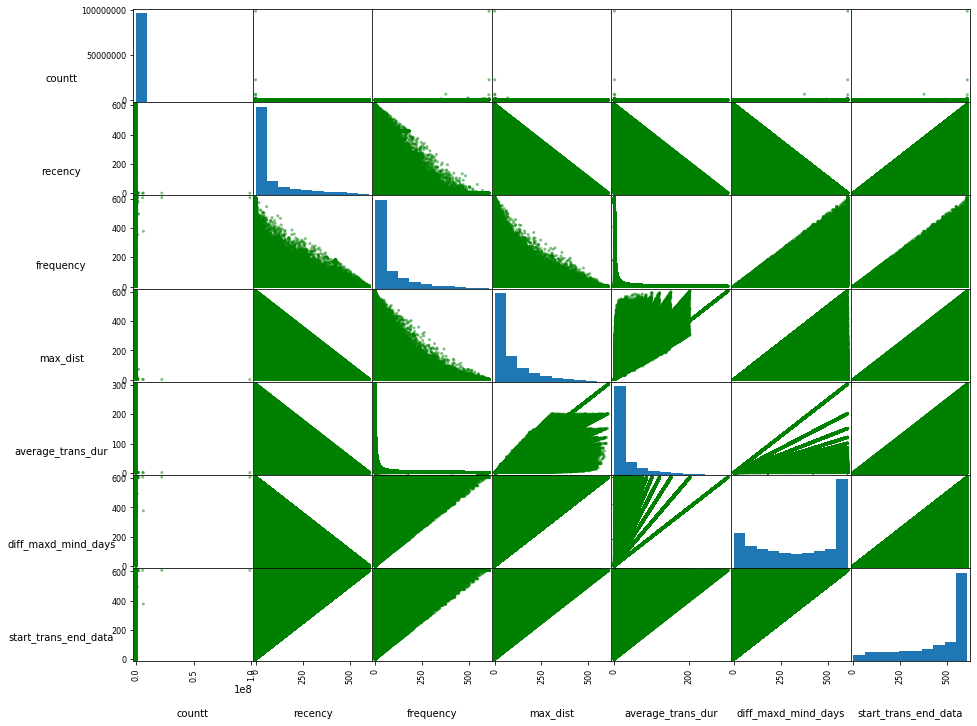

In [14]:
plot1=scatter_matrix(pd__freq_equp2.loc[:,'countt':],figsize=(15,12),c='green') #figsize(width,height)
#change the appearance of ticklabels
[s.yaxis.label.set_rotation(360) for s in plot1.reshape(-1)]
#May need to offset label when rotating to prevent overlap of figure
[s.get_xaxis().set_label_coords(0.5,-0.5) for s in plot1.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.6,0.2) for s in plot1.reshape(-1)]
plt.show()

In [38]:
# Export for the window anaconda jupyter for checking outliers
exportcsv =pd__freq_equp2.to_csv(r'C:\Users\user\Desktop\NBG\outlierscheck4fromubuntu.csv',index = None, header=True)

# Read the filtered df without outliers

In [18]:
#read the spark dataframe
data_no_outliers=spark.read.csv("dfclient_feat_out4.csv",header=True,sep = ',')

In [19]:
data_no_outliers.show()

+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|   client_username_s|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+--------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|-3076708436585629202|    38|    168|        9|      61|            33.78|                304|                 472|
|-1383360085895621481|  2687|      1|      106|       6|             1.35|                143|                 144|
|-4373917140025030743|   349|      7|       24|      71|            11.17|                268|                 275|
|-1932624376972617513|    16|     17|       14|     118|            38.71|                542|                 559|
| 8138114728915753073|  2250|     13|      113|      27|             5.23|                591|                 604|
| 3238105438798080237|  1095|      0|       94|      31|              6.

# The number of different users

In [20]:
#count the users
data_no_outliers.count()

1218752

# FINALLY THE NUMBER OF USERS IS 1.218.752 

In [42]:
1858803-1218752

640051

### There were 640.051 outliers

### Rename the spark df

In [21]:
freq_equp2=data_no_outliers

## Take the client usernames (of the subset)

In [22]:
users=freq_equp2.select([c for c in freq_equp2.columns if c in ['client_username_s']])

### Take the column 'start_trans_end_data' for the filtered users 

In [22]:
#I want the columns of data1 about the features until 4 months before the end
user_total = stendfilt.join(users, users.client_username_s == stendfilt.client_username)
#get the columns I want
user_total=user_total.select([c for c in user_total.columns if c in ['client_username','start_trans_end_data']])
user_total.count()

1218752

In [23]:
#select and convert to pandas the column start_trans_end_data
df_start_trans_end_data=user_total.select("start_trans_end_data").toPandas()

In [47]:
#define a function that computes summary statisstics
def describe_stats(dataframe, columns, deciles=False):

    if deciles:
        percentiles = np.array(range(0, 110, 10)) #takes all the percentages from 0% -100%  with step 10 
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(dataframe.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)  #create a dataframe with the percentages
    percs['summary'] = [str(p) + '%' for p in percentiles]  #create a new column named "summary"  

    spark_describe = dataframe.describe().toPandas()  #convert the output of the command 'decribe' in panads data frame
   
    #for median
    df_pd=dataframe.toPandas()
    ms=df_pd.loc[:,"start_trans_end_data"].median()
    
    
    
    mednew= [{'start_trans_end_data': ms}]
    median_df=pd.DataFrame(mednew, index =['median'])
    #concat the basic statistic measures from command describe and the percentiles
    new_df = pd.concat([spark_describe,median_df,percs],ignore_index=True)
    new_df = new_df.round(2)
    new_df=new_df[['summary'] + columns]
    new_df.loc[5,'summary'] = 'median'
    
    return new_df

In [48]:
#apply the function for statistics for the feature start_trans_end_data

summtvarnew=describe_stats(user_total,['start_trans_end_data'],1) #αν δεν βαλω το 1 θα μου βγαλει μονο τα ποσοστα 25% , 50% , 75%
summtvarnew

,summary,start_trans_end_data
0,count,1218752
1,mean,531.3573524392165
2,stddev,198.00158992742902
3,min,123.0
4,max,729.0
5,median,601
6,0%,123
7,10%,230
8,20%,306
9,30%,391


## Histogram  for the total dataframe about start_trans_end_data

<Figure size 432x288 with 0 Axes>

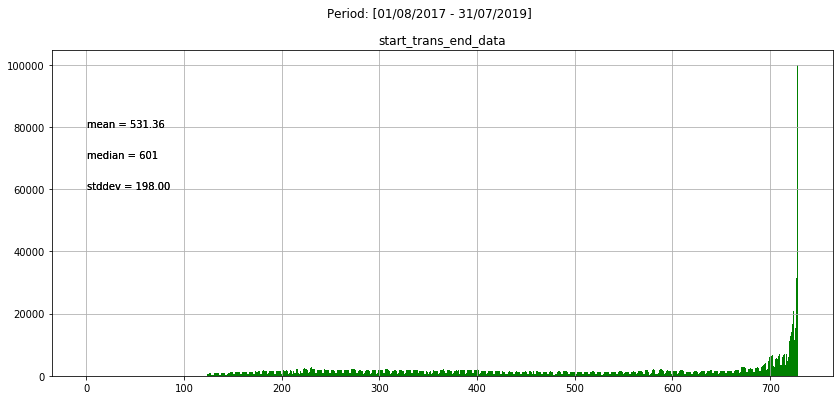

In [24]:
plt.figure()
bin_values = np.arange(start=1, stop=729, step=1)
df_start_trans_end_data.hist(bins=bin_values,color='green', figsize=[14,6])
plt.text(1,80000 ,r'mean = 531.36')
plt.text(1,80000 ,r'mean = 531.36')
plt.text(1,70000 ,r'median = 601')
plt.text(1,70000 ,r'median = 601')
plt.text(1,60000 ,r'stddev = 198.00')
plt.text(1,60000 ,r'stddev = 198.00')
plt.suptitle("Period: [01/08/2017 - 31/07/2019]")

plt.show()

### convert the data to the same type (double) so as to get the describing meters for the data for clustering


In [23]:
freq_equp2 = freq_equp2.withColumn("recency", freq_equp2["recency"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("frequency", freq_equp2["frequency"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("countt", freq_equp2["countt"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("max_dist", freq_equp2["max_dist"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("average_trans_dur", freq_equp2["average_trans_dur"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("diff_maxd_mind_days", freq_equp2["diff_maxd_mind_days"].cast(DoubleType()))
freq_equp2 = freq_equp2.withColumn("start_trans_end_data", freq_equp2["start_trans_end_data"].cast(DoubleType()))

freq_equp2.dtypes

[('client_username_s', 'string'),
 ('countt', 'double'),
 ('recency', 'double'),
 ('frequency', 'double'),
 ('max_dist', 'double'),
 ('average_trans_dur', 'double'),
 ('diff_maxd_mind_days', 'double'),
 ('start_trans_end_data', 'double')]

In [26]:
#select and convert to pandas the column start_trans_end_data
df_start_trans_end_data_s=freq_equp2.select("start_trans_end_data").toPandas()

### Statistics for all users in the study period (four months before the 31/07/2019) 

In [52]:
#apply the function for statistics for the feature start_trans_end_data for the subset

summ_table1=describe_stats(freq_equp2,['start_trans_end_data'],1) #αν δεν βαλω το 1 θα μου βγαλει μονο τα ποσοστα 25% , 50% , 75%
summ_table1

,summary,start_trans_end_data
0,count,1218752
1,mean,409.3573524392165
2,stddev,198.00158992742908
3,min,1.0
4,max,607.0
5,median,479
6,0%,1
7,10%,108
8,20%,184
9,30%,269


# Histograms

<Figure size 432x288 with 0 Axes>

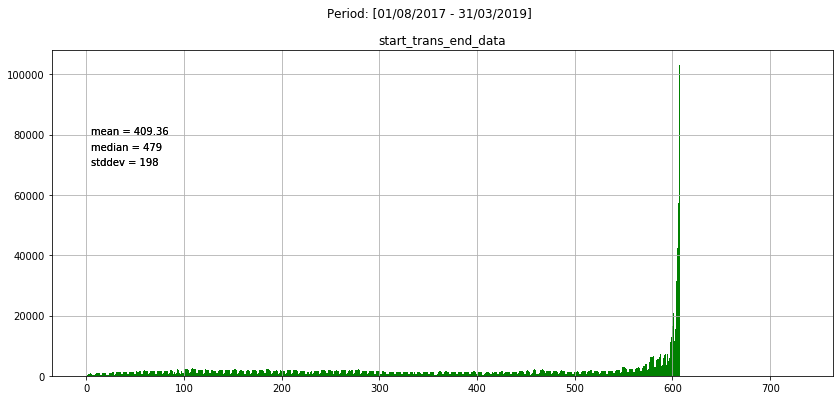

In [27]:
plt.figure()
bin_values = np.arange(start=1, stop=729, step=1)
df_start_trans_end_data_s.hist(bins=bin_values,color='green', figsize=[14,6])
plt.text(5,80000 ,r'mean = 409.36')
plt.text(5,80000 ,r'mean = 409.36')
plt.text(5,75000 ,r'median = 479')
plt.text(5,75000 ,r'median = 479')
plt.text(5,70000 ,r'stddev = 198')
plt.text(5,70000 ,r'stddev = 198')
plt.suptitle("Period: [01/08/2017 - 31/03/2019]")


plt.show()

In [54]:
#See the values with adding substracting 1 stdev . 
print('The range of values for the variable start_trans_end_data is :\n \n[mean - 1 stdev , mean + 1 stdev] = [',np.round(409.36-198,2),',',np.round(409.36+198,2),']')

The range of values for the variable start_trans_end_data is :
 
[mean - 1 stdev , mean + 1 stdev] = [ 211.36 , 607.36 ]


# Statistics  for all users in the study period
#### (four months before the 31/07/2019) 

I define a function so as to get the statistics. Because of the large size of dataframe it was neccesary to divide the function to parts because the kerner was shutdown every tiem I was trying to run this with all columns.  

In [55]:
#define a function that computes summary statisstics
def describe_stats(dataframe, columns, deciles=False):

    if deciles:
        percentiles = np.array(range(0, 110, 10)) #takes all the percentages from 0% -100%  with step 10 
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(dataframe.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)  #create a dataframe with the percentages
    percs['summary'] = [str(p) + '%' for p in percentiles]  #create a new column named "summary"  

    spark_describe = dataframe.describe().toPandas()  #convert the output of the command 'decribe' in panads data frame
   
    #for median
    df_pd=dataframe.toPandas()
    mr=df_pd.loc[:,"recency"].median()
    mf=df_pd.loc[:,"frequency"].median()
    mmd=df_pd.loc[:,"max_dist"].median()
    
    mednew= [{'recency': mr, 'frequency': mf,'max_dist':mmd}] #'max_dist':mmd,'average_trans_dur':ma,'diff_maxd_mind_days':md}]
    median_df=pd.DataFrame(mednew, index =['median'])
    #concat the basic statistic measures from command describe and the percentiles
    new_df = pd.concat([spark_describe,median_df,percs],ignore_index=True)
    new_df = new_df.round(2)
    new_df=new_df[['summary'] + columns]
    new_df.loc[5,'summary'] = 'median'
    
    return new_df

In [56]:
# see the statistic table for  features
kolones=['recency','frequency','max_dist']
sumallperiod1=describe_stats(freq_equp2,kolones,1) #αν δεν βαλω το 1 θα μου βγαλει μονο τα ποσοστα 25% , 50% , 75%
#sumallperiod1


In [57]:
#define a function that computes summary statisstics
def describe_stats(dataframe, columns, deciles=False):

    if deciles:
        percentiles = np.array(range(0, 110, 10)) #takes all the percentages from 0% -100%  with step 10 
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(dataframe.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)  #create a dataframe with the percentages
    percs['summary'] = [str(p) + '%' for p in percentiles]  #create a new column named "summary"  

    spark_describe = dataframe.describe().toPandas()  #convert the output of the command 'decribe' in panads data frame
   
    #for median
    df_pd=dataframe.toPandas()
    mc=df_pd.loc[:,"countt"].median()
    ma=df_pd.loc[:,"average_trans_dur"].median()
    md=df_pd.loc[:,"diff_maxd_mind_days"].median()
    
    
    mednew= [{'countt':mc,'average_trans_dur':ma,'diff_maxd_mind_days':md}]
    median_df=pd.DataFrame(mednew, index =['median'])
    #concat the basic statistic measures from command describe and the percentiles
    new_df = pd.concat([spark_describe,median_df,percs],ignore_index=True)
    new_df = new_df.round(2)
    new_df=new_df[['summary'] + columns]
    new_df.loc[5,'summary'] = 'median'
    
    return new_df


In [58]:
# see the statistic table for  features
kolones2=['countt','average_trans_dur','diff_maxd_mind_days'] #'max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
sumallperiod2=describe_stats(freq_equp2,kolones2,1) #αν δεν βαλω το 1 θα μου βγαλει μονο τα ποσοστα 25% , 50% , 75%
#sumallperiod2

In [59]:
#join the pandas dfs
stat=sumallperiod1.join(sumallperiod2.set_index('summary'), on='summary')
stat=stat.join(summ_table1.set_index('summary'), on='summary')
stat

,summary,recency,frequency,max_dist,countt,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,count,1218752,1218752,1218752,1218752,1218752,1218752,1218752
1,mean,45.35612659507431,57.642531048154176,62.37515671769154,1033.2996302775298,14.949344862612174,364.0012258441422,409.3573524392165
2,stddev,69.34197509890332,60.17105558792078,55.742535965714936,1143.0766388862291,16.09149776215181,217.49757024892324,198.00158992742908
3,min,0.0,2.0,1.0,2.0,0.5,1.0,1.0
4,max,287.0,251.0,266.0,4693.0,72.86,607.0,607.0
5,median,10,35,41,598,8.1,420,479
6,0%,0,2,1,2,0.5,1,1
7,10%,1,2,12,6,2.64,43,108
8,20%,2,6,19,43,3.59,108,184
9,30%,3,12,25,163,4.68,189,269


##### Μια παρατήρηση

#### Αν πάρω από την αρχή freq >= 2 κ μετά πάρω τους 4 μήνες πίσω κάνοντας join με το subset είναι λάθος γιατι βλέπω ότι υπολοίπονται χρήστες  που ειναι λογικό και βρίσκοντας έναν χρήστη κατάλαβα γτ υπολοίπονται. 

In [60]:
dokimh=stendfilt.filter(stendfilt.frequency<=2)
spec1=stendfilt.filter(stendfilt.client_username == '7563409766502808263')
spec1.show()
#εχει freq=2 στο αρχικό αλλά τη 2η συναλλαγή την έκανε στο τελευταιο δίμηνο 

+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|    client_username|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|7563409766502808263|   6.0|   16.0|      2.0|   116.0|             58.0|              116.0|               132.0|
+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+



In [61]:
spec2=data1.filter(data1.client_username_s == '7563409766502808263')
spec2.show()
# εχει freq=1 στο μικρό γτ μεχρι το όριο που εχω πα΄ρει εχει 1 συναλλαγή

+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|  client_username_s|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|7563409766502808263|     3|     10|        1|       0|              0.0|                  0|                  10|
+-------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+



###### τέλος η παρατήρηση

## Plots

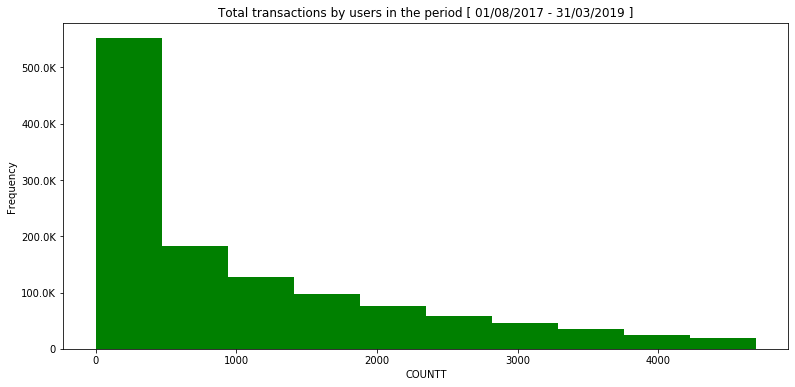

In [28]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Total transactions by users in the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('COUNTT')
hist(ax,freq_equp2.select("countt"),color='green')
plt.show()

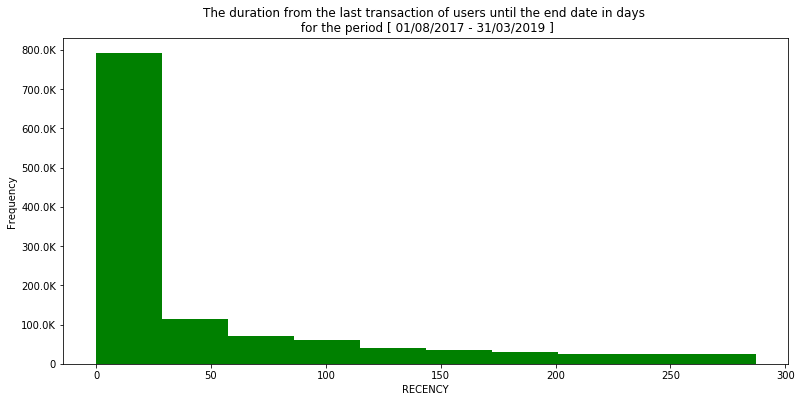

In [29]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('RECENCY')
hist(ax,freq_equp2.select("recency"),color='green')
plt.show()

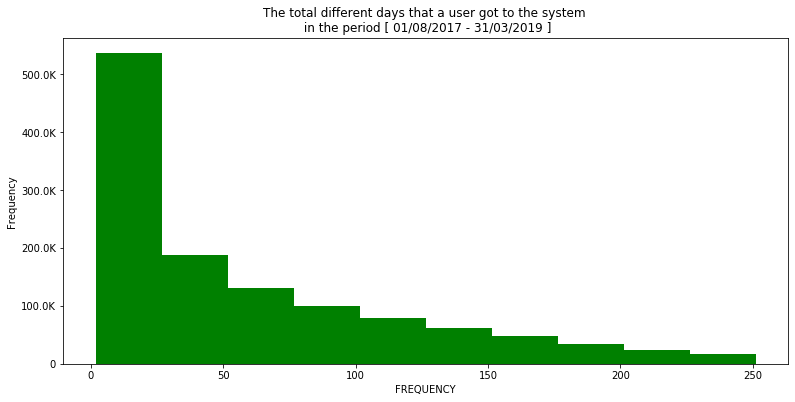

In [30]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The total different days that a user got to the system \n in the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('FREQUENCY')
hist(ax,freq_equp2.select("frequency"),color='green')
plt.show()

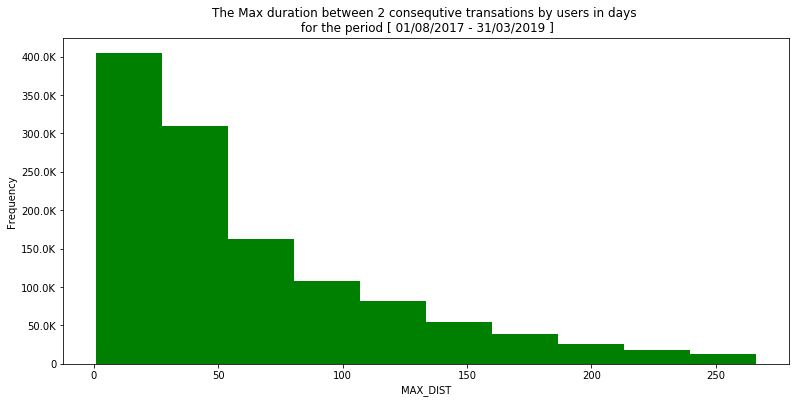

In [31]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The Max duration between 2 consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('MAX_DIST')
hist(ax,freq_equp2.select("max_dist"),color='green')
plt.show()

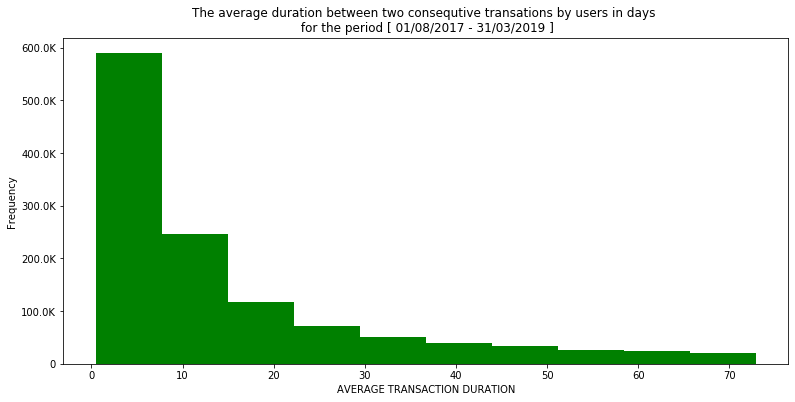

In [32]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('AVERAGE TRANSACTION DURATION')
hist(ax,freq_equp2.select("average_trans_dur"),color='green')
plt.show()

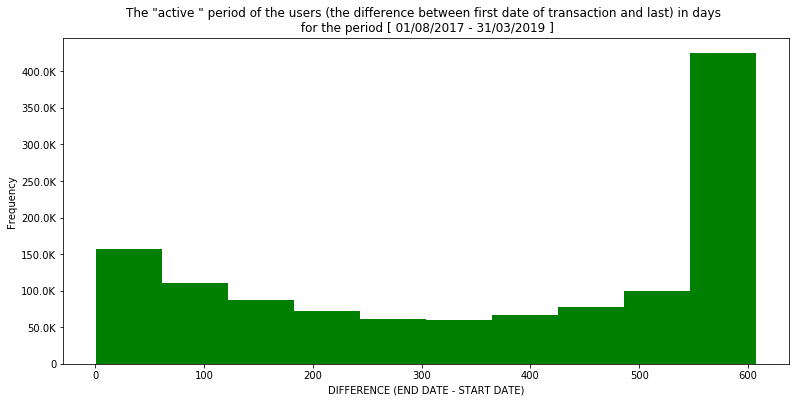

In [33]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The "active " period of the users (the difference between first date of transaction and last) in days \n for the period [ 01/08/2017 - 31/03/2019 ]')
ax.set_ylabel('Frequency')
ax.set_xlabel('DIFFERENCE (END DATE - START DATE)')
hist(ax,freq_equp2.select("diff_maxd_mind_days"),color='green')
plt.show()

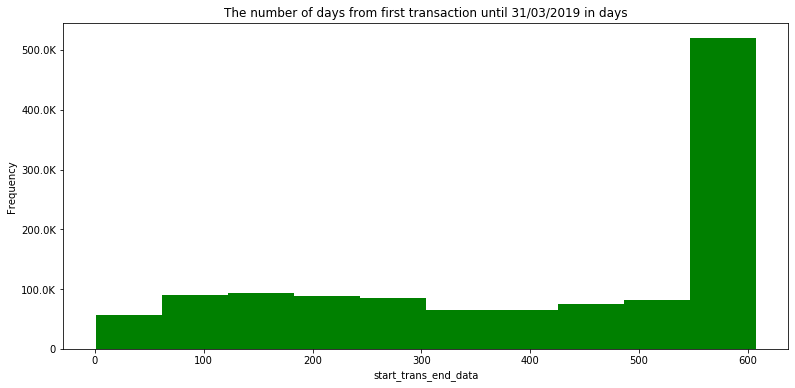

In [34]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The number of days from first transaction until 31/03/2019 in days')
ax.set_ylabel('Frequency')
ax.set_xlabel('start_trans_end_data')
hist(ax,freq_equp2.select("start_trans_end_data"),color='green')
plt.show()

Due to the fact that we have case in which one or a few points are much larger than the bulk of the data  I take the log of the columns and especially the log(a+1) because there are values which are equal to zero (0) and the log(0) is not specified, 

## ADD THE  LOG ( COLUMNS+1 )

In [24]:
#add a new column log(count)
freq_equp2_log=freq_equp2.withColumn('ln(countt+1)', log(freq_equp2.countt+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(recency+1)', log(freq_equp2.recency+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(frequency+1)', log(freq_equp2.frequency+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(max_dist+1)', log(freq_equp2.max_dist+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(average_trans_dur+1)', log(freq_equp2.average_trans_dur+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(diff_maxd_mind_days+1)', log(freq_equp2.diff_maxd_mind_days+1))
freq_equp2_log=freq_equp2_log.withColumn('ln(start_trans_end_data+1)', log(freq_equp2.start_trans_end_data+1))


#freq_equp2_log.show()

## Plot the log data

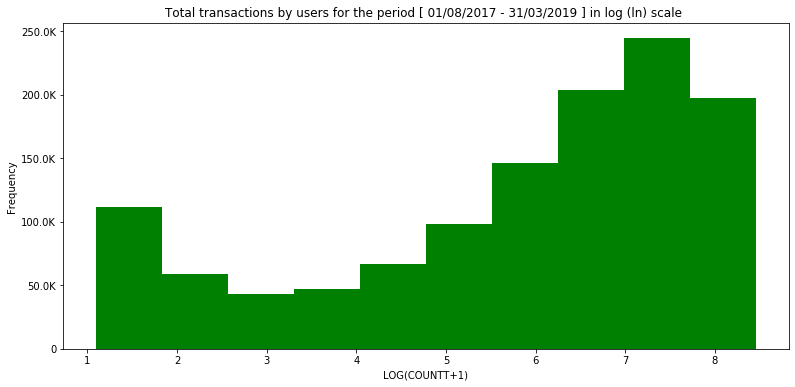

In [36]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Total transactions by users for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(COUNTT+1)')
hist(ax,freq_equp2_log.select("ln(countt+1)"),color='green')
plt.show()

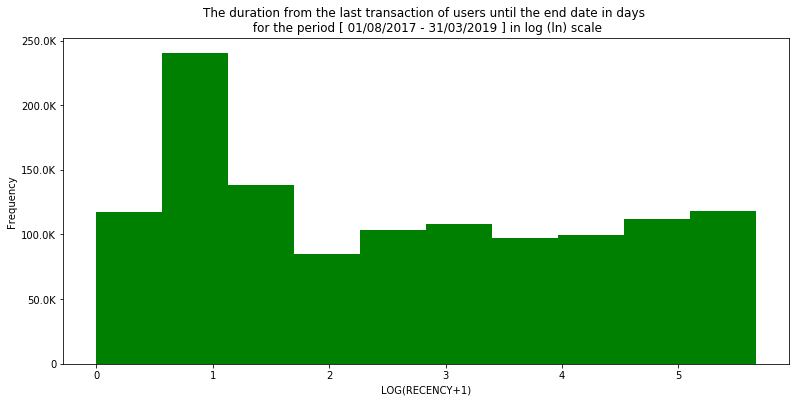

In [37]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(RECENCY+1)')
hist(ax,freq_equp2_log.select("ln(recency+1)"),color='green')
plt.show()

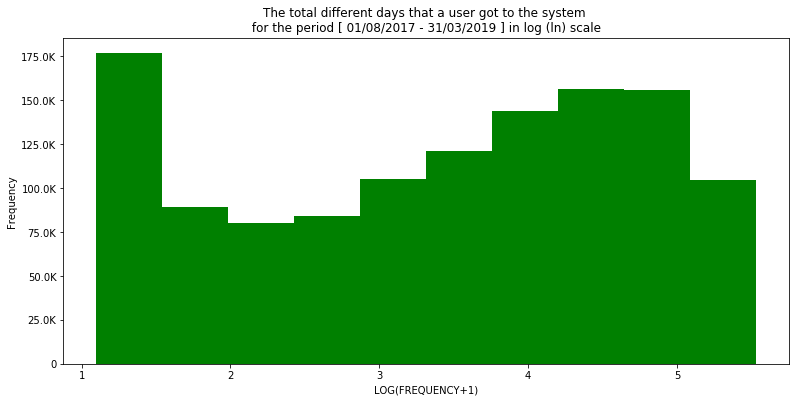

In [38]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(FREQUENCY+1)')
hist(ax,freq_equp2_log.select("ln(frequency+1)"),color='green')
plt.show()

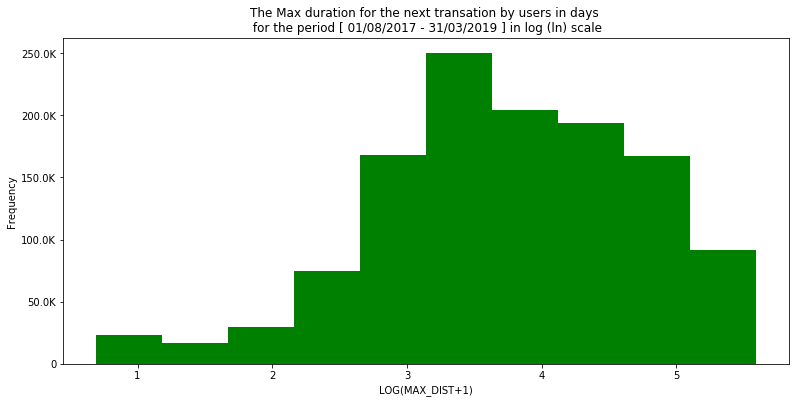

In [39]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The Max duration for the next transation by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(MAX_DIST+1)')
hist(ax,freq_equp2_log.select("ln(max_dist+1)"),color='green')
plt.show()

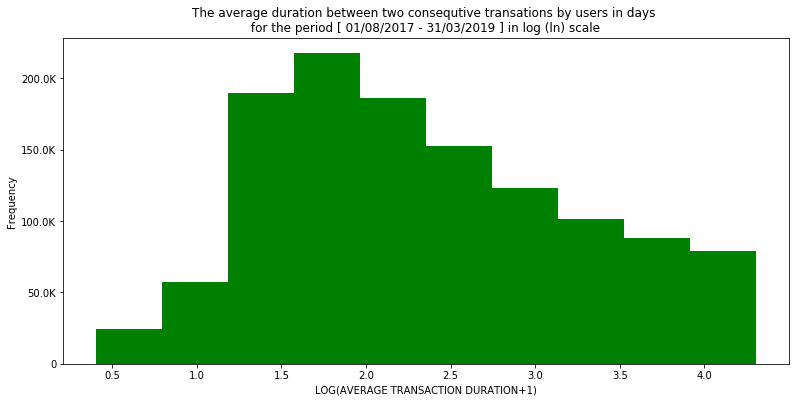

In [40]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(AVERAGE TRANSACTION DURATION+1)')
hist(ax,freq_equp2_log.select("ln(average_trans_dur+1)"),color='green')
plt.show()

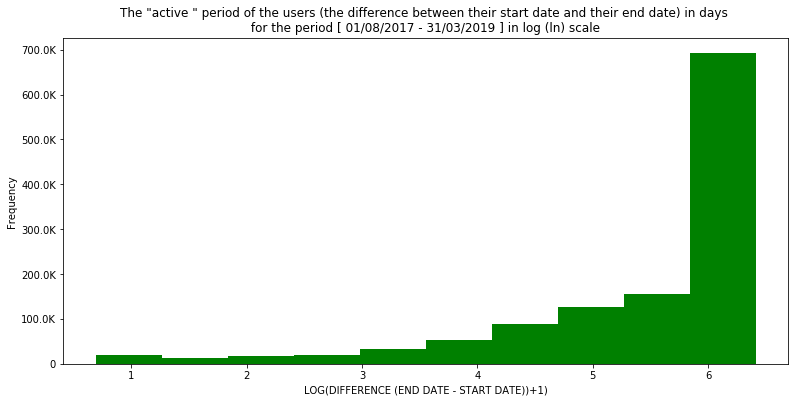

In [41]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The "active " period of the users (the difference between their start date and their end date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(DIFFERENCE (END DATE - START DATE))+1)')
hist(ax,freq_equp2_log.select("ln(diff_maxd_mind_days+1)"),color='green')
plt.show()

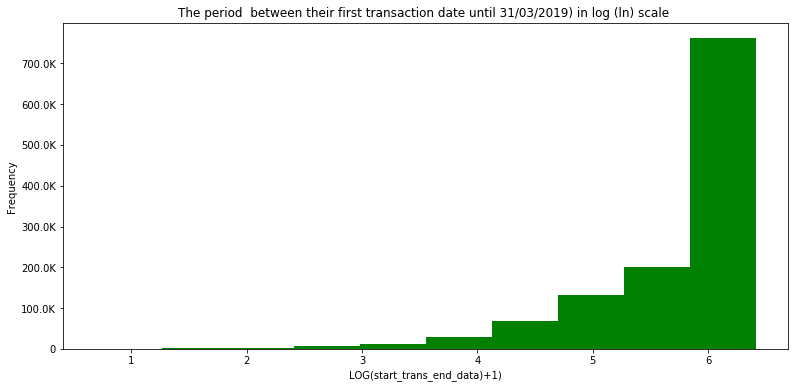

In [42]:
# hist for ln(start_trans_end_data+1)
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The period  between their first transaction date until 31/03/2019) in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(start_trans_end_data)+1)')
hist(ax,freq_equp2_log.select("ln(start_trans_end_data+1)"),color='green')
plt.show()

### Histograms for log data and with log y axis 

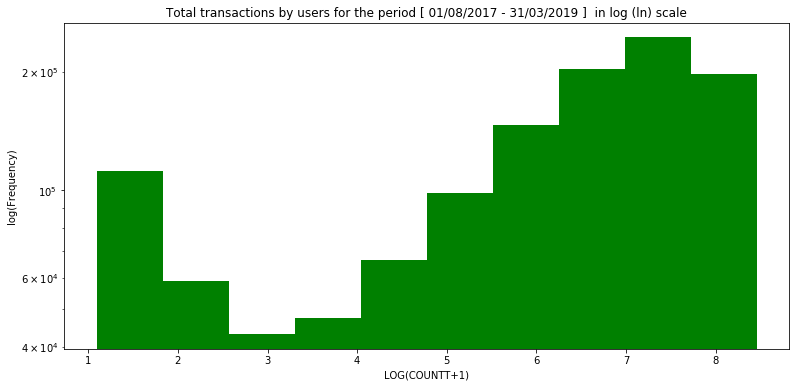

In [43]:
#plot histogram with log y scale
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('Total transactions by users for the period [ 01/08/2017 - 31/03/2019 ]  in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(COUNTT+1)')
hist(ax,freq_equp2_log.select("ln(countt+1)"),color='green')
plt.yscale('log')

plt.show()

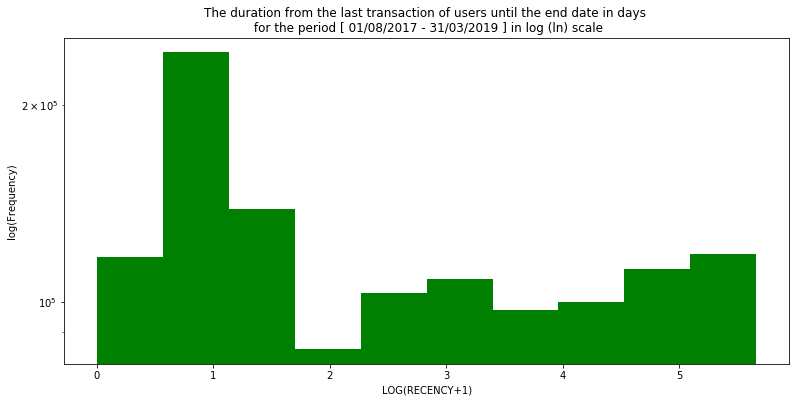

In [44]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(RECENCY+1)')
hist(ax,freq_equp2_log.select("ln(recency+1)"),color='green')
plt.yscale('log')

plt.show()

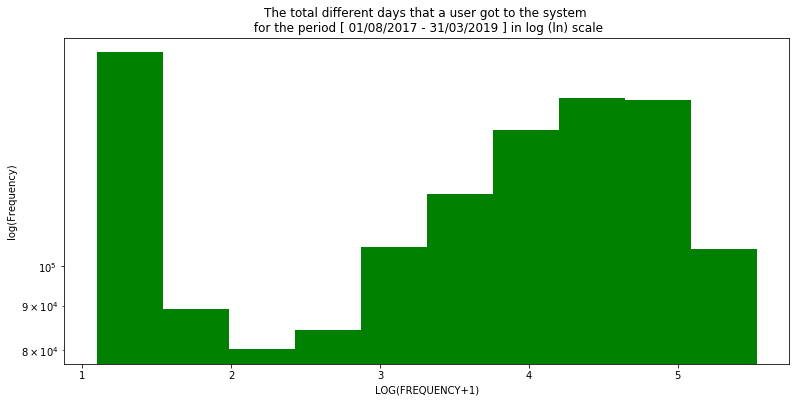

In [45]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(FREQUENCY+1)')
hist(ax,freq_equp2_log.select("ln(frequency+1)"),color='green')
plt.yscale('log')

plt.show()

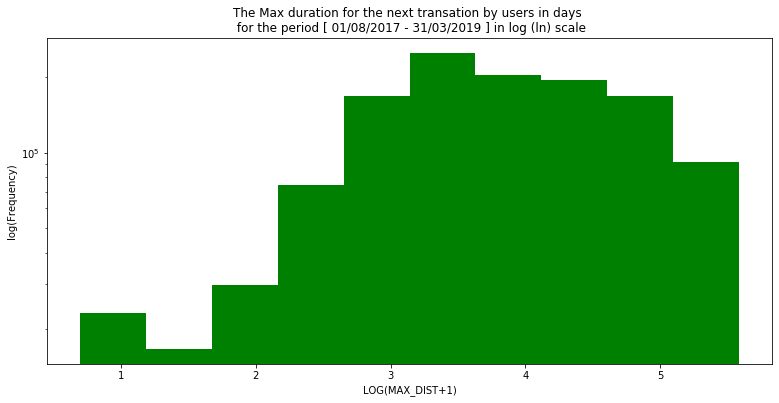

In [46]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The Max duration for the next transation by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(MAX_DIST+1)')
hist(ax,freq_equp2_log.select("ln(max_dist+1)"),color='green')
plt.yscale('log')

plt.show()

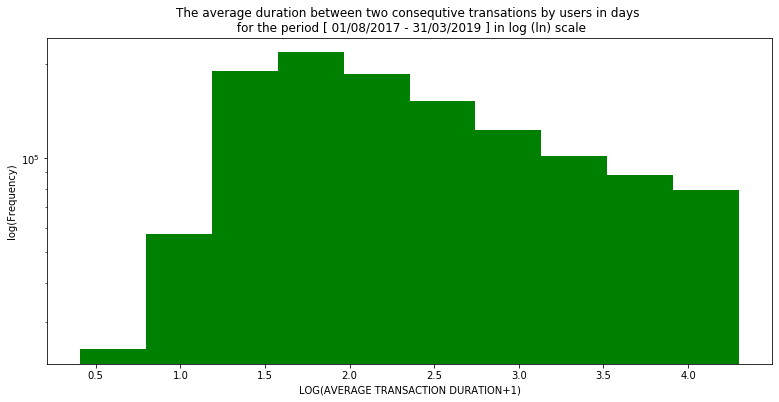

In [47]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(AVERAGE TRANSACTION DURATION+1)')
hist(ax,freq_equp2_log.select("ln(average_trans_dur+1)"),color='green')
plt.yscale('log')

plt.show()

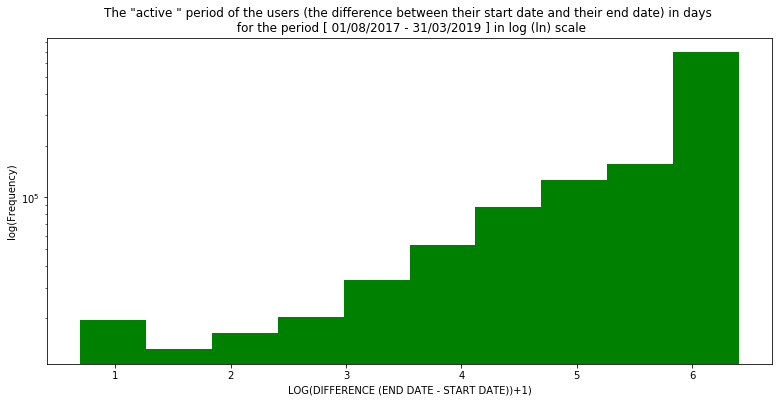

In [48]:
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The "active " period of the users (the difference between their start date and their end date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
ax.set_ylabel('log(Frequency)')
ax.set_xlabel('LOG(DIFFERENCE (END DATE - START DATE))+1)')
hist(ax,freq_equp2_log.select("ln(diff_maxd_mind_days+1)"),color='green')
plt.yscale('log')

plt.show()

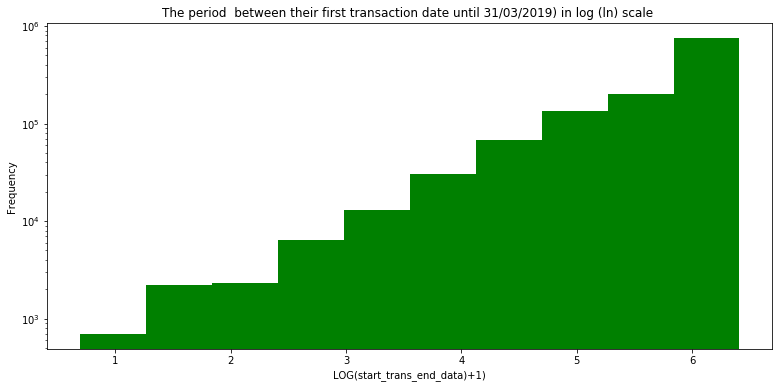

In [49]:
# hist for ln(start_trans_end_data+1)
fig, ax = plt.subplots(figsize = (13,6))
ax.set_title('The period  between their first transaction date until 31/03/2019) in log (ln) scale ')
ax.set_ylabel('Frequency')
ax.set_xlabel('LOG(start_trans_end_data)+1)')
hist(ax,freq_equp2_log.select("ln(start_trans_end_data+1)"),color='green')
plt.yscale('log')

plt.show()

## Histograms with pandas

Due to the fact that PySpark doesn't have any plotting functionality (yet), if we want to plot something,we can bring the data out of the Spark Context and into our "local" Python session, where we can deal with it using any of Python's many plotting libraries. For this reason, a transformation to a pandas dataframe follows:

# histogram 

We have to use logarithmic scale in graph due to the fact that we have a case in which one or a few points are much larger than the bulk of the data. For this reason I convert the spark dataframe to pandas to do some histograms.

In [25]:
pd_freq_equp2_log=freq_equp2_log.toPandas()
pd_freq_equp2_log

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,ln(countt+1),ln(recency+1),ln(frequency+1),ln(max_dist+1),ln(average_trans_dur+1),ln(diff_maxd_mind_days+1),ln(start_trans_end_data+1)
0,-3076708436585629202,38.0,168.0,9.0,61.0,33.78,304.0,472.0,3.663562,5.129899,2.302585,4.127134,3.549043,5.720312,6.159095
1,-1383360085895621481,2687.0,1.0,106.0,6.0,1.35,143.0,144.0,7.896553,0.693147,4.672829,1.945910,0.854415,4.969813,4.976734
2,-4373917140025030743,349.0,7.0,24.0,71.0,11.17,268.0,275.0,5.857933,2.079442,3.218876,4.276666,2.498974,5.594711,5.620401
3,-1932624376972617513,16.0,17.0,14.0,118.0,38.71,542.0,559.0,2.833213,2.890372,2.708050,4.779123,3.681603,6.297109,6.327937
4,8138114728915753073,2250.0,13.0,113.0,27.0,5.23,591.0,604.0,7.719130,2.639057,4.736198,3.332205,1.829376,6.383507,6.405228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218747,6215693035640726241,1731.0,3.0,108.0,29.0,5.42,585.0,588.0,7.457032,1.386294,4.691348,3.401197,1.859418,6.373320,6.378426
1218748,-695014438646068338,901.0,1.0,72.0,25.0,2.19,158.0,159.0,6.804615,0.693147,4.290459,3.258097,1.160021,5.068904,5.075174
1218749,9193353595840245243,294.0,30.0,13.0,258.0,39.38,512.0,542.0,5.686975,3.433987,2.639057,5.556828,3.698335,6.240276,6.297109
1218750,5232325352528294823,687.0,2.0,21.0,33.0,13.10,275.0,277.0,6.533789,1.098612,3.091042,3.526361,2.646175,5.620401,5.627621


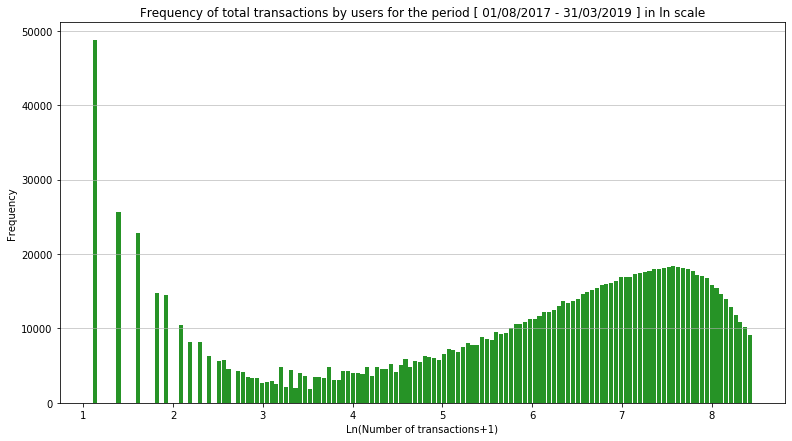

In [52]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(countt+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(Number of transactions+1)')
plt.ylabel('Frequency')
plt.title('Frequency of total transactions by users for the period [ 01/08/2017 - 31/03/2019 ] in ln scale')
#plt.yscale('log')
plt.show()

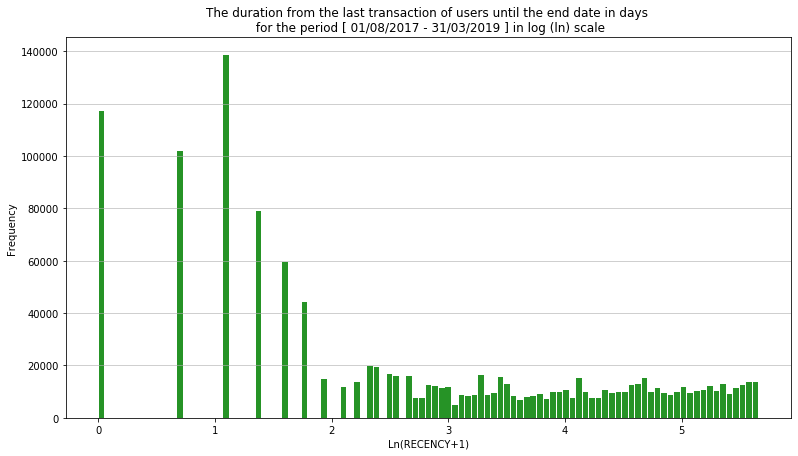

In [53]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(recency+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(RECENCY+1)')
plt.ylabel('Frequency')
plt.title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
#plt.yscale('log')

plt.show()

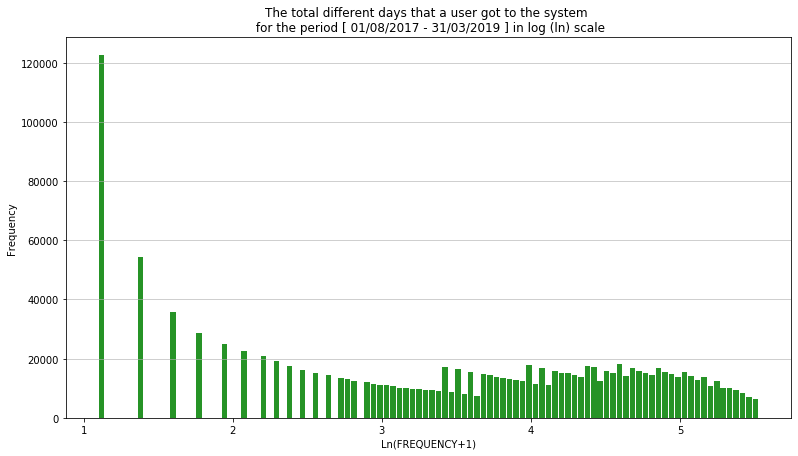

In [54]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(frequency+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(FREQUENCY+1)')
plt.ylabel('Frequency')
plt.title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
#plt.yscale('log')

plt.show()


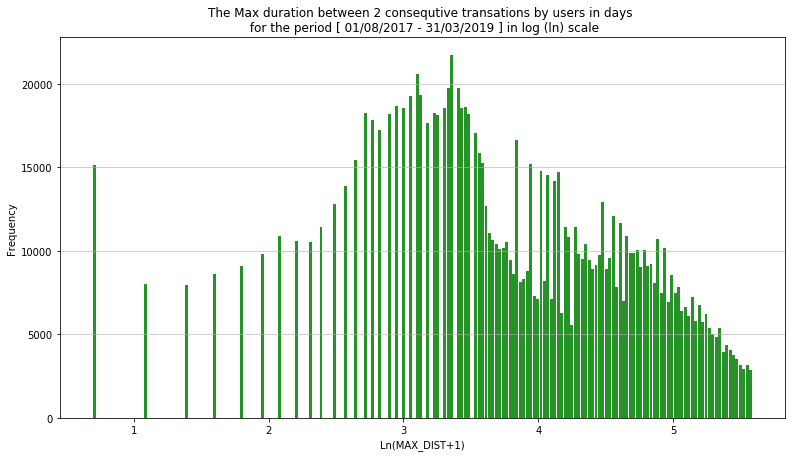

In [55]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(max_dist+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(MAX_DIST+1)')
plt.ylabel('Frequency')
plt.title('The Max duration between 2 consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
#plt.yscale('log')

plt.show()

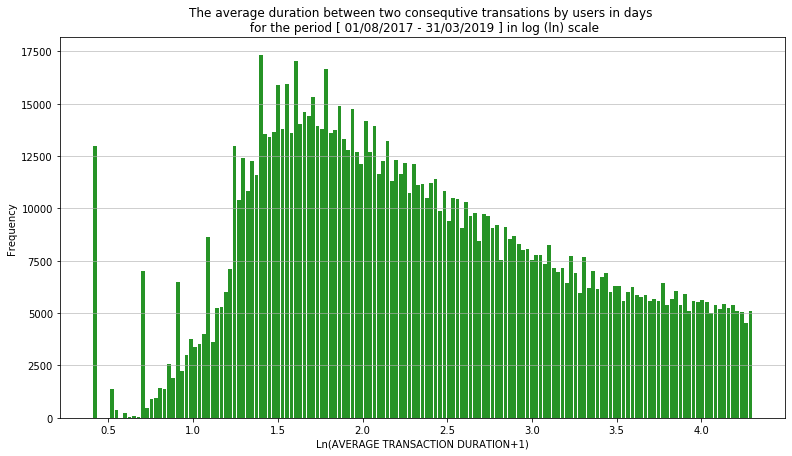

In [56]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(average_trans_dur+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(AVERAGE TRANSACTION DURATION+1)')
plt.ylabel('Frequency')
plt.title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
#plt.yscale('log')

plt.show()

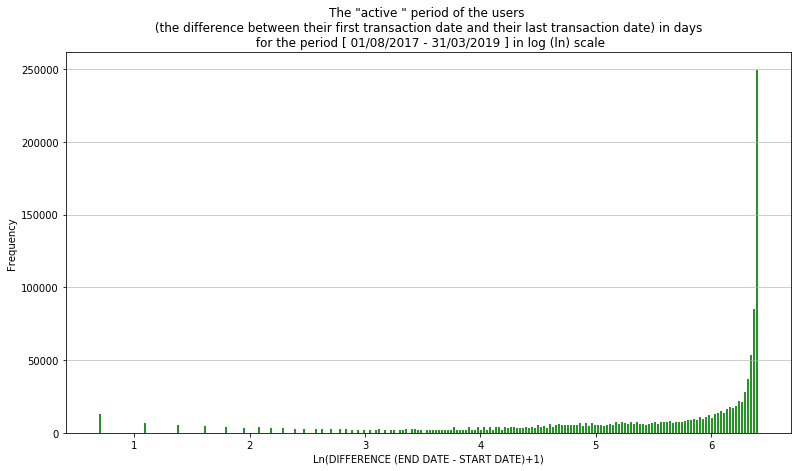

In [57]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(diff_maxd_mind_days+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(DIFFERENCE (END DATE - START DATE)+1)')
plt.ylabel('Frequency')
plt.title('The "active " period of the users \n (the difference between their first transaction date and their last transaction date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
#plt.yscale('log')

plt.show()

the above histogram has overwhelmingly low values, so it is required to use log scale.  

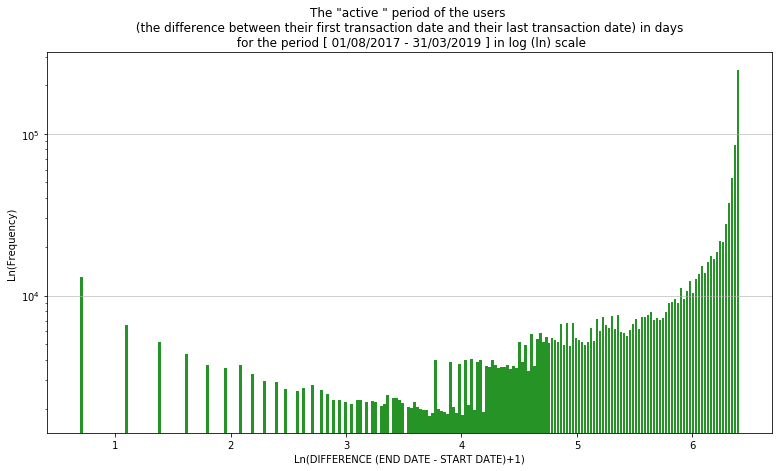

In [58]:
#Make the last hist with y scale as log 
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(diff_maxd_mind_days+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(DIFFERENCE (END DATE - START DATE)+1)')
plt.ylabel('Ln(Frequency)')
plt.title('The "active " period of the users \n (the difference between their first transaction date and their last transaction date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in log (ln) scale')
plt.yscale('log')

plt.show()

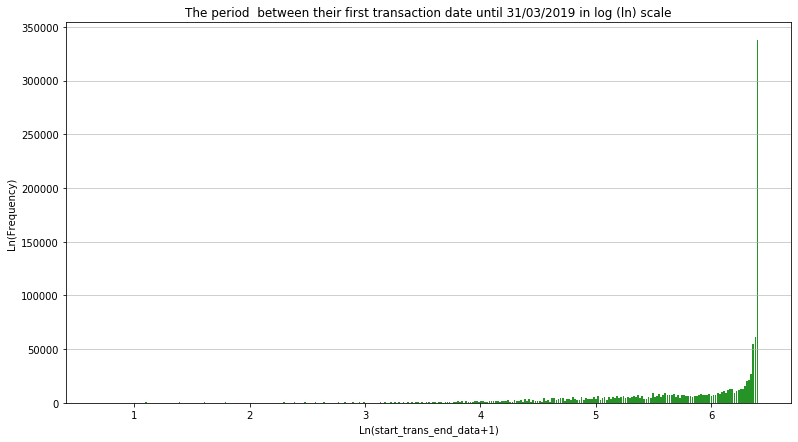

In [59]:
#hist for start_end
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(start_trans_end_data+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(start_trans_end_data+1)')
plt.ylabel('Ln(Frequency)')
plt.title('The period  between their first transaction date until 31/03/2019 in log (ln) scale')
#plt.yscale('log')

plt.show()

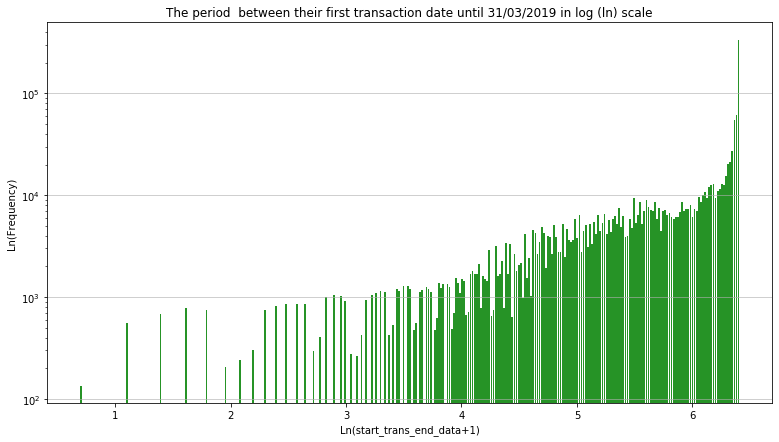

In [60]:
#hist for start_end with y axis log scale
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_freq_equp2_log['ln(start_trans_end_data+1)'], bins='auto', color='green',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Ln(start_trans_end_data+1)')
plt.ylabel('Ln(Frequency)')
plt.title('The period  between their first transaction date until 31/03/2019 in log (ln) scale')
plt.yscale('log')

plt.show()

In [26]:
#Take the users and convert to pandas
pd_users=users.toPandas()
#pd_users

### Convert the data to float

In [27]:
#convert the data columns to float
pd_freq_equp2_log.countt=pd.to_numeric(pd_freq_equp2_log.countt)
pd_freq_equp2_log.recency=pd.to_numeric(pd_freq_equp2_log.recency)
pd_freq_equp2_log.frequency=pd.to_numeric(pd_freq_equp2_log.frequency)
pd_freq_equp2_log.max_dist=pd.to_numeric(pd_freq_equp2_log.max_dist)
pd_freq_equp2_log.average_trans_dur=pd.to_numeric(pd_freq_equp2_log.average_trans_dur)
pd_freq_equp2_log.diff_maxd_mind_days=pd.to_numeric(pd_freq_equp2_log.diff_maxd_mind_days)
pd_freq_equp2_log.start_trans_end_data=pd.to_numeric(pd_freq_equp2_log.start_trans_end_data)
pd_freq_equp2_log.dtypes

client_username_s              object
countt                        float64
recency                       float64
frequency                     float64
max_dist                      float64
average_trans_dur             float64
diff_maxd_mind_days           float64
start_trans_end_data          float64
ln(countt+1)                  float64
ln(recency+1)                 float64
ln(frequency+1)               float64
ln(max_dist+1)                float64
ln(average_trans_dur+1)       float64
ln(diff_maxd_mind_days+1)     float64
ln(start_trans_end_data+1)    float64
dtype: object

# scatter matrix

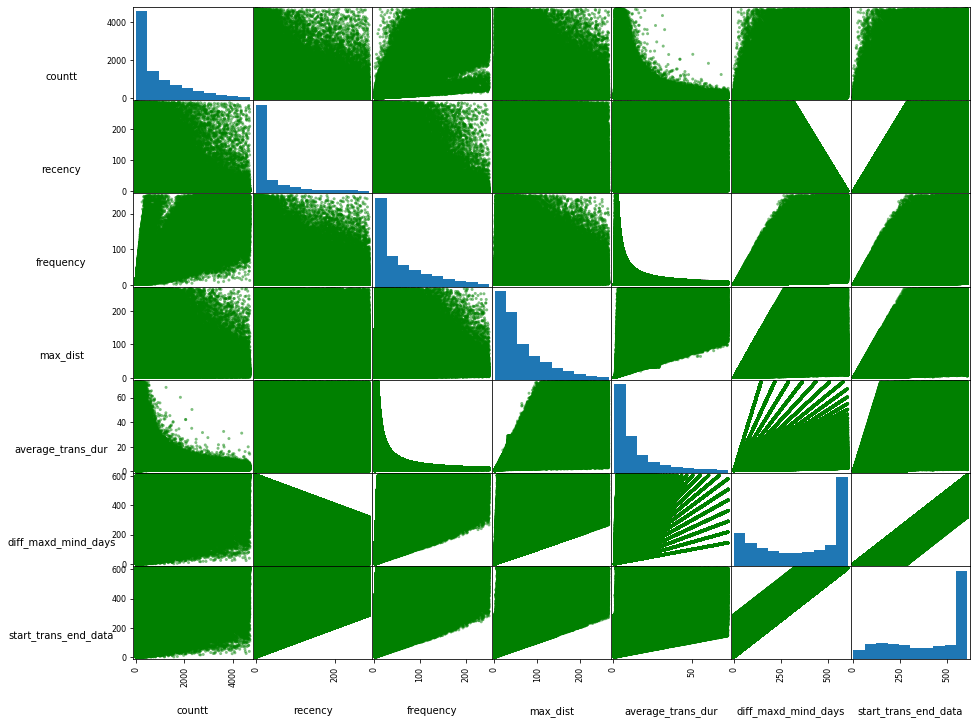

In [71]:
#scatter_matrix for numeric columns of filtered dataframe cluster data

plot2=scatter_matrix(pd_freq_equp2_log.loc[:,'countt':'start_trans_end_data'],figsize=(15,12),c='green')
#change the appearance of ticklabels
[s.yaxis.label.set_rotation(360) for s in plot2.reshape(-1)]
#May need to offset label when rotating to prevent overlap of figure
[s.get_xaxis().set_label_coords(0.5,-0.5) for s in plot2.reshape(-1)]
[s.get_yaxis().set_label_coords(-0.6,0.2) for s in plot2.reshape(-1)]
plt.show()

In [28]:
#convert to float all the numerical features in the pyspark df
FEATURES_COL = ['countt','recency','frequency','max_dist','average_trans_dur', 'diff_maxd_mind_days','start_trans_end_data']
for col in freq_equp2.columns:
    if col in FEATURES_COL:
        freq_equp2 = freq_equp2.withColumn(col,freq_equp2[col].cast('float'))
#see the data type
freq_equp2.dtypes        

[('client_username_s', 'string'),
 ('countt', 'float'),
 ('recency', 'float'),
 ('frequency', 'float'),
 ('max_dist', 'float'),
 ('average_trans_dur', 'float'),
 ('diff_maxd_mind_days', 'float'),
 ('start_trans_end_data', 'float')]

# Convert to pandas

In [29]:
pd__freq_equp2=freq_equp2.toPandas()
pd__freq_equp2

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,-3076708436585629202,38.0,168.0,9.0,61.0,33.779999,304.0,472.0
1,-1383360085895621481,2687.0,1.0,106.0,6.0,1.350000,143.0,144.0
2,-4373917140025030743,349.0,7.0,24.0,71.0,11.170000,268.0,275.0
3,-1932624376972617513,16.0,17.0,14.0,118.0,38.709999,542.0,559.0
4,8138114728915753073,2250.0,13.0,113.0,27.0,5.230000,591.0,604.0
...,...,...,...,...,...,...,...,...
1218747,6215693035640726241,1731.0,3.0,108.0,29.0,5.420000,585.0,588.0
1218748,-695014438646068338,901.0,1.0,72.0,25.0,2.190000,158.0,159.0
1218749,9193353595840245243,294.0,30.0,13.0,258.0,39.380001,512.0,542.0
1218750,5232325352528294823,687.0,2.0,21.0,33.0,13.100000,275.0,277.0


# Correlation between variables- features - Correlation matrix about features

#### I run this part on jupyter notebook on windows. The file is the same I extracted  from the windows jupyter notebook (dfclient_feat_out4). This is the  reason that I do not export it again to csv. Open the jupyter notebook file(Outliers_Correlation-visualization_4months.ipynb) and you can see it in the 2nd part. 

# PCA

###  Due to the small number of features there is no need (?) to apply PCA or any other algorithm for reducing dimensionality.   

# CLIENT SEGMENTATION

# 1st APPROACH 

## RFM ANALYSIS

I will apply RFM analysis on the subset pro data

#### Recency – How recently did the customer get to the system NBG ? i.e. Duration since last transaction.Recency is the most important predictor of who is more likely to respond to an offer. Customers who have got to the system  recently are more likely to enter  again when compared to those who did not entered recently.
#### Frequency – How often do they connect with the NBG? i.e. How many days (different days ) the client got to the system to NBG in the whole period of collected data.The second most important factor is how frequently these customers purchase. The higher the frequency, the higher is the chances of these responding to the offers.

## Determine cutting points-calculate R & F scores

The cutting points are mainly depend on the business sense. After discussing with the people in charge of the project, I decided to follow the quintiles method.Using quintiles is more flexible, as the ranges will adapt to the data and would work across different industries or if there's any change in expected customer behavior. First, I get the quantiles for each parameter.An other method would be to consider the actual number of the parameters.RFM analysis involves categorising R and F into 3 or more categories.I will create 5 categories based on quartiles (quartiles roughly divide the sample into 5 segments equal proportion and they are a specific category of quantiles.

In [385]:
#create a dictionary in which there is a match between quantiles and numbers

q = pd__freq_equp2[['countt','recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']].quantile([.25,.50,.75]).to_dict()
q

{'countt': {0.25: 93.0, 0.5: 598.0, 0.75: 1642.0},
 'recency': {0.25: 2.0, 0.5: 10.0, 0.75: 59.0},
 'frequency': {0.25: 8.0, 0.5: 35.0, 0.75: 91.0},
 'max_dist': {0.25: 22.0, 0.5: 41.0, 0.75: 89.0},
 'average_trans_dur': {0.25: 4.099999904632568,
  0.5: 8.100000381469727,
  0.75: 19.299999237060547},
 'diff_maxd_mind_days': {0.25: 144.0, 0.5: 420.0, 0.75: 582.0},
 'start_trans_end_data': {0.25: 226.0, 0.5: 479.0, 0.75: 599.0}}

I assign ranks from 1 to 4. A smaller Recency value is better whereas higher Frequency values are better. Hence,with the same logic ,the categorising scheme need to be reverse for some of the features-variables.

In [386]:
#create a function for recency score. 

def recency_class(x):
    if x <= q['recency'][.25]:
        return 1
    elif x <= q['recency'][.50]:
        return 2
    elif x <= q['recency'][.75]:
        return 3
    else:
        return 4
       
#create a function for frequency score
    
def frequency_class(x):
    if x <= q['frequency'][.25]:  
        return 4
    elif x <= q['frequency'][.50]:
        return 3
    elif x <= q['frequency'][.75]:
        return 2
    else:
        return 1
       
#create a function for count score
    
#def countt_class(x):
#    if x <= q['countt'][.25]:  
#        return 4
#    elif x <= q['countt'][.50]:
#        return 3
#    elif x <= q['countt'][.75]:
#        return 2
#    else:
#        return 1
       
#create a function for max_dist_s score
    
def max_dist_class(x):
    if x <= q['max_dist'][.25]:  
        return 1
    elif x <= q['max_dist'][.50]:
        return 2
    elif x <= q['max_dist'][.75]:
        return 3
    else:
        return 4
         
#create a function for average_trans_dur_s score. 

def average_trans_dur_class(x):
    if x <= q['average_trans_dur'][.25]:
        return 1
    elif x <= q['average_trans_dur'][.50]:
        return 2
    elif x <= q['average_trans_dur'][.75]:
        return 3
    else:
        return 4
       
#create a function for diff_maxd_mind_days_s score
    
#def diff_maxd_mind_days_class(x):
#    if x <= q['diff_maxd_mind_days'][.25]:  
#        return 4
#    elif x <= q['diff_maxd_mind_days'][.50]:
#        return 3
#    elif x <= q['diff_maxd_mind_days'][.75]:
#        return 2
#    else:
#        return 1

    
# For the last variable i will not divide the clients to classes because there has no meaning for the division in classes   
       

In [387]:
#apply the functions to the columns      

#pd__freq_equp2['C'] =pd__freq_equp2['countt'].apply(lambda x: countt_class(x))
pd__freq_equp2['R'] =pd__freq_equp2['recency'].apply(lambda x: recency_class(x))
pd__freq_equp2['F'] =pd__freq_equp2['frequency'].apply(lambda x: frequency_class(x))
pd__freq_equp2['MD'] =pd__freq_equp2['max_dist'].apply(lambda x: max_dist_class(x))
pd__freq_equp2['A'] =pd__freq_equp2['average_trans_dur'].apply(lambda x: average_trans_dur_class(x))
#pd__freq_equp2['D'] =pd__freq_equp2['diff_maxd_mind_days'].apply(lambda x: diff_maxd_mind_days_class(x))


For analysis it is critical to combine the scores to create a single score so as to do client segmentation.In order to do that, we can concatenate the scores to create a 2 digit number between 11 and 44. We could also combine the scores summing the digits. Each method has advantages and disadvantages. 

## Distribution of flags

https://medium.com/@tomar.ankur287/customer-segmentation-using-rfm-analysis-in-python-bb6f1bd2fce5

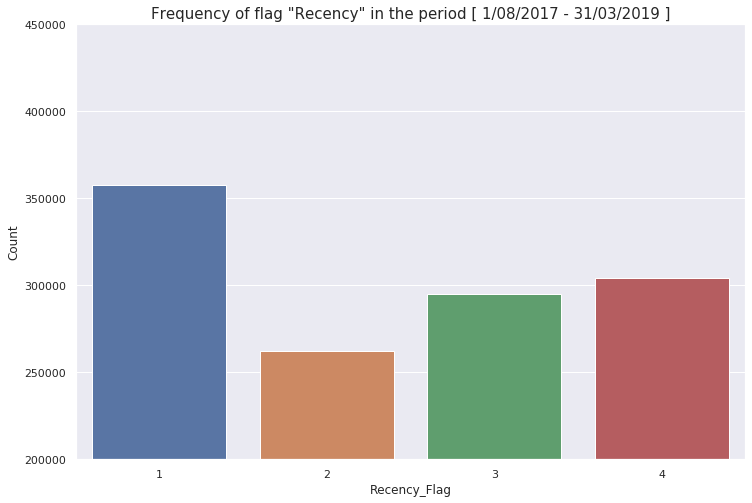

In [106]:
#Let us check the distribution of Recency flags:
plt.figure(figsize=(12,8))
sns.countplot(x="R", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Recency_Flag', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Frequency of flag "Recency" in the period [ 1/08/2017 - 31/03/2019 ]', fontsize=15)
plt.ylim((200000,450000))
plt.show()

### Τhings worth pointing out 

It can be seen that around 350.000 clients out of 1.218.752 did their last transaction equal or less than 2 days. (i.e two days before the end date of collection data and earlier.).There is an approximate small number of clients who did their last transaction before 10 days from the last collection date of data.(This class gathers the less clients).On the other side  we could note that there are approximateley ~ 300.000 who have not got to the nbg system over 59 days ( ~ 2 months ).

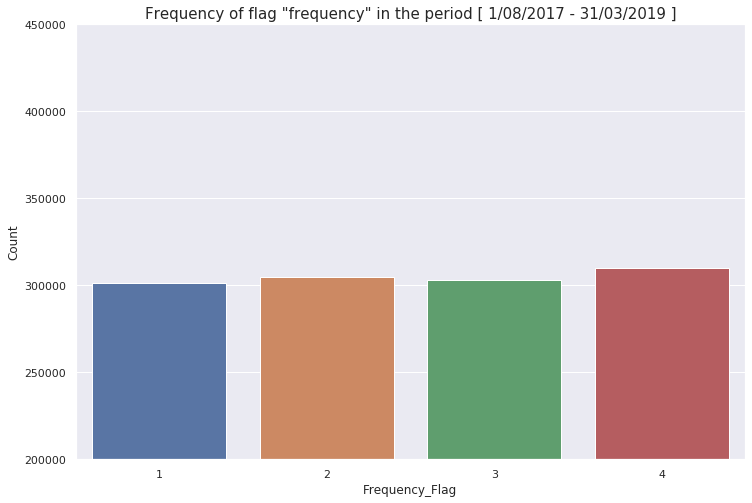

In [107]:
#Let us check the distribution of Frequency flags:
plt.figure(figsize=(12,8))
sns.countplot(x="F", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Frequency_Flag', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title('Frequency of flag "frequency" in the period [ 1/08/2017 - 31/03/2019 ]', fontsize=15)
plt.ylim((200000,450000))

plt.show()

### Τhings worth pointing out 
Generally we could observe that there is a uniformity as far as the grouping is concerned. Now the order is the oposite from the respective one of recency.It can be seen that around 300.000 clients out of 1.218.752 got to the nbg system over 91 times(i.e.the 25% of the clients) in the study period. In addition , there is an approximate quite big number of clients (approximately 310.000 who got to the system only 8 or less than 8 times in the time period of 20 months.

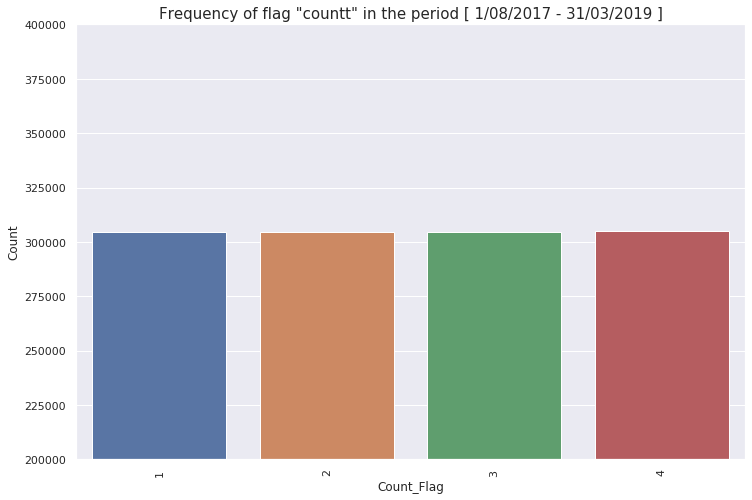

In [108]:
#Let us check the distribution of Count flags:
plt.figure(figsize=(12,8))
sns.countplot(x="C", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Count_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of flag "countt" in the period [ 1/08/2017 - 31/03/2019 ]', fontsize=15)
plt.ylim((200000,400000))
plt.show()

### Τhings worth pointing out
FRom the above graph we could say that again there is a pronounced uniformity as far as the variable "countt" is concerned.Each of the four categories concentrates approximately 310.000 clients (25% of all clients), in other words each of the four classes consists of the 1\4 of the total clients.


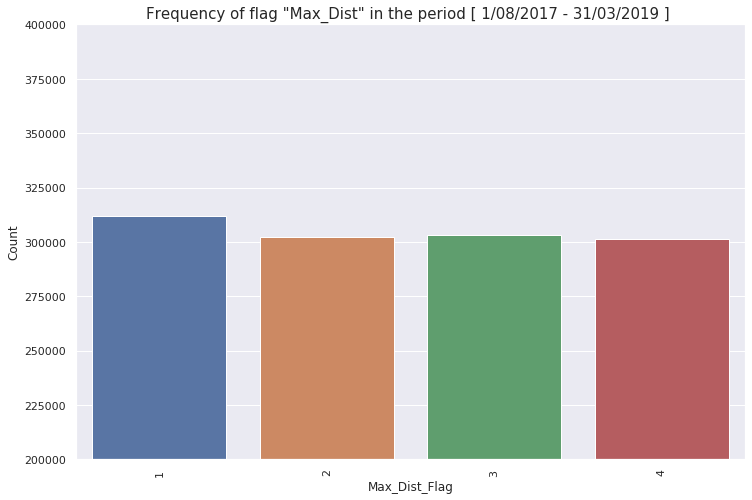

In [109]:
#Let us check the distribution of max_dist flags:
plt.figure(figsize=(12,8))
sns.countplot(x="MD", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Max_Dist_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of flag "Max_Dist" in the period [ 1/08/2017 - 31/03/2019 ] ', fontsize=15)
plt.ylim((200000,400000))

plt.show()

### Τhings worth pointing out
From the above graph we can observe that approxiamtely 310.000 clients did their next consecutive transaction within 22 days maximum. Furthermore, there are just over 300.000 clients who did it over 89 days ( ~ over 3 months ) in the study period of 20 months.

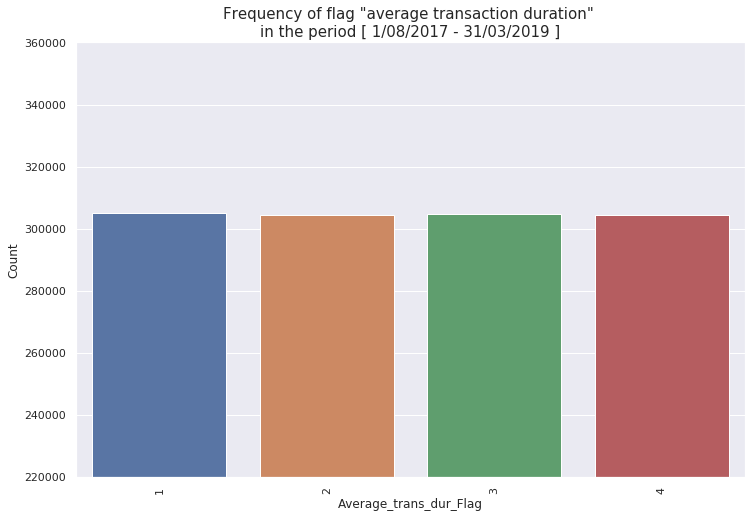

In [110]:
#Let us check the distribution of avearge transaction's duration flags:
plt.figure(figsize=(12,8))
sns.countplot(x="A", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Average_trans_dur_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of flag "average transaction duration" \nin the period [ 1/08/2017 - 31/03/2019 ]', fontsize=15)
plt.ylim((220000,360000))
plt.show()

### Τhings worth pointing out
FRom the above graph we could say that there is a pronounced uniformity as far as the variable "average_trans_dur" is concerned as with the variable "countt".Each of the four categories concentrates approximately 310.000 clients (25% of all clients), in other words each of the four classes consists of the 1\4 of the total clients.

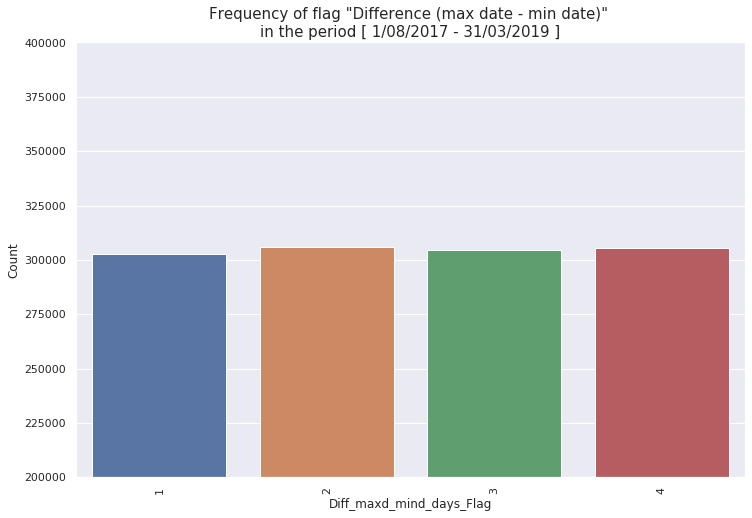

In [111]:
#Let us check the distribution of diff_maxd_mind_days_s flags:
plt.figure(figsize=(12,8))
sns.countplot(x="D", data=pd__freq_equp2)
sns.set(style="darkgrid")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Diff_maxd_mind_days_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of flag "Difference (max date - min date)" \nin the period [ 1/08/2017 - 31/03/2019 ]', fontsize=15)
plt.ylim((200000,400000))
plt.show()

### Τhings worth pointing out
As far as the last countplot is concerned,we could say that things are very uniform again. For approximately 300.000 clients,their "active "period (first transaction -last transaction) was over 582 days in the period of 20 months (over 19,5 months) that I study. In that point, we should mention that 600 days are the whole days from start date until end date of collection data.

### Table with values ,classes and variables-features

In [388]:
# initialise data of lists. 
dataFORTABLE = {'Class':['1','2','3','4'],
                'Recency-R':['R <= 2 days','R <= 10 days','R <= 59 days','R > 59 days'],
                'Frequency-F':['F > 91 days','F <= 91 days','F <= 35 days', 'F <= 8 days'],
                'Count-C':['C > 1642 trans','C <= 1642 trans','C <= 598 trans', 'C <= 93 trans'],
                'Max_Distance-MD':['MD <= 22 days','MD <= 41 days','MD <= 89 days','MD > 89 days'],
                'Average_trans_duration-A':['A <= 4.1 days','A <= 8.1 days','A <= 19.3 days','A > 19.3 days'],
                'Diff_maxd_mind_days-D':['D > 582 days','D <= 582 days','D <= 420 days', 'D <= 144 days']} 

# Creates pandas DataFrame. 
dfT = pd.DataFrame(dataFORTABLE) 
# print the data 
tablerf=dfT.set_index('Class')
tablerf

,Recency-R,Frequency-F,Count-C,Max_Distance-MD,Average_trans_duration-A,Diff_maxd_mind_days-D
Class,,,,,,
1,R <= 2 days,F > 91 days,C > 1642 trans,MD <= 22 days,A <= 4.1 days,D > 582 days
2,R <= 10 days,F <= 91 days,C <= 1642 trans,MD <= 41 days,A <= 8.1 days,D <= 582 days
3,R <= 59 days,F <= 35 days,C <= 598 trans,MD <= 89 days,A <= 19.3 days,D <= 420 days
4,R > 59 days,F <= 8 days,C <= 93 trans,MD > 89 days,A > 19.3 days,D <= 144 days


### PLOT THE DISTRIBUTION

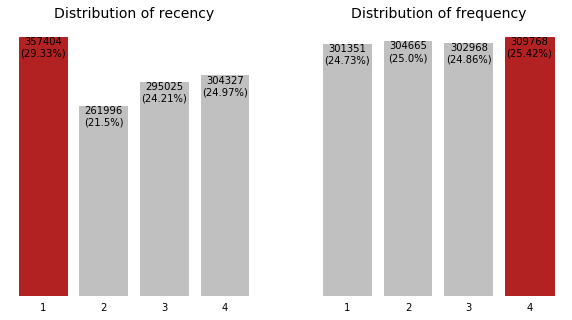

          Recency-R   Frequency-F
Class                            
1       R <= 2 days   F > 91 days
2      R <= 10 days  F <= 91 days
3      R <= 59 days  F <= 35 days
4       R > 59 days   F <= 8 days


In [389]:
# plot the distribution of clients over R , F 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'recency', 'F':'frequency',}
    y = pd__freq_equp2[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value),np.round(value * 100 / y.sum(),2)),
               ha='center',
               va='top',
               color='black')
plt.show()

print(tablerf[['Recency-R','Frequency-F']])


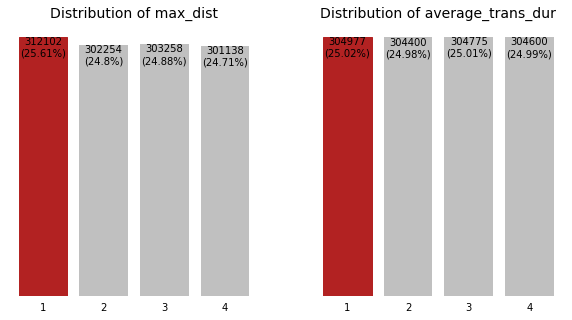

      Max_Distance-MD Average_trans_duration-A
Class                                         
1       MD <= 22 days            A <= 4.1 days
2       MD <= 41 days            A <= 8.1 days
3       MD <= 89 days           A <= 19.3 days
4        MD > 89 days            A > 19.3 days


In [390]:
# plot the distribution of clients over C , MD 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, p in enumerate(['MD', 'A']):
    parameters = {'MD':'max_dist', 'A':'average_trans_dur',}
    y = pd__freq_equp2[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value),np.round(value * 100 / y.sum(),2)),
               ha='center',
               va='top',
               color='black')
plt.show()

print(tablerf[['Max_Distance-MD','Average_trans_duration-A']])

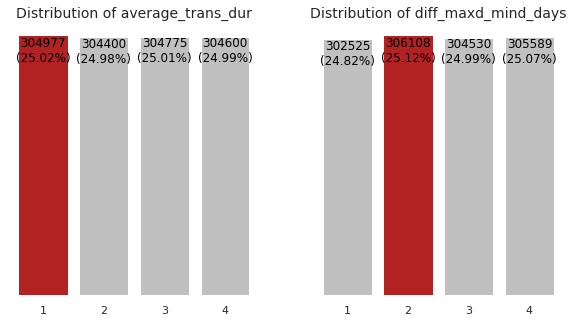

      Average_trans_duration-A Diff_maxd_mind_days-D
Class                                               
1                A <= 4.1 days          D > 582 days
2                A <= 8.1 days         D <= 582 days
3               A <= 19.3 days         D <= 420 days
4                A > 19.3 days         D <= 144 days


In [115]:
# plot the distribution of clients over A , D 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, p in enumerate(['A', 'D']):
    parameters = {'A':'average_trans_dur', 'D':'diff_maxd_mind_days',}
    y = pd__freq_equp2[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value),np.round(value * 100 / y.sum(),2)),
               ha='center',
               va='top',
               color='black')
plt.show()

print(tablerf[['Diff_maxd_mind_days-D','']])


In [33]:
pd__freq_equp2

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,C,R,F,MD,A,D
0,-3076708436585629202,38.0,168.0,9.0,61.0,33.779999,304.0,472.0,4,4,3,3,4,3
1,-1383360085895621481,2687.0,1.0,106.0,6.0,1.350000,143.0,144.0,1,1,1,1,1,4
2,-4373917140025030743,349.0,7.0,24.0,71.0,11.170000,268.0,275.0,3,2,3,3,3,3
3,-1932624376972617513,16.0,17.0,14.0,118.0,38.709999,542.0,559.0,4,3,3,4,4,2
4,8138114728915753073,2250.0,13.0,113.0,27.0,5.230000,591.0,604.0,1,3,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218747,6215693035640726241,1731.0,3.0,108.0,29.0,5.420000,585.0,588.0,1,2,1,2,2,1
1218748,-695014438646068338,901.0,1.0,72.0,25.0,2.190000,158.0,159.0,2,1,2,2,1,3
1218749,9193353595840245243,294.0,30.0,13.0,258.0,39.380001,512.0,542.0,3,3,3,4,4,2
1218750,5232325352528294823,687.0,2.0,21.0,33.0,13.100000,275.0,277.0,2,1,3,2,3,3


In [34]:
#create the RFM_score
pd__freq_equp2['RFM_score']=pd__freq_equp2['C'].map(str) + pd__freq_equp2['R'].map(str) + pd__freq_equp2['F'].map(str) + pd__freq_equp2['MD'].map(str) + pd__freq_equp2['A'].map(str) + pd__freq_equp2['D'].map(str)
pd__freq_equp2

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,C,R,F,MD,A,D,RFM_score
0,-3076708436585629202,38.0,168.0,9.0,61.0,33.779999,304.0,472.0,4,4,3,3,4,3,443343
1,-1383360085895621481,2687.0,1.0,106.0,6.0,1.350000,143.0,144.0,1,1,1,1,1,4,111114
2,-4373917140025030743,349.0,7.0,24.0,71.0,11.170000,268.0,275.0,3,2,3,3,3,3,323333
3,-1932624376972617513,16.0,17.0,14.0,118.0,38.709999,542.0,559.0,4,3,3,4,4,2,433442
4,8138114728915753073,2250.0,13.0,113.0,27.0,5.230000,591.0,604.0,1,3,1,2,2,1,131221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218747,6215693035640726241,1731.0,3.0,108.0,29.0,5.420000,585.0,588.0,1,2,1,2,2,1,121221
1218748,-695014438646068338,901.0,1.0,72.0,25.0,2.190000,158.0,159.0,2,1,2,2,1,3,212213
1218749,9193353595840245243,294.0,30.0,13.0,258.0,39.380001,512.0,542.0,3,3,3,4,4,2,333442
1218750,5232325352528294823,687.0,2.0,21.0,33.0,13.100000,275.0,277.0,2,1,3,2,3,3,213233


Since we have scores between 1 and 4, we don’t need to scale the numbers for k means (https://towardsdatascience.com/apply-rfm-principles-to-cluster-customers-with-k-means-fef9bcc9ab16)

In [46]:
#convert to spark df the pandas having elected specific columns
pandas_sub = pd__freq_equp2[['client_username_s','C','R','F','MD','A','D']]
#define the schema
mySchema = StructType([StructField("client_username_s", StringType(), False)
                       ,StructField("C", IntegerType(), False)\
                       ,StructField("R", IntegerType(), False)\
                       ,StructField("F", IntegerType(), False)\
                       ,StructField("MD", IntegerType(), False)\
                       ,StructField("A", IntegerType(), False)\
                       ,StructField("D", IntegerType(), False)])
spark_df=spark.createDataFrame(pandas_sub,schema=mySchema)                      

In [50]:
spark_df.show()

+--------------------+---+---+---+---+---+---+
|   client_username_s|  C|  R|  F| MD|  A|  D|
+--------------------+---+---+---+---+---+---+
|-3076708436585629202|  4|  4|  3|  3|  4|  3|
|-1383360085895621481|  1|  1|  1|  1|  1|  4|
|-4373917140025030743|  3|  2|  3|  3|  3|  3|
|-1932624376972617513|  4|  3|  3|  4|  4|  2|
| 8138114728915753073|  1|  3|  1|  2|  2|  1|
| 3238105438798080237|  2|  1|  1|  2|  2|  1|
| 6715359518456271901|  2|  2|  3|  2|  3|  3|
|-5699689628182849411|  1|  1|  1|  1|  1|  2|
| 3738582637858980585|  1|  3|  2|  2|  1|  4|
| 1928064594810315272|  2|  2|  2|  1|  1|  3|
|-8064344582484646647|  3|  3|  3|  4|  4|  3|
|-2537030807470187043|  4|  4|  4|  3|  4|  3|
|-4025425347570620616|  1|  1|  1|  1|  1|  1|
|-5436079748649137911|  1|  3|  2|  3|  2|  2|
| 4855070875121257943|  1|  1|  2|  2|  2|  1|
|-6610127114434328374|  1|  1|  1|  1|  1|  1|
| 7268818881845104395|  2|  2|  1|  3|  2|  2|
|-7386970584471026200|  1|  1|  2|  2|  2|  1|
| -5453124639

In [47]:
#one column
sthles=['C','R','F','MD','A','D']
vecAssembler_rfd = VectorAssembler(inputCols=sthles, outputCol="features")
df_kmeans_rfd = vecAssembler_rfd.transform(spark_df).select('client_username_s', 'features')
df_kmeans_rfd.show()

### Run the k means with the predefined number of classes so as to evaluate them. I compute the within sum of sqared error and Silhouette score.

In [49]:
#kmeans for k=4 classes
kmeans_rfd = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
model_rfd = kmeans_rfd.fit(df_kmeans_rfd.sample(False,0.1, seed=42))
wssse= model_rfd.computeCost(df_kmeans_rfd) #Evaluate clustering by computing within sum of sqared error
sil_costl=ClusteringEvaluator().evaluate(model_rfd.transform(df_kmeans_rfd)) #Evaluate clustering by computing Silhouette score
print('The within sum of sqared error is ',wssse)
print('The Silhouette score is ',sil_costl)

The within sum of sqared error is  3146630.886423094
The Silhouette score is  0.4810986903429088


I will compare these results with the optiaml number of clusters

# END OF THE RFM ANALYSIS

# 2nd APPROACH 

# CLUSTERING for segments

#### Convert to float the columns

In [60]:
#convert to float all the log features from double
FEATTTURES_COLS = ['ln(countt+1)','ln(recency+1)','ln(frequency+1)','ln(max_dist+1)','ln(average_trans_dur+1)', 'ln(diff_maxd_mind_days+1)','ln(start_trans_end_data+1)']
for col in freq_equp2_log.columns:
    if col in FEATTTURES_COLS:
        freq_equp2_log = freq_equp2_log.withColumn(col,freq_equp2_log[col].cast('float'))
freq_equp2_log.dtypes


[('client_username_s', 'string'),
 ('countt', 'double'),
 ('recency', 'double'),
 ('frequency', 'double'),
 ('max_dist', 'double'),
 ('average_trans_dur', 'double'),
 ('diff_maxd_mind_days', 'double'),
 ('start_trans_end_data', 'double'),
 ('ln(countt+1)', 'float'),
 ('ln(recency+1)', 'float'),
 ('ln(frequency+1)', 'float'),
 ('ln(max_dist+1)', 'float'),
 ('ln(average_trans_dur+1)', 'float'),
 ('ln(diff_maxd_mind_days+1)', 'float'),
 ('ln(start_trans_end_data+1)', 'float')]

# K MEANS 

## Standardisation-Normalisation  of the data

When standardising variables, the data can be transformed as follow:
[x-mean(x)] / stdev(x)

https://gist.github.com/morganmcg1/15a9de711b9c5e8e1bd142b4be80252d (the function from here) 

In [52]:
#function for normalising the data
def standardize_data(train_df, columns):
    '''
    Add normalised columns to the input dataframe.
    formula = [(X - mean) / std_dev]
    Inputs : training dataframe, list of column name strings to be normalised
    Returns : dataframe with new normalised columns
    '''
    # Find the Mean and the Standard Deviation for each column
    aggExpr = []
    aggStd = []
    for j in columns:
        aggExpr.append(mean(train_df[j]).alias(j))
        aggStd.append(stddev(train_df[j]).alias(j + '_stddev'))
    
    averages = train_df.agg(*aggExpr).collect()[0]
    std_devs = train_df.agg(*aggStd).collect()[0]
    
    # Standardise each dataframe, column by column
    for j in columns:            
        # Standardise the TRAINING data
        train_df = train_df.withColumn(j + '_standardised', ((train_df[j] - averages[j]) / 
                                                              std_devs[j + '_stddev']))       
    
       
    return train_df

# DOKIMH 1

#  I WORK WITH THE  LOG ( features + 1 ) 

### Diff_maxd_mind_days is highly correlated with the start_trans_end_data ( corr = 0.95 ), so it is advisable to remove one of them. Due to the fact that start_trans_end_data is more important than the Diff_maxd_mind_days for my project I will drop the second one-the diff_maxd_mind_days

In [61]:
#apply the above function
#standardise the data
FEATTTURES_COLS = ['ln(countt+1)','ln(recency+1)','ln(frequency+1)','ln(max_dist+1)','ln(average_trans_dur+1)','ln(start_trans_end_data+1)']
stand_freq_equp2_log=standardize_data(freq_equp2_log,FEATTTURES_COLS)
#stand_freq_equp2_log.show()

In [62]:
#Select specific columns-Subset of subset
stand_log_freq_equp2_subset=stand_freq_equp2_log.select([c for c in stand_freq_equp2_log.columns if c in ['client_username_s',
                                                                                         'ln(countt+1)_standardised',
                                                                                         'ln(recency+1)_standardised',
                                                                                        'ln(frequency+1)_standardised',
                                                                                        'ln(max_dist+1)_standardised',
                                                                                        'ln(average_trans_dur+1)_standardised',
                                                                                        'ln(start_trans_end_data+1)_standardised']])
#stand_log_freq_equp2_subset.show()

In [63]:
#convert to float all the features from double
FETURES_COLLSSN = ['ln(countt+1)_standardised','ln(recency+1)_standardised','ln(frequency+1)_standardised','ln(max_dist+1)_standardised','ln(average_trans_dur+1)_standardised','ln(start_trans_end_data+1)_standardised']
for col in stand_log_freq_equp2_subset.columns:
    if col in FETURES_COLLSSN:
        stand_log_freq_equp2_subset = stand_log_freq_equp2_subset.withColumn(col,stand_log_freq_equp2_subset[col].cast('float'))
stand_log_freq_equp2_subset.dtypes

[('client_username_s', 'string'),
 ('ln(countt+1)_standardised', 'float'),
 ('ln(recency+1)_standardised', 'float'),
 ('ln(frequency+1)_standardised', 'float'),
 ('ln(max_dist+1)_standardised', 'float'),
 ('ln(average_trans_dur+1)_standardised', 'float'),
 ('ln(start_trans_end_data+1)_standardised', 'float')]

### Create a feature column to be used in the clustering for the log features

### assemble my features

In [64]:
#We need to store all features as an array of floats, and store this array as a column called "features". 
#Since we do no longer need the original columns we filter them out with a select statement.
vecAssembler = VectorAssembler(inputCols=FETURES_COLLSSN, outputCol="features")
df_kmeansl = vecAssembler.transform(stand_log_freq_equp2_subset).select('client_username_s', 'features')
df_kmeansl.show()

+--------------------+--------------------+
|   client_username_s|            features|
+--------------------+--------------------+
|-3076708436585629202|[-0.9793230295181...|
|-1383360085895621481|[1.01883125305175...|
|-4373917140025030743|[0.05651491507887...|
|-1932624376972617513|[-1.3712831735610...|
| 8138114728915753073|[0.93508017063140...|
| 3238105438798080237|[0.59534716606140...|
| 6715359518456271901|[0.58577531576156...|
|-5699689628182849411|[1.09174776077270...|
| 3738582637858980585|[0.81271934509277...|
| 1928064594810315272|[0.67664909362792...|
|-8064344582484646647|[0.00827636942267...|
|-2537030807470187043|[-1.1191732883453...|
|-4025425347570620616|[1.07816147804260...|
|-5436079748649137911|[0.89619421958923...|
| 4855070875121257943|[0.79977071285247...|
|-6610127114434328374|[1.18361866474151...|
| 7268818881845104395|[0.77186858654022...|
|-7386970584471026200|[0.92576175928115...|
| -545312463900702720|[0.66042113304138...|
|-2552963121487109479|[0.5733056

# Elbow method

## fit the normalised-standardised log data

Run for different values of seed 

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4454617.934740404
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3083535.4217615854
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2510155.0555473566
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2272829.7239794303
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 2021046.9240571659
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1799437.9249381043
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1642332.5290729022
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1475276.7078301976
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1395647.9453660597


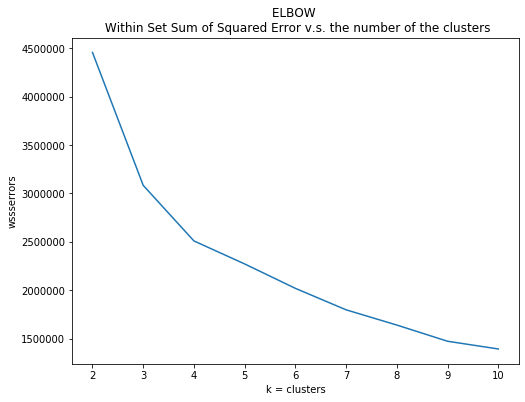

In [65]:
#Optimize choice of k in range (2,11)
wssserrors  = np.zeros(11)
for k in range(2,11):
    kmeansl = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell = kmeansl.fit(df_kmeansl.sample(False,0.1, seed=42))
    wssserrors [k] = modell.computeCost(df_kmeansl)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors[k]))
#plot
#from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('wssserrors')

plt.show()
    

####  we could choose k = 3 or k = 4 .

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4454671.741077537
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3083603.2842093217
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2511761.194926291
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2192872.122136489
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1969400.3598861299
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1815833.9063382577
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1628612.8259507094
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1564659.1297830434
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1388853.560314544


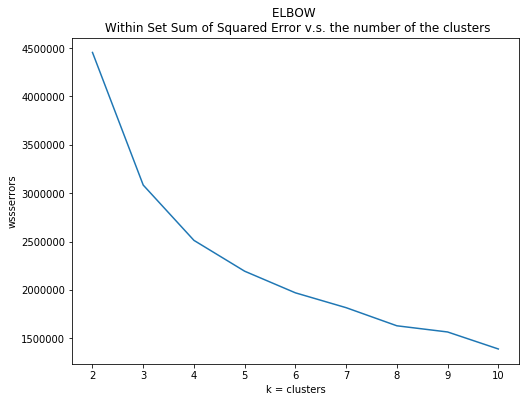

In [66]:
#Optimize choice of k in range (2,11)
wssserrors1  = np.zeros(11)
for k in range(2,11):
    kmeansl = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell = kmeansl.fit(df_kmeansl.sample(False,0.1, seed=650))
    wssserrors1 [k] = modell.computeCost(df_kmeansl)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors1[k]))
#plot
#from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors1[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('wssserrors')

plt.show()       

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4454568.282479256
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3083428.8392420644
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2510130.8778336616
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2272302.2358546946
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1984616.064694492
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1800396.0862602429
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1630576.7879119713
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1472629.7640024552
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1399872.6228054366


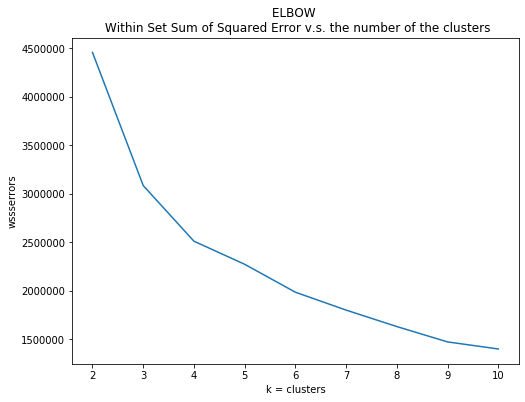

In [70]:
#Optimize choice of k in range (2,11)
wssserrors2  = np.zeros(11)
for k in range(2,11):
    kmeansl = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell = kmeansl.fit(df_kmeansl.sample(False,0.1, seed=10))
    wssserrors2 [k] = modell.computeCost(df_kmeansl)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors2[k]))
#plot
#from matplotlib.ticker import MaxNLocator
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors2[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('wssserrors')

plt.show()       

# Silhouette analysis

The Silhouette_cost for 2 clusters is: 0.5451089140684688
The Silhouette_cost for 3 clusters is: 0.5923129418797436
The Silhouette_cost for 4 clusters is: 0.4890442453573015
The Silhouette_cost for 5 clusters is: 0.4537089954438726
The Silhouette_cost for 6 clusters is: 0.4922013521136424
The Silhouette_cost for 7 clusters is: 0.4272982347111157
The Silhouette_cost for 8 clusters is: 0.43710911331934366
The Silhouette_cost for 9 clusters is: 0.4515731100163521
The Silhouette_cost for 10 clusters is: 0.41945349251088443


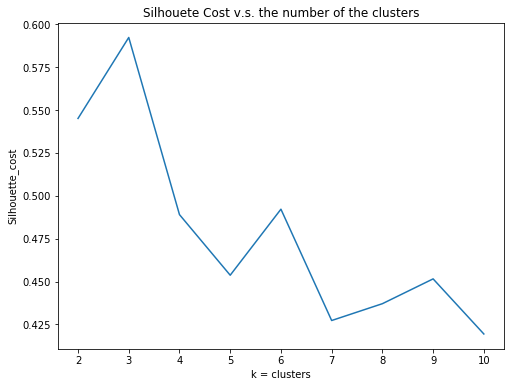

In [71]:
#Optimize choice of k in range (2,10]
evaluatorl = ClusteringEvaluator()
Silhouette_costl = np.zeros(11)

for k in range(2,11):
    kmeansll = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modelll = kmeansll.fit(df_kmeansl.sample(False,0.1, seed=42))     
    Silhouette_costl[k] = evaluatorl.evaluate(modelll.transform(df_kmeansl)) 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

The Silhouette_cost for 2 clusters is: 0.5461537068535157
The Silhouette_cost for 3 clusters is: 0.5925517011790805
The Silhouette_cost for 4 clusters is: 0.4932162011700966
The Silhouette_cost for 5 clusters is: 0.49466836859640995
The Silhouette_cost for 6 clusters is: 0.4195460502732909
The Silhouette_cost for 7 clusters is: 0.4355073284404946
The Silhouette_cost for 8 clusters is: 0.4289762126749511
The Silhouette_cost for 9 clusters is: 0.35530563778852386
The Silhouette_cost for 10 clusters is: 0.3938430296811887


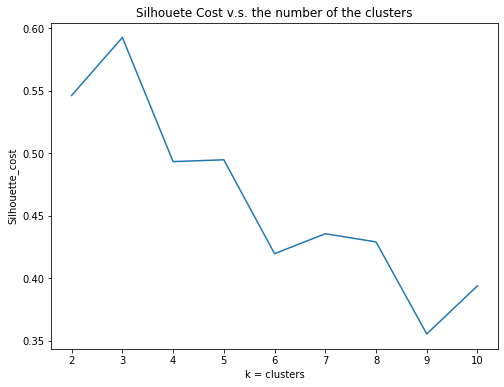

In [72]:
#Optimize choice of k in range (2,10]
evaluatorl = ClusteringEvaluator()
Silhouette_costl = np.zeros(11)

for k in range(2,11):
    kmeansll = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modelll = kmeansll.fit(df_kmeansl.sample(False,0.1, seed=650))      # Train a k-means model.
    Silhouette_costl[k] = evaluatorl.evaluate(modelll.transform(df_kmeansl)) #Evaluate clustering by computing Silhouette score
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

The Silhouette_cost for 2 clusters is: 0.5456113322331086
The Silhouette_cost for 3 clusters is: 0.5925968458262229
The Silhouette_cost for 4 clusters is: 0.48792132596586396
The Silhouette_cost for 5 clusters is: 0.4019504231300905
The Silhouette_cost for 6 clusters is: 0.47302723116867185
The Silhouette_cost for 7 clusters is: 0.4272752175979155
The Silhouette_cost for 8 clusters is: 0.43540607328289327
The Silhouette_cost for 9 clusters is: 0.4502152893277674
The Silhouette_cost for 10 clusters is: 0.4225584546221955


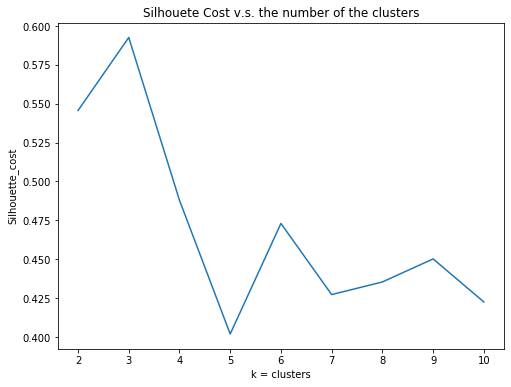

In [73]:
#Optimize choice of k in range (2,10]
evaluatorl = ClusteringEvaluator()
Silhouette_costl = np.zeros(11)

for k in range(2,11):
    kmeansll = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modelll = kmeansll.fit(df_kmeansl.sample(False,0.1, seed=10))      
    Silhouette_costl[k] = evaluatorl.evaluate(modelll.transform(df_kmeansl)) 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

From Silhouete analysis the optimal number of clusters is k = 3 

Considering the above ( Elbow and Sillhouette) I would say that k=3 or k=4 (from elbow) is the optimal number of clusters. 

### a)  For k=3: 

### Cluster centers- Understanding and labeling the components

The middle of a cluster. A centroid is a vector that contains one number for each variable, where each number is the mean of a variable for the observations in that cluster. The centroid can be thought of as the multi-dimensional average of the cluster.With the best seed=10

In [273]:
def cluster_centers_6f(df,n_cluster,feat_col_vect):
    kmeansl = KMeans().setK(n_cluster).setSeed(1).setFeaturesCol(feat_col_vect)
    modelmoul = kmeansl.fit(df.sample(False,0.1, seed=10))
    centersl = modelmoul.clusterCenters()
    #convert to df
    centersl_pd=pd.DataFrame(centersl)
    #rename the columns
    centersl_pd=centersl_pd.rename(columns={0: "countt",
                                            1: "recency",
                                            2: "frequency",
                                            3: "max_dist",
                                            4: "average_trans_dur",
                                            5: "start_trans_end_data"})

    #Take the transpose of the dataframe
    transpose_dfl=centersl_pd.T
    if n_cluster==3:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3"})
        
    elif n_cluster==4:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3",
                                                    3: "cluster_4"})
    elif n_cluster==5:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3",
                                                    3: "cluster_4",
                                                    4: "cluster_5"})
                
        
    print('\nCluster Centers for the '+ str(n_cluster)+' clusters: \n'),
    return transpose_dfl

In [274]:
#apply the function
clustercentr1dok3=cluster_centers_6f(df_kmeansl,3,"features")
clustercentr1dok3


Cluster Centers for the 3 clusters: 



,cluster_1,cluster_2,cluster_3
countt,0.722758,-0.844829,-0.810300
recency,-0.569421,0.231495,0.835314
frequency,0.789501,-1.054341,-0.826857
max_dist,-0.170438,-1.322152,0.893738
average_trans_dur,-0.485436,-0.761470,1.160979
start_trans_end_data,0.449523,-1.796228,0.077843


## characterize the clusters 
we can just use the cluster centroids to characterize the clusters. The centroid of a cluster is literally the average representation of all the cluster elements. So not only are these are the natural output of k-means clustering, but they're also relatively intuitive

### TRansformation to the original data-inverse-standardization

#### (use of the type : stand_value * std(column) + mean(column)=originate_value)

#### Take the statistics for the mean and stdev for the log features 

In [276]:
pd_freq_equp2_log_subset=pd_freq_equp2_log.loc[:,['ln(countt+1)','ln(recency+1)','ln(frequency+1)','ln(max_dist+1)','ln(average_trans_dur+1)','ln(start_trans_end_data+1)']]
descr=pd_freq_equp2_log_subset.describe()
descr=descr.iloc[[1,2],:]
descr=descr.apply(pd.to_numeric) # convert all columns of DataFramedescr
descr

,ln(countt+1),ln(recency+1),ln(frequency+1),ln(max_dist+1),ln(average_trans_dur+1),ln(start_trans_end_data+1)
mean,5.738209,2.572989,3.365518,3.741561,2.345498,5.803229
std,2.118451,1.711666,1.345105,0.977249,0.906184,0.797652


In [277]:
# def to return to the original type from log
def originale(df,cluster_num,table_stat):
    d=np.zeros((len(df),len(df.columns)))
    for i in range(len(df)):
        for j in range(len(df.columns)):
            d[i,j]=(np.exp(df.iloc[i,j]*table_stat.iloc[1,i]+table_stat.iloc[0,i]))-1
                
    pd_df=pd.DataFrame(d)
    if cluster_num==3:
        pd_df=pd_df.rename(columns={0: "original_cluster_1", 1: "original_cluster_2",2: "original_cluster_3"})
    elif cluster_num==4:
        pd_df=pd_df.rename(columns={0: "original_cluster_1", 1: "original_cluster_2",2: "original_cluster_3",3:"original_cluster_4"})
    df=df.reset_index()    
    concaten=pd.concat([df,pd_df],axis=1,)
    concaten=concaten.set_index('index')

    return concaten


In [278]:
#apply the function
threeclustercent=originale(clustercentr1dok3,3,descr)
threeclustercent

,cluster_1,cluster_2,cluster_3,original_cluster_1,original_cluster_2,original_cluster_3
index,,,,,,
countt,0.722758,-0.844829,-0.810300,1434.598217,50.856544,54.791891
recency,-0.569421,0.231495,0.835314,3.944767,18.476940,53.749448
frequency,0.789501,-1.054341,-0.826857,82.720093,6.009860,8.519169
max_dist,-0.170438,-1.322152,0.893738,34.694663,10.582432,99.984416
average_trans_dur,-0.485436,-0.761470,1.160979,5.723461,4.235516,28.891031
start_trans_end_data,0.449523,-1.796228,0.077843,473.277029,78.080378,351.595002


## Question:
##### Is it the higher the value the more influence on the cluster or similar?
No. In most cases, the range of the value does not have anything to do with the importance or influence of this attribute for the cluster (with the exception of tfidf like features like in text clustering etc.). It is just the location of the cluster centroid in the corresponding dimension.

### Assign clusters to events

In [309]:
kmeansl = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
modelmoul = kmeansl.fit(df_kmeansl.sample(False,0.1, seed=10))
transformeddaatl=modelmoul.transform(df_kmeansl).select('client_username_s', 'prediction')
rowsl = transformeddaatl.collect()
df_predictionsl=spark.createDataFrame(rowsl)
#join the prediction spark with the initial spark datafarame with the features.
pred_clustl = freq_equp2.join(df_predictionsl, 'client_username_s', 'inner')

In [310]:
#get the mean of features for each cluster
p_meanl = pred_clustl.groupBy('prediction').mean()
#convert to pandas
pd_meanl = p_meanl.toPandas()
c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh13=pred_clustl.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clustl.groupBy('prediction').agg(stddev(value))
    join1 =dokimh13.join(a, dokimh13.prediction == a.prediction).drop(dokimh13.prediction) #drop dublicate
    dokimh13=join1
pd_stdev=dokimh13.toPandas()
pd_meanl

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,1786.527606,12.235753,98.417425,44.554131,6.640074,492.304377,504.540130,0.0
1,1,179.627730,59.746936,9.907111,15.063501,5.606204,42.091434,101.838371,1.0
2,2,175.429153,93.703988,11.902230,113.664843,33.025752,298.901882,392.605869,2.0


In [311]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev=pd_stdev[pd_stdev.columns[new_order]]

In [312]:
pd_stdev.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1091.617633,30.676313,56.111176,37.218842,4.176632,146.994673,144.920272
1,1,290.571009,76.237443,12.005117,12.035240,4.632228,38.993970,67.336318
2,2,215.979595,80.693833,10.145968,56.028668,16.948766,178.431167,163.082837


In [313]:
#Get the number of clients belonged to each cluster
numb1=pred_clustl.groupBy('prediction').count()
numb_perc_1=numb1.withColumn("percentage_of_total",(numb1["count"]/1218752)*100)
#numb_perc_1=numb_perc_1.withColumn("percentage_of_total",func.round(numb_perc_1["percentage_of_total"],2))
numb_perc_1.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|648488|  53.20918447723572|
|         1|179429| 14.722355327416897|
|         2|390835|  32.06846019534737|
+----------+------+-------------------+



##### It seems that with k = 3 there are well separated clusters.

## b) For k = 4

#### Cluster centers- Understanding and labeling the components

In [314]:
#apply the function cluster_centers
clustercentr1dok4=cluster_centers_6f(df_kmeansl,4,"features")
clustercentr1dok4


Cluster Centers for the 4 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4
countt,0.842155,-0.827902,0.232041,-1.352206
recency,-0.785062,0.220180,0.185377,1.061675
frequency,0.971148,-1.060661,0.081284,-1.224207
max_dist,-0.446112,-1.375102,0.664818,0.842317
average_trans_dur,-0.730230,-0.812181,0.400974,1.372443
start_trans_end_data,0.417991,-1.841029,0.456189,-0.180091


### TRansformation to the original data-inverse-standardization
### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [315]:
#apply the function
concatenation4=originale(clustercentr1dok4,4,descr)
concatenation4

,cluster_1,cluster_2,cluster_3,cluster_4,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4
index,,,,,,,,
countt,0.842155,-0.827902,0.232041,-1.352206,1847.764410,52.749809,506.641961,16.701096
recency,-0.785062,0.220180,0.185377,1.061675,2.418578,18.103348,16.998559,79.658366
frequency,0.971148,-1.060661,0.081284,-1.224207,105.891474,5.950528,31.293087,4.578001
max_dist,-0.446112,-1.375102,0.664818,0.842317,26.264855,9.998337,79.741629,95.035142
average_trans_dur,-0.730230,-0.812181,0.400974,1.372443,4.385848,4.000371,14.012065,35.204514
start_trans_end_data,0.417991,-1.841029,0.456189,-0.180091,461.497120,75.304261,475.805518,286.027716


## Assign clusters to events

In [317]:
kmeansl = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
modelmoul4 = kmeansl.fit(df_kmeansl.sample(False,0.1, seed=10))
transformeddaatl4=modelmoul4.transform(df_kmeansl).select('client_username_s', 'prediction')
rowsl4 = transformeddaatl4.collect()
df_predictionsl4=spark.createDataFrame(rowsl4)

#join the prediction spark with the initial spark datafarame with the features.
pred_clustl4 = freq_equp2.join(df_predictionsl4, 'client_username_s', 'inner')

In [318]:
#get the mean of features for each cluster
p_meanl4 = pred_clustl4.groupBy('prediction').mean()
#convert to pandas
pd_meanl4 = p_meanl4.toPandas()
c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh14=pred_clustl4.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clustl4.groupBy('prediction').agg(stddev(value))
    join1 =dokimh14.join(a, dokimh14.prediction == a.prediction).drop(dokimh14.prediction) #drop dublicate
    dokimh14=join1
pd_stdev14=dokimh14.toPandas()
pd_meanl4

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,2143.593482,6.099407,118.259237,31.437538,4.782369,492.744206,498.843612,0.0
1,1,172.562055,58.914439,9.498098,14.183767,5.211443,40.225408,99.139847,1.0
2,3,45.834202,117.750779,5.457842,110.921304,39.336853,208.295945,326.046724,3.0
3,2,662.680502,40.206939,36.749155,92.765369,16.046360,458.300810,498.507748,2.0


In [319]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev14=pd_stdev14[pd_stdev14.columns[new_order]]
pd_stdev14.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev14

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1065.213105,19.144728,53.448306,22.957012,2.239128,155.822361,154.847076
1,1,265.701468,76.005430,10.945198,11.359694,4.190939,37.851723,67.092819
2,3,67.039836,82.086271,3.730727,57.852854,17.212190,149.291073,153.489894
3,2,471.920333,55.182976,22.186142,53.274233,9.176678,138.112365,131.495882


In [320]:
#Get the number of clients belonged to each cluster
numb2=pred_clustl4.groupBy('prediction').count()
numb_perc_14=numb2.withColumn("percentage_of_total",(numb2["count"]/1218752)*100)
numb_perc_14.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|461871|  37.89704550228431|
|         1|167190| 13.718131334348579|
|         3|243748|  19.99980307724623|
|         2|345943| 28.385020086120882|
+----------+------+-------------------+



##### It seems that there are well separated clusters but due to the fact that sillhouette is very low, i will not consider it. 

# DOKIMH 2

## WORK AGAIN WITH LOG(features+1)

### pearson correlation ( countt , frequency ) = 0.89 = high correlation  => drop countt

## to sum up, drop diff_maxd_mind_days & countt

In [321]:
#Select specific columns-Subset of subset
stand_log_freq_equp2_subsubset=stand_log_freq_equp2_subset.select([c for c in stand_log_freq_equp2_subset.columns if c in ['client_username_s',
                                                                                         'ln(recency+1)_standardised',
                                                                                        'ln(frequency+1)_standardised',
                                                                                        'ln(max_dist+1)_standardised',
                                                                                        'ln(average_trans_dur+1)_standardised',
                                                                                        'ln(start_trans_end_data+1)_standardised']])
#stand_log_freq_equp2_subsubset.show()

In [322]:
#take only the numeric columns
FETURES_COLLSSN = ['ln(recency+1)_standardised','ln(frequency+1)_standardised','ln(max_dist+1)_standardised','ln(average_trans_dur+1)_standardised','ln(start_trans_end_data+1)_standardised']
#check the type
stand_log_freq_equp2_subsubset.dtypes

[('client_username_s', 'string'),
 ('ln(recency+1)_standardised', 'float'),
 ('ln(frequency+1)_standardised', 'float'),
 ('ln(max_dist+1)_standardised', 'float'),
 ('ln(average_trans_dur+1)_standardised', 'float'),
 ('ln(start_trans_end_data+1)_standardised', 'float')]

### assemble the features

In [323]:
#We need to store all features as an array of floats, and store this array as a column called "features". 
#Since we do no longer need the original columns we filter them out with a select statement.
vecAssembler = VectorAssembler(inputCols=FETURES_COLLSSN, outputCol="features")
df_kmeansl2dok = vecAssembler.transform(stand_log_freq_equp2_subsubset).select('client_username_s', 'features')
df_kmeansl2dok.show()

+--------------------+--------------------+
|   client_username_s|            features|
+--------------------+--------------------+
|-3076708436585629202|[1.49381339550018...|
|-1383360085895621481|[-1.0982526540756...|
|-4373917140025030743|[-0.2883433103561...|
|-1932624376972617513|[0.18542332947254...|
| 8138114728915753073|[0.03859888762235...|
| 3238105438798080237|[-1.5032073259353...|
| 6715359518456271901|[-0.1022942885756...|
|-5699689628182849411|[-0.8613693714141...|
| 3738582637858980585|[0.21701075136661...|
| 1928064594810315272|[-0.6932979822158...|
|-8064344582484646647|[0.27548220753669...|
|-2537030807470187043|[1.60947704315185...|
|-4025425347570620616|[-1.5032073259353...|
|-5436079748649137911|[0.77049565315246...|
| 4855070875121257943|[-1.5032073259353...|
|-6610127114434328374|[-1.5032073259353...|
| 7268818881845104395|[-0.3663558661937...|
|-7386970584471026200|[-1.5032073259353...|
| -545312463900702720|[-0.8613693714141...|
|-2552963121487109479|[-1.503207

## elbow

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 3910308.6440118207
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2553047.2899214006
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2146983.793790825
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 1891793.2576106093
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1716060.9703543507
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1504533.6282149265
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1389025.112234984
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1299340.317710731
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1155435.2616541903


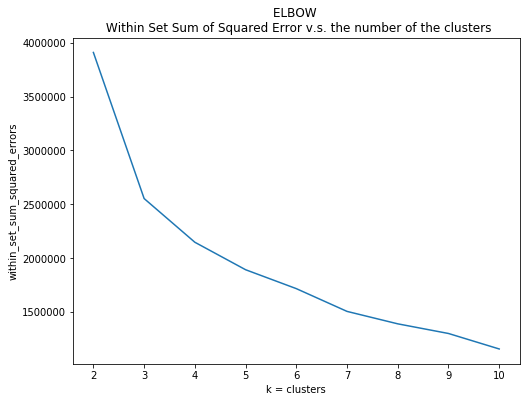

In [126]:
#Optimize choice of k in range (2,11)
wssserrors2dok  = np.zeros(11)
for k in range(2,11):
    kmeansl2dok = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell2dok = kmeansl2dok.fit(df_kmeansl2dok.sample(False,0.1, seed=42))
    wssserrors2dok [k] = modell2dok.computeCost(df_kmeansl2dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors2dok[k]))

#plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors2dok[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('within_set_sum_squared_errors')

plt.show()
    

k=3 

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4554897.977346965
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2552999.9431682616
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2147001.040456437
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 1964636.6919520213
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1714741.2763442653
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1499135.653067714
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1339629.7624809556
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1325416.018438383
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1161938.7016414914


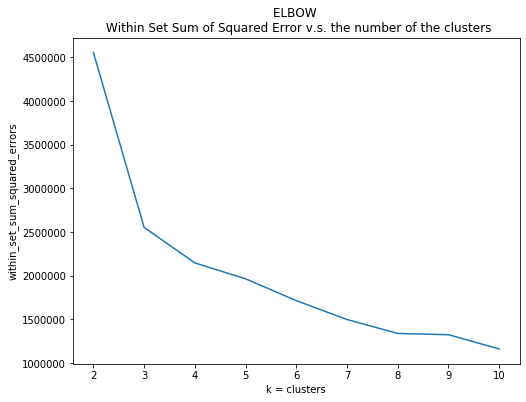

In [127]:
#Optimize choice of k in range (2,11)
wssserrors2dok  = np.zeros(11)
for k in range(2,11):
    kmeansl2dok = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell2dok = kmeansl2dok.fit(df_kmeansl2dok.sample(False,0.1, seed=500))
    wssserrors2dok [k] = modell2dok.computeCost(df_kmeansl2dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors2dok[k]))

#plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors2dok[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('within_set_sum_squared_errors')

plt.show()
    

k=3 or k=4

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 3910354.3816197095
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2552992.4059846792
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2146974.0193372522
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2023447.140093641
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1809495.3690154944
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1508536.7376295966
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1372879.0748598222
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1333647.2512439305
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1267513.9188606264


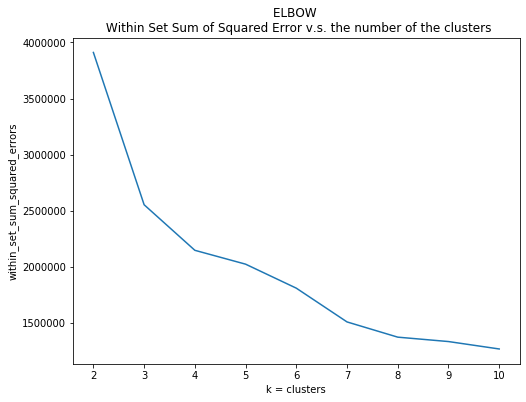

In [128]:
#Optimize choice of k in range (2,11)
wssserrors2dok  = np.zeros(11)
for k in range(2,11):
    kmeansl2dok = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    modell2dok = kmeansl2dok.fit(df_kmeansl2dok.sample(False,0.1, seed=10))
    wssserrors2dok [k] = modell2dok.computeCost(df_kmeansl2dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(wssserrors2dok[k]))

#plot
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),wssserrors2dok[2:11])
ax.set_title('ELBOW \n Within Set Sum of Squared Error v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('within_set_sum_squared_errors')

plt.show()
    

From the elbow we can observe that the graph is not so good as the previous one which connotes that there will not exist "clear" clusters. However, We can assume that optimal number of clusters is k = 3 or k = 4 

## Silhouette 

The Silhouette_cost for 2 clusters is: 0.4984220109241286
The Silhouette_cost for 3 clusters is: 0.5854094748160964
The Silhouette_cost for 4 clusters is: 0.4646490565704553
The Silhouette_cost for 5 clusters is: 0.4712804591730693
The Silhouette_cost for 6 clusters is: 0.4731061403778609
The Silhouette_cost for 7 clusters is: 0.4755935302797736
The Silhouette_cost for 8 clusters is: 0.429944893075106
The Silhouette_cost for 9 clusters is: 0.41435291629715887
The Silhouette_cost for 10 clusters is: 0.43803803725940194


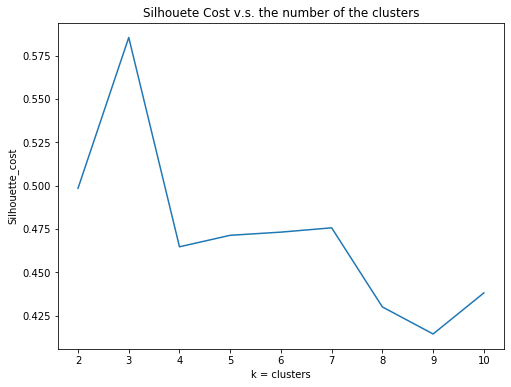

In [129]:
#Optimize choice of k in range (2,10]
evaluatorl2dok = ClusteringEvaluator()
Silhouette_costl2dok = np.zeros(11)

for k in range(2,11):
    kmeansl2doksil = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modell2doksil = kmeansl2doksil.fit(df_kmeansl2dok.sample(False,0.1, seed=42))     
    Silhouette_costl2dok[k] = evaluatorl2dok.evaluate(modell2doksil.transform(df_kmeansl2dok)) 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl2dok[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl2dok[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

k=3

The Silhouette_cost for 2 clusters is: 0.4901187486922415
The Silhouette_cost for 3 clusters is: 0.5854360293564463
The Silhouette_cost for 4 clusters is: 0.464871160142952
The Silhouette_cost for 5 clusters is: 0.4486795535788838
The Silhouette_cost for 6 clusters is: 0.470593877804685
The Silhouette_cost for 7 clusters is: 0.4728685109377317
The Silhouette_cost for 8 clusters is: 0.48622994711780415
The Silhouette_cost for 9 clusters is: 0.4194681775784062
The Silhouette_cost for 10 clusters is: 0.40718226455186113


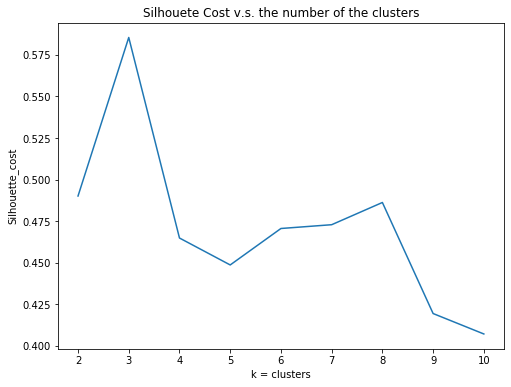

In [130]:
#Optimize choice of k in range (2,10]
evaluatorl2dok = ClusteringEvaluator()
Silhouette_costl2dok = np.zeros(11)

for k in range(2,11):
    kmeansl2doksil = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modell2doksil = kmeansl2doksil.fit(df_kmeansl2dok.sample(False,0.1, seed=500))     
    Silhouette_costl2dok[k] = evaluatorl2dok.evaluate(modell2doksil.transform(df_kmeansl2dok)) 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl2dok[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl2dok[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

k=3

The Silhouette_cost for 2 clusters is: 0.49802955660476506
The Silhouette_cost for 3 clusters is: 0.5854287694425186
The Silhouette_cost for 4 clusters is: 0.46437775975059875
The Silhouette_cost for 5 clusters is: 0.5203004065762133
The Silhouette_cost for 6 clusters is: 0.46458022357909234
The Silhouette_cost for 7 clusters is: 0.47328158861399505
The Silhouette_cost for 8 clusters is: 0.46202812763350215
The Silhouette_cost for 9 clusters is: 0.44032874280143935
The Silhouette_cost for 10 clusters is: 0.37171172100050626


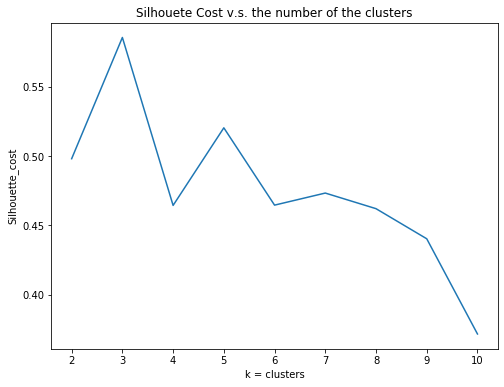

In [131]:
#Optimize choice of k in range (2,10]
evaluatorl2dok = ClusteringEvaluator()
Silhouette_costl2dok = np.zeros(11)

for k in range(2,11):
    kmeansl2doksil = KMeans().setK(k).setSeed(1).setFeaturesCol("features") 
    modell2doksil = kmeansl2doksil.fit(df_kmeansl2dok.sample(False,0.1, seed=10))      
    Silhouette_costl2dok[k] = evaluatorl2dok.evaluate(modell2doksil.transform(df_kmeansl2dok)) 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouette_costl2dok[k]))
#plot 
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouette_costl2dok[2:11])
ax.set_title('Silhouete Cost v.s. the number of the clusters')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouette_cost')

plt.show()    

#### From the silhouete we scan see that the things get even worse  as there is no good value for k so as to achieve high sillouete score. However, as optimal number of clusters we could take -test-  k=3

# a) k=3 :

### Cluster centers-Understanding and labeling the components


In [291]:
def cluster_centers_5f(df,n_cluster,feat_col_vekt):
    kmeansl = KMeans().setK(n_cluster).setSeed(1).setFeaturesCol(feat_col_vekt)
    modelmoul = kmeansl.fit(df.sample(False,0.1, seed=500))
    centersl = modelmoul.clusterCenters()
    #convert to df
    centersl_pd=pd.DataFrame(centersl)
    #rename the columns
    centersl_pd=centersl_pd.rename(columns={0: "recency",
                                            1: "frequency",
                                            2: "max_dist",
                                            3: "average_trans_dur",
                                            4: "start_trans_end_data"})

    #Take the transpose of the dataframe
    transpose_dfl=centersl_pd.T
    if n_cluster==3:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3"})
        
    elif n_cluster==4:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3",
                                                    3: "cluster_4"})
    elif n_cluster==5:
        #rename the columns
        transpose_dfl=transpose_dfl.rename(columns={0: "cluster_1",
                                                    1: "cluster_2",
                                                    2: "cluster_3",
                                                    3: "cluster_4",
                                                    4: "cluster_5"})        
        
    print('\nCluster Centers for the '+ str(n_cluster)+' clusters: \n'),
    return transpose_dfl

In [292]:
#apply the function
threeclustercen2dok=cluster_centers_5f(df_kmeansl2dok,3,"features")
threeclustercen2dok


Cluster Centers for the 3 clusters: 



,cluster_1,cluster_2,cluster_3
recency,-0.620051,0.794024,0.133723
frequency,0.841074,-0.740250,-0.928890
max_dist,-0.198441,0.866750,-1.314134
average_trans_dur,-0.523572,1.081987,-0.793922
start_trans_end_data,0.485464,0.115406,-1.747105


### TRansformation to the original data-inverse-standardization
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [293]:
kolonitses=['ln(recency+1)','ln(frequency+1)','ln(max_dist+1)','ln(average_trans_dur+1)','ln(start_trans_end_data+1)']
descrn=descr[kolonitses]
descrn

,ln(recency+1),ln(frequency+1),ln(max_dist+1),ln(average_trans_dur+1),ln(start_trans_end_data+1)
mean,2.572989,3.365518,3.741561,2.345498,5.803229
std,1.711666,1.345105,0.977249,0.906184,0.797652


In [294]:
#apply the function
threeeclustercentroids=originale(threeclustercen2dok,3,descrn)
threeeclustercentroids

,cluster_1,cluster_2,cluster_3,original_cluster_1,original_cluster_2,original_cluster_3
index,,,,,,
recency,-0.620051,0.794024,0.133723,3.534289,50.013658,15.475573
frequency,0.841074,-0.740250,-0.928890,88.734044,9.695297,7.298407
max_dist,-0.198441,0.866750,-1.314134,33.731065,97.355866,10.673543
average_trans_dur,-0.523572,1.081987,-0.793922,5.495080,26.826177,4.083796
start_trans_end_data,0.485464,0.115406,-1.747105,487.070499,362.319486,81.240450


## Assign clusters to events

In [295]:
kmeansl = KMeans().setK(3).setSeed(1).setFeaturesCol("features")
model2dok3 = kmeansl.fit(df_kmeansl2dok.sample(False,0.1, seed=500))
trans2dok3=model2dok3.transform(df_kmeansl2dok).select('client_username_s', 'prediction')
rows2dok3 = trans2dok3.collect()
df_predictions2dok3=spark.createDataFrame(rows2dok3)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust2dok3 = freq_equp2.join(df_predictions2dok3, 'client_username_s', 'inner')

In [296]:
#get the mean of features for each cluster
p_mean2dok3= pred_clust2dok3.groupBy('prediction').mean()
#convert to pandas
p_mean2dok3 =p_mean2dok3.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh23=pred_clust2dok3.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust2dok3.groupBy('prediction').agg(stddev(value))
    join1 =dokimh23.join(a, dokimh23.prediction == a.prediction).drop(dokimh23.prediction) #drop dublicate
    dokimh23=join1
pd_stdev23=dokimh23.toPandas()
p_mean2dok3

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,1869.053995,10.476990,103.617496,42.484188,6.258052,502.625064,513.102054,0.0
1,1,230.632657,89.326817,14.116900,111.248216,31.283697,314.321560,403.648377,1.0
2,2,252.506586,54.738463,13.296935,14.999500,5.372465,49.585324,104.323787,2.0


In [297]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev23=pd_stdev23[pd_stdev23.columns[new_order]]
pd_stdev23.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev23

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1094.581056,27.874490,55.506529,34.709506,3.676361,137.928843,135.582606
1,1,288.587145,80.033809,12.664478,55.920075,17.126910,182.139291,163.815719
2,2,416.428457,74.278057,17.401841,11.865700,4.479190,45.207272,65.533186


In [298]:
#Get the number of clients belonged to each cluster
numb3=pred_clust2dok3.groupBy('prediction').count()
numb_perc_23=numb3.withColumn("percentage_of_total",(numb3["count"]/1218752)*100)
numb_perc_23.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|594478|  48.77760200598645|
|         1|430137|  35.29323439058972|
|         2|194137| 15.929163603423829|
+----------+------+-------------------+



# There are well separated clusters

# b) k= 4

## Cluster centers-Understanding and labeling the components

In [140]:
#apply the function
fourclustercen_5f=cluster_centers_5f(df_kmeansl2dok,4,"features")
fourclustercen_5f


Cluster Centers for the 4 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4
recency,0.022856,-0.838722,1.001017,0.200183
frequency,0.255214,1.019413,-1.066951,-0.996181
max_dist,0.529955,-0.493604,0.909785,-1.327457
average_trans_dur,0.199962,-0.771915,1.332274,-0.789540
start_trans_end_data,0.485226,0.440975,-0.043043,-1.769296


### TRansformation to the original data-inverse-standardization
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [141]:
#apply the function
fiveclusterscentroids2dok4=originale(fourclustercen_5f,4,descrn)
fiveclusterscentroids2dok4

,cluster_1,cluster_2,cluster_3,cluster_4,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4
index,,,,,,,,
recency,0.022856,-0.838722,1.001017,0.200183,12.627779,2.118576,71.703970,17.460523
frequency,0.255214,1.019413,-1.066951,-0.996181,39.805132,113.061179,5.891965,6.580279
max_dist,0.529955,-0.493604,0.909785,-1.327457,69.771692,25.028364,101.580437,10.522534
average_trans_dur,0.199962,-0.771915,1.332274,-0.789540,11.512150,4.186196,33.910354,4.104024
start_trans_end_data,0.485226,0.440975,-0.043043,-1.769296,486.977984,470.054384,319.183945,79.797598


## Assign clusters to events

In [324]:
kmeansl = KMeans().setK(4).setSeed(1).setFeaturesCol("features")
model2dok4 = kmeansl.fit(df_kmeansl2dok.sample(False,0.1, seed=10))
trans2dok4=model2dok4.transform(df_kmeansl2dok).select('client_username_s', 'prediction')
rows2dok4 = trans2dok4.collect()
df_predictions2dok4=spark.createDataFrame(rows2dok4)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust2dok4 = freq_equp2.join(df_predictions2dok4, 'client_username_s', 'inner')

In [325]:
#get the mean of features for each cluster
p_mean2dok4= pred_clust2dok4.groupBy('prediction').mean()
#convert to pandas
p_mean2dok4 =p_mean2dok4.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh24=pred_clust2dok4.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust2dok4.groupBy('prediction').agg(stddev(value))
    join1 =dokimh24.join(a, dokimh24.prediction == a.prediction).drop(dokimh24.prediction) #drop dublicate
    dokimh24=join1
pd_stdev24=dokimh24.toPandas()

p_mean2dok4

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,2247.217043,4.857021,125.192185,28.720543,4.476762,498.033950,502.890971,0.0
1,1,100.502405,109.231044,7.408333,115.925951,37.620948,250.730447,359.961491,1.0
2,3,214.687199,57.142414,11.272425,14.870846,5.394379,45.375433,102.517847,3.0
3,2,848.939939,31.251209,46.363230,81.623044,12.801069,477.676259,508.927467,2.0


In [326]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev24=pd_stdev24[pd_stdev24.columns[new_order]]
pd_stdev24.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev24

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1072.077555,16.054063,52.607753,18.665170,1.930203,150.931021,150.019697
1,1,141.714230,81.017492,5.477478,57.265329,16.590142,165.684818,160.557524
2,3,345.632855,75.338119,13.766174,11.707451,4.420932,41.775044,66.374049
3,2,589.298592,49.143698,26.363788,49.024472,6.624045,133.208414,126.241152


In [327]:
#Get the number of clients belonged to each cluster
numb4=pred_clust2dok4.groupBy('prediction').count()
numb_perc_24=numb4.withColumn("percentage_of_total",(numb4["count"]/1218752)*100)
numb_perc_24.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|402445| 33.021074016699046|
|         1|295467| 24.243406369794677|
|         3|184315| 15.123257233629156|
|         2|336525| 27.612262379877123|
+----------+------+-------------------+



## There are well separated clusters again but the silhouette is very low, so I will not consider it.

# DOKIMH 3

# Normalisation-Standardisation iniatial data  without log

### drop FEATURE   diff_maxd_mind_days

In [328]:
#standardise data
columns=['countt','recency','frequency','max_dist','average_trans_dur','start_trans_end_data']
scalinitial=standardize_data(freq_equp2_log,columns)
#scaleddfsubset.show()

In [329]:
#Select specific columns-Subset of subset
scalinitial_sub=scalinitial.select([c for c in scalinitial.columns if c in ['client_username_s',
                                                                                         'countt_standardised',
                                                                                         'recency_standardised',
                                                                                        'frequency_standardised',
                                                                                        'max_dist_standardised',
                                                                                        'average_trans_dur_standardised',
                                                                                        'start_trans_end_data_standardised']])
#scalinitial_sub.show()

In [330]:
#convert to float all the features from double
FETURES_COLLSSN = ['countt_standardised','recency_standardised','frequency_standardised','max_dist_standardised','average_trans_dur_standardised','start_trans_end_data_standardised']
for col in scalinitial_sub.columns:
    if col in FETURES_COLLSSN:
        scalinitial_sub = scalinitial_sub.withColumn(col,scalinitial_sub[col].cast('float'))
#scalinitial_sub.show()

#assess the type of features
scalinitial_sub.dtypes

[('client_username_s', 'string'),
 ('countt_standardised', 'float'),
 ('recency_standardised', 'float'),
 ('frequency_standardised', 'float'),
 ('max_dist_standardised', 'float'),
 ('average_trans_dur_standardised', 'float'),
 ('start_trans_end_data_standardised', 'float')]

### assemble my features

Spark ML requires our input features to be gathered in a single column of our dataframe, usually named features.

In [331]:
#We need to store all features as an array of floats, and store this array as a column called "fetures".
#Since we do no longer need the original columns we filter them out with a select statement.
vecAssembler_stand= VectorAssembler(inputCols=FETURES_COLLSSN, outputCol="fetures")
df_kmeans_scalinit=vecAssembler_stand.transform(scalinitial_sub).select('client_username_s', 'fetures')
df_kmeans_scalinit.show()

+--------------------+--------------------+
|   client_username_s|             fetures|
+--------------------+--------------------+
|-3076708436585629202|[-0.8707199692726...|
|-1383360085895621481|[1.44670999050140...|
|-4373917140025030743|[-0.5986471772193...|
|-1932624376972617513|[-0.8899662494659...|
| 8138114728915753073|[1.06440842151641...|
| 3238105438798080237|[0.05397745594382...|
| 6715359518456271901|[0.03473115339875...|
|-5699689628182849411|[1.83950948715209...|
| 3738582637858980585|[0.61474478244781...|
| 1928064594810315272|[0.23419284820556...|
|-8064344582484646647|[-0.6283915042877...|
|-2537030807470187043|[-0.8794682621955...|
|-4025425347570620616|[1.76164948940277...|
|-5436079748649137911|[0.90868830680847...|
| 4855070875121257943|[0.57362765073776...|
|-6610127114434328374|[2.42914628982543...|
| 7268818881845104395|[0.48876896500587...|
|-7386970584471026200|[1.02591574192047...|
| -545312463900702720|[0.19570024311542...|
|-2552963121487109479|[0.0102358

## Fit the data(standardised data)

## elbow analysis

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4707331.928836011
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3301286.994453076
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2607363.3667911678
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2115456.0288825883
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1959481.5025358773
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1732820.9686271
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1556777.6742793876
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1457645.4585930153
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1352851.9883536235


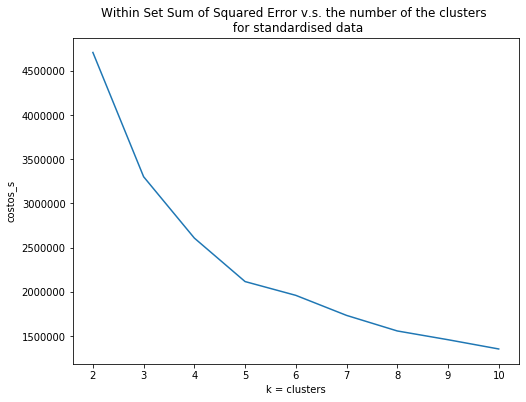

In [150]:
#Optimize choice of k in range (2,11)
costos_s = np.zeros(11)
for k in range(2,11):
    kmeans_stinit= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit = kmeans_stinit.fit(df_kmeans_scalinit.sample(False,0.1, seed=42))
    costos_s[k] = model_scalinit.computeCost(df_kmeans_scalinit)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s')


plt.show()    

From the elbow analysis we could come to the result that the optimal number of clusters is k = 3  or k =4 or k = 5

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4707302.003469522
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3301303.111992715
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2778589.1695032613
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2115516.009985872
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1847632.7989351472
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1690798.4164061476
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1558073.5716590518
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1424509.9438903579
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1354656.6590325478


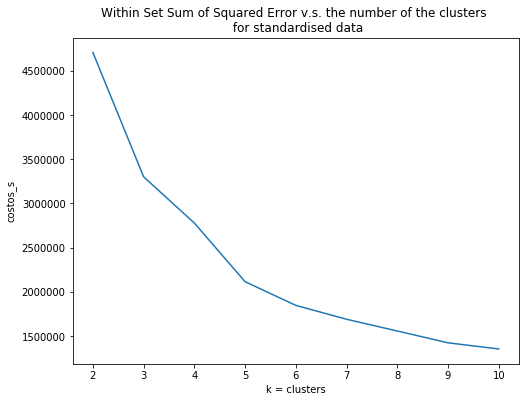

In [151]:
#Optimize choice of k in range (2,11)
costos_s = np.zeros(11)
for k in range(2,11):
    kmeans_stinit= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit = kmeans_stinit.fit(df_kmeans_scalinit.sample(False,0.1, seed=346))
    costos_s[k] = model_scalinit.computeCost(df_kmeans_scalinit)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s')


plt.show()    

k=3 or k=5

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4707387.196020151
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 3301331.7485316265
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2607507.6995423846
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 2115514.627818303
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1855979.0546891824
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1702050.851481136
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1593841.4043617232
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1424476.2547966444
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1328698.5889759636


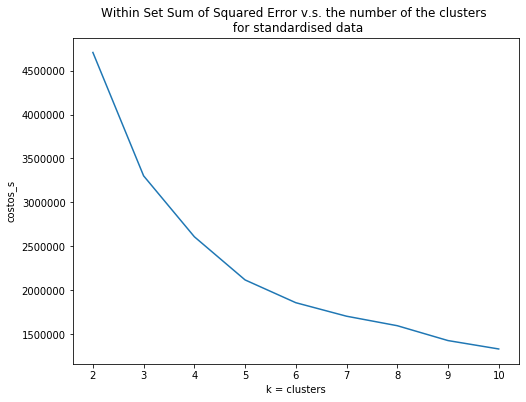

In [152]:
#Optimize choice of k in range (2,11)
costos_s = np.zeros(11)
for k in range(2,11):
    kmeans_stinit= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit = kmeans_stinit.fit(df_kmeans_scalinit.sample(False,0.1, seed=12))
    costos_s[k] = model_scalinit.computeCost(df_kmeans_scalinit)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s')


plt.show()    

k=3 or k=4 or k=5

## Silhouette analysis

The Silhouette_cost for 2 clusters is: 0.46773271056725946
The Silhouette_cost for 3 clusters is: 0.5322784946745444
The Silhouette_cost for 4 clusters is: 0.49799239104764403
The Silhouette_cost for 5 clusters is: 0.5316357685130765
The Silhouette_cost for 6 clusters is: 0.49927813516231373
The Silhouette_cost for 7 clusters is: 0.46131598508619936
The Silhouette_cost for 8 clusters is: 0.48509191298057786
The Silhouette_cost for 9 clusters is: 0.4549738321641604
The Silhouette_cost for 10 clusters is: 0.42946419517691053


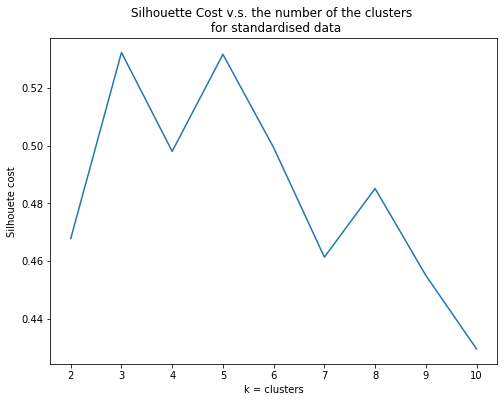

In [153]:
#Optimize choice of k in range (2,10]
evalsil3dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost3dok = np.zeros(11)

for k in range(2,11):
    kmeans_3dok= KMeans(featuresCol = "fetures", k=k).setSeed(1)
    model_3dok = kmeans_3dok.fit(df_kmeans_scalinit.sample(False,0.1, seed=42))
    prs = model_3dok.transform(df_kmeans_scalinit)
    
    Silhouete_cost3dok[k] = evalsil3dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost3dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost3dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

k=3 or k=5

The Silhouette_cost for 2 clusters is: 0.4676189175161663
The Silhouette_cost for 3 clusters is: 0.5321164698556343
The Silhouette_cost for 4 clusters is: 0.5327619107350131
The Silhouette_cost for 5 clusters is: 0.5317461803089011
The Silhouette_cost for 6 clusters is: 0.5090568763397291
The Silhouette_cost for 7 clusters is: 0.4975818019745874
The Silhouette_cost for 8 clusters is: 0.4607674589722039
The Silhouette_cost for 9 clusters is: 0.45928078826461094
The Silhouette_cost for 10 clusters is: 0.45971142650702285


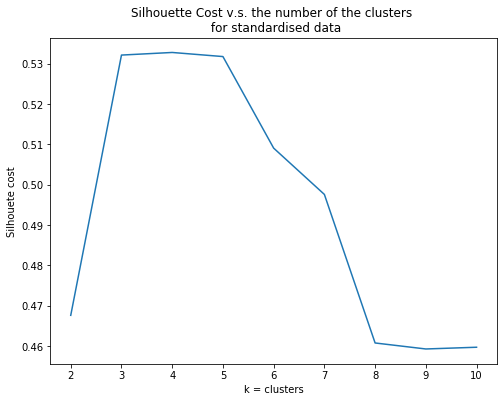

In [332]:
#Optimize choice of k in range (2,10]
evalsil3dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost3dok = np.zeros(11)

for k in range(2,11):
    kmeans_3dok= KMeans(featuresCol = "fetures", k=k).setSeed(1)
    model_3dok = kmeans_3dok.fit(df_kmeans_scalinit.sample(False,0.1, seed=346))
    prs = model_3dok.transform(df_kmeans_scalinit)
    
    Silhouete_cost3dok[k] = evalsil3dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost3dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost3dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

Using the Silhouete evaluator in standardised data , the optimal number of clusters is k = 3 or k=4 or k= 5

The Silhouette_cost for 2 clusters is: 0.4678392666810029
The Silhouette_cost for 3 clusters is: 0.5320225573197085
The Silhouette_cost for 4 clusters is: 0.49904776689086283
The Silhouette_cost for 5 clusters is: 0.5318796300423076
The Silhouette_cost for 6 clusters is: 0.49586368982501117
The Silhouette_cost for 7 clusters is: 0.46563044490440636
The Silhouette_cost for 8 clusters is: 0.43573432407400436
The Silhouette_cost for 9 clusters is: 0.46257418405842277
The Silhouette_cost for 10 clusters is: 0.456469634645526


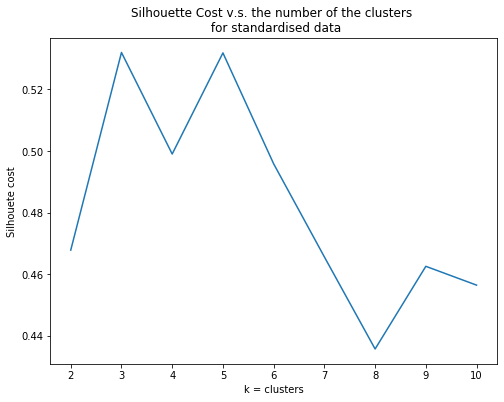

In [333]:
#Optimize choice of k in range (2,10]
evalsil3dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost3dok = np.zeros(11)

for k in range(2,11):
    kmeans_3dok= KMeans(featuresCol = "fetures", k=k).setSeed(1)
    model_3dok = kmeans_3dok.fit(df_kmeans_scalinit.sample(False,0.1, seed=12))
    prs = model_3dok.transform(df_kmeans_scalinit)
    
    Silhouete_cost3dok[k] = evalsil3dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost3dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost3dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

k=3 or k=5

# a) k=3

### clusters_cenders-Understanding and labeling the components

In [334]:
#apply the function for cluster centers
threeclustcent3dok=cluster_centers_6f(df_kmeans_scalinit,3,"fetures")
threeclustcent3dok


Cluster Centers for the 3 clusters: 



,cluster_1,cluster_2,cluster_3
countt,0.928644,-0.615070,-0.684783
recency,-0.506059,0.127210,0.600129
frequency,0.935118,-0.620833,-0.689173
max_dist,-0.402228,-0.566682,1.270578
average_trans_dur,-0.544417,-0.365272,1.246545
start_trans_end_data,0.740665,-1.170939,0.243147


### TRansformation to the original data-inverse-standardization
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [335]:
mean_stdev=pd__freq_equp2.describe().iloc[[1,2],:7]
mean_stdev=mean_stdev.drop(columns='diff_maxd_mind_days')
mean_stdev

,countt,recency,frequency,max_dist,average_trans_dur,start_trans_end_data
mean,1033.299438,45.356121,57.642532,62.375145,14.949348,409.357330
std,1143.076660,69.341972,60.171055,55.742538,16.091497,198.001587


In [336]:
# def to return to the original type from log
def originale_no_log(df,cluster_num,table_stat):
    d=np.zeros((len(df),len(df.columns)))
    for i in range(len(df)):
        for j in range(len(df.columns)):
            d[i,j]=df.iloc[i,j]*table_stat.iloc[1,i]+table_stat.iloc[0,i]
                
    pd_df=pd.DataFrame(d)
    if cluster_num==3:
        pd_df=pd_df.rename(columns={0: "original_cluster_1", 1: "original_cluster_2",2: "original_cluster_3"})
    elif cluster_num==4:
        pd_df=pd_df.rename(columns={0: "original_cluster_1", 1: "original_cluster_2",2: "original_cluster_3",3:"original_cluster_4"})
    elif cluster_num==5:
        pd_df=pd_df.rename(columns={0: "original_cluster_1", 1: "original_cluster_2",2: "original_cluster_3",3:"original_cluster_4",4:"original_cluster_5"})
    df=df.reset_index()    
    concaten=pd.concat([df,pd_df],axis=1,)
    concaten=concaten.set_index('index')

    return concaten


In [337]:
#apply the function 
threeclustercentroid3dok=originale_no_log(threeclustcent3dok,3,mean_stdev)
threeclustercentroid3dok

,cluster_1,cluster_2,cluster_3,original_cluster_1,original_cluster_2,original_cluster_3
index,,,,,,
countt,0.928644,-0.615070,-0.684783,2094.810994,330.226891,250.539528
recency,-0.506059,0.127210,0.600129,10.265001,54.177139,86.970258
frequency,0.935118,-0.620833,-0.689173,113.909562,20.286351,16.174266
max_dist,-0.402228,-0.566682,1.270578,39.953936,30.786856,133.200391
average_trans_dur,-0.544417,-0.365272,1.246545,6.188869,9.071572,35.008123
start_trans_end_data,0.740665,-1.170939,0.243147,556.010116,177.509472,457.500900


## Assign clusters to events

In [338]:
#for k=3 clusters
kmeansl = KMeans().setK(3).setSeed(1).setFeaturesCol("fetures")
model3dok3 = kmeansl.fit(df_kmeans_scalinit.sample(False,0.1, seed=42))
trans_3dok3=model3dok3.transform(df_kmeans_scalinit).select('client_username_s', 'prediction')
rows1s3dok3 = trans_3dok3.collect()
df_pred_for_std3dok3=spark.createDataFrame(rows1s3dok3)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust3dok3 = freq_equp2.join(df_pred_for_std3dok3, 'client_username_s', 'inner')

In [339]:
#get the mean of features for each cluster
p_mean3dok3 = pred_clust3dok3.groupBy('prediction').mean()
#convert to pandas
pd_p_mean3dok3 = p_mean3dok3.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh33=pred_clust3dok3.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust3dok3.groupBy('prediction').agg(stddev(value))
    join1 =dokimh33.join(a, dokimh33.prediction == a.prediction).drop(dokimh33.prediction) #drop dublicate
    dokimh33=join1
pd_stdev33=dokimh33.toPandas()
pd_p_mean3dok3

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,2092.159028,10.235393,113.841981,40.030675,6.211758,546.699288,556.934681,0.0
1,1,331.925150,54.680614,20.425996,30.874111,9.078212,123.662234,178.342849,1.0
2,2,250.509831,87.678181,16.084761,133.231256,35.091002,368.967303,456.645484,2.0


In [340]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev33=pd_stdev33[pd_stdev33.columns[new_order]]
pd_stdev33.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev33

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1044.685334,24.833669,53.980869,28.607346,3.656582,91.520973,89.639204
1,1,402.282962,73.197526,22.225339,24.368337,7.635809,114.476158,113.539804
2,2,293.409603,82.198288,14.794735,50.851090,17.461118,167.472111,139.500827


In [341]:
#Get the number of clients belonged to each cluster
numb5=pred_clust3dok3.groupBy('prediction').count()
numb_perc_33=numb5.withColumn("percentage_of_total",(numb5["count"]/1218752)*100)
numb_perc_33.show()


+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|500894| 41.098927427401144|
|         1|387588| 31.802040119729035|
|         2|330270|  27.09903245286982|
+----------+------+-------------------+



## There are well separated clusters

# b) k=4

### Cluster centers-Understanding and labeling the components

In [342]:
#apply the function for cluster centers
fourclustcent3dok=cluster_centers_6f(df_kmeans_scalinit,4,"fetures")
fourclustcent3dok


Cluster Centers for the 4 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4
countt,-0.778176,-0.561714,0.975997,-0.633477
recency,2.287217,-0.265055,-0.522631,0.097633
frequency,-0.761922,-0.568678,0.979616,-0.640745
max_dist,0.019427,-0.565239,-0.430164,1.386380
average_trans_dur,0.442777,-0.387069,-0.556425,1.187751
start_trans_end_data,-0.265977,-1.248286,0.753166,0.301356


#### TRansformation to the original data-inverse-standardization
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [343]:
#apply the function 
fourclustercentroid3dok=originale_no_log(fourclustcent3dok,4,mean_stdev)
fourclustercentroid3dok

,cluster_1,cluster_2,cluster_3,cluster_4,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4
index,,,,,,,,
countt,-0.778176,-0.561714,0.975997,-0.633477,143.784120,391.217515,2148.938548,309.187124
recency,2.287217,-0.265055,-0.522631,0.097633,203.956293,26.976662,9.115869,52.126214
frequency,-0.761922,-0.568678,0.979616,-0.640745,11.796872,23.424597,116.587042,19.088234
max_dist,0.019427,-0.565239,-0.430164,1.386380,63.458032,30.867274,38.396732,139.655461
average_trans_dur,0.442777,-0.387069,-0.556425,1.187751,22.074294,8.720827,5.995631,34.062034
start_trans_end_data,-0.265977,-1.248286,0.753166,0.301356,356.693432,162.194702,558.485465,469.026314


## Assign clusters to event

In [344]:
#for k=4 clusters
kmeansl = KMeans().setK(4).setSeed(1).setFeaturesCol("fetures")
model3dok4 = kmeansl.fit(df_kmeans_scalinit.sample(False,0.1, seed=346))
trans_3dok4=model3dok4.transform(df_kmeans_scalinit).select('client_username_s', 'prediction')
rows1s3dok4 = trans_3dok4.collect()
df_pred_for_std3dok4=spark.createDataFrame(rows1s3dok4)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust3dok4 = freq_equp2.join(df_pred_for_std3dok4, 'client_username_s', 'inner')

In [345]:
#get the mean of features for each cluster
p_mean3dok4 = pred_clust3dok4.groupBy('prediction').mean()
#convert to pandas
pd_p_mean3dok4 = p_mean3dok4.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh34=pred_clust3dok4.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust3dok4.groupBy('prediction').agg(stddev(value))
    join1 =dokimh34.join(a, dokimh34.prediction == a.prediction).drop(dokimh34.prediction) #drop dublicate
    dokimh34=join1
pd_stdev34=dokimh34.toPandas()
pd_p_mean3dok4

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,393.487752,27.269744,23.537005,30.998783,8.717709,135.498823,162.768566,0.0
1,1,145.057778,204.879940,11.852292,63.789807,22.032213,152.575764,357.455704,1.0
2,3,305.583634,52.982739,18.769714,140.054653,34.376423,414.867082,467.849821,3.0
3,2,2140.269368,9.116772,116.264941,38.661798,6.040851,550.383259,559.500031,2.0


In [346]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev34=pd_stdev34[pd_stdev34.columns[new_order]]
pd_stdev34.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev34

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,436.377169,35.836870,23.802759,24.213028,7.459894,116.417751,110.504470
1,1,298.419890,49.897662,18.792233,45.126164,17.313699,135.534810,137.498965
2,3,322.471661,52.905387,16.181326,50.746104,17.993507,153.823582,141.273445
3,2,1036.901160,20.061687,53.634696,26.797379,3.436333,87.567685,86.282916


In [347]:
#Get the number of clients belonged to each cluster
numb5=pred_clust3dok4.groupBy('prediction').count()
numb_perc_34=numb5.withColumn("percentage_of_total",(numb5["count"]/1218752)*100)
numb_perc_34.show()


+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|329520| 27.037494092317388|
|         1|132992| 10.912146195452397|
|         3|276982| 22.726690910045686|
|         2|479258|  39.32366880218453|
+----------+------+-------------------+



#### The elbow does not agree so I will not consider it

# c) k =5 

### Cluster centers-Understanding and labeling the components

In [348]:
#apply the function for cluster centers
fiveclustcent3dok=cluster_centers_6f(df_kmeans_scalinit,5,"fetures")
fiveclustcent3dok


Cluster Centers for the 5 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
countt,-0.772252,-0.574035,1.575172,-0.782437,-0.015748
recency,2.227634,-0.285552,-0.568489,0.542931,-0.394779
frequency,-0.754233,-0.588967,1.574313,-0.796231,-0.001899
max_dist,-0.213170,-0.592647,-0.617024,1.680534,0.128506
average_trans_dur,0.110667,-0.382716,-0.687584,1.851934,-0.209542
start_trans_end_data,-0.382279,-1.365867,0.736601,0.087724,0.695478


### TRansformation to the original data-inverse-standardization¶
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [179]:
#apply the function 
fiveclustercentroid3dok=originale_no_log(fiveclustcent3dok,5,mean_stdev)
fiveclustercentroid3dok

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4,original_cluster_5
index,,,,,,,,,,
countt,-0.004743,1.584896,-0.781255,-0.768419,-0.577433,1027.877838,2844.956696,140.265391,154.937347,373.249446
recency,-0.399584,-0.569868,0.537768,2.261194,-0.275669,17.648204,5.840344,82.646017,202.151742,26.240667
frequency,0.008894,1.579245,-0.796079,-0.746006,-0.591294,58.177724,152.667385,9.741592,12.754569,22.063779
max_dist,0.108567,-0.610570,1.662612,-0.200079,-0.592865,68.426957,28.340429,155.053356,51.222258,29.327347
average_trans_dur,-0.217907,-0.686837,1.843029,0.101540,-0.380177,11.442899,3.897113,44.606446,16.583271,8.831736
start_trans_end_data,0.689773,0.750139,0.089063,-0.359769,-1.366406,545.933554,557.886079,426.991874,338.122480,138.806775


## Assign clusters to event

In [349]:
#for k=5 clusters
kmeansl = KMeans().setK(5).setSeed(1).setFeaturesCol("fetures")
model3dok5 = kmeansl.fit(df_kmeans_scalinit.sample(False,0.1, seed=12))
trans_3dok5=model3dok5.transform(df_kmeans_scalinit).select('client_username_s', 'prediction')
rows1s3dok5 = trans_3dok5.collect()
df_pred_for_std3dok5=spark.createDataFrame(rows1s3dok5)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust3dok5 = freq_equp2.join(df_pred_for_std3dok5, 'client_username_s', 'inner')

In [350]:
#get the mean of features for each cluster
p_mean3dok5 = pred_clust3dok5.groupBy('prediction').mean()
#convert to pandas
pd_p_mean3dok5 = p_mean3dok5.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh35=pred_clust3dok5.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust3dok5.groupBy('prediction').agg(stddev(value))
    join1 =dokimh35.join(a, dokimh35.prediction == a.prediction).drop(dokimh35.prediction) #drop dublicate
    dokimh35=join1
pd_stdev35=dokimh35.toPandas()

pd_p_mean3dok5

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,151.531752,202.038237,12.318008,52.004682,17.081627,135.229196,337.267434,0.0
1,1,1025.363051,17.837292,58.134333,69.025370,11.452997,528.729139,546.566431,1.0
2,3,2840.969083,5.948693,152.829610,28.017080,3.889211,551.368276,557.316968,3.0
3,2,378.351474,26.239783,22.244286,29.258432,8.741337,113.484099,139.723882,2.0
4,4,140.281005,82.152111,9.730671,155.371030,44.679955,344.041890,426.194001,4.0


In [351]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev35=pd_stdev35[pd_stdev35.columns[new_order]]
pd_stdev35.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev35

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,311.994101,50.149897,19.854589,38.213356,13.054579,132.488766,137.495481
1,1,527.696938,25.838553,27.259016,40.795051,5.964200,82.292508,79.398898
2,3,835.041997,17.909028,42.469414,20.322564,1.325725,97.157779,96.108264
3,2,451.511088,33.918776,24.394139,23.878099,7.930650,88.101900,82.809673
4,4,183.373138,70.732366,7.942806,47.101146,15.298334,156.909784,146.626756


In [352]:
#Get the number of clients belonged to each cluster
numb6=pred_clust3dok5.groupBy('prediction').count()
numb_perc_35=numb6.withColumn("percentage_of_total",(numb6["count"]/1218752)*100)
numb_perc_35.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|118104|  9.690568712912881|
|         1|344734|  28.28582024891036|
|         3|263061| 21.584456887045107|
|         2|300230|  24.63421598487633|
|         4|192623| 15.804938166255317|
+----------+------+-------------------+



### There are no well separated clusters

#  DOKIMH 4

### drop besides the diff_maxd_mind_days and the countt

In [353]:
#Select specific columns-Subset of subset
scalinitial_subsub=scalinitial.select([c for c in scalinitial.columns if c in ['client_username_s',
                                                                                         'recency_standardised',
                                                                                        'frequency_standardised',
                                                                                        'max_dist_standardised',
                                                                                        'average_trans_dur_standardised',
                                                                                        'start_trans_end_data_standardised']])
#scalinitial_subsub.show()

In [354]:
#convert to float all the features from double
FETURES_C = ['recency_standardised','frequency_standardised','max_dist_standardised','average_trans_dur_standardised','start_trans_end_data_standardised']
for col in scalinitial_subsub.columns:
    if col in FETURES_C:
        scalinitial_subsub = scalinitial_subsub.withColumn(col,scalinitial_subsub[col].cast('float'))
#assess the type of features
scalinitial_subsub.dtypes

[('client_username_s', 'string'),
 ('recency_standardised', 'float'),
 ('frequency_standardised', 'float'),
 ('max_dist_standardised', 'float'),
 ('average_trans_dur_standardised', 'float'),
 ('start_trans_end_data_standardised', 'float')]

### assemble my features

In [355]:
#We need to store all features as an array of floats, and store this array as a column called "fetures".
#Since we do no longer need the original columns we filter them out with a select statement.
vecAssembler_stand4dok= VectorAssembler(inputCols=FETURES_C, outputCol="fetures")
df_kmeans_scalinit4dok=vecAssembler_stand4dok.transform(scalinitial_subsub).select('client_username_s', 'fetures')
df_kmeans_scalinit4dok.show()

+--------------------+--------------------+
|   client_username_s|             fetures|
+--------------------+--------------------+
|-3076708436585629202|[1.76868152618408...|
|-1383360085895621481|[-0.6396721005439...|
|-4373917140025030743|[-0.5531443953514...|
|-1932624376972617513|[-0.4089316129684...|
| 8138114728915753073|[-0.4666167497634...|
| 3238105438798080237|[-0.6540933847427...|
| 6715359518456271901|[-0.5098806023597...|
|-5699689628182849411|[-0.6252508163452...|
| 3738582637858980585|[-0.3945103585720...|
| 1928064594810315272|[-0.6108295321464...|
|-8064344582484646647|[-0.3656677901744...|
|-2537030807470187043|[2.30226898193359...|
|-4025425347570620616|[-0.6540933847427...|
|-5436079748649137911|[0.03812803700566...|
| 4855070875121257943|[-0.6540933847427...|
|-6610127114434328374|[-0.6540933847427...|
| 7268818881845104395|[-0.5675656795501...|
|-7386970584471026200|[-0.6540933847427...|
| -545312463900702720|[-0.6252508163452...|
|-2552963121487109479|[-0.654093

### Fit the data(standardised data)

## elbow analysis

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4220589.00364577
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2763004.9139046003
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2286160.0237613283
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 1792830.2235179646
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1692487.1142486243
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1410204.859343719
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1271986.174717518
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1177212.3709749088
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1093244.8792012008


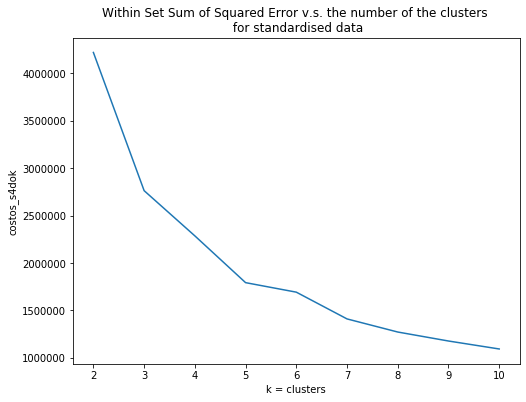

In [187]:
#Optimize choice of k in range (2,11)
costos_s4dok = np.zeros(11)
for k in range(2,11):
    kmeans_stinit4dok= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4dok.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=42))
    costos_s4dok[k] = model_scalinit4dok.computeCost(df_kmeans_scalinit4dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s4dok[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s4dok[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s4dok')

plt.show()    

k=3 οr k=5

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4142281.109477984
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2763017.762674892
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2249261.2688541617
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 1792781.5594657739
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1592303.5350804147
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1447369.4927910925
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1271989.1621558159
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1243929.7506722908
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1143304.0000768423


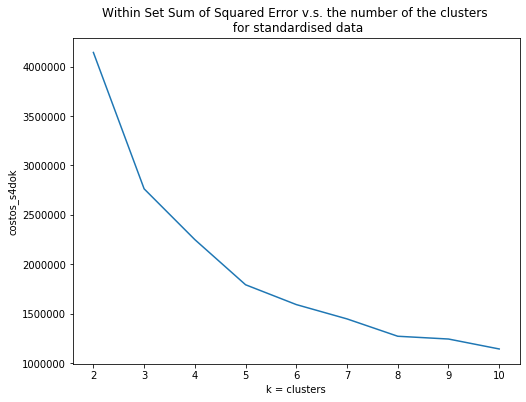

In [188]:
#Optimize choice of k in range (2,11)
costos_s4dok = np.zeros(11)
for k in range(2,11):
    kmeans_stinit4dok= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4dok.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=350))
    costos_s4dok[k] = model_scalinit4dok.computeCost(df_kmeans_scalinit4dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s4dok[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s4dok[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s4dok')

plt.show()    

k=3 or k=5

Within Set - Cluster Sum of Squared Errors for 2 clusters is: 4142228.661496863
Within Set - Cluster Sum of Squared Errors for 3 clusters is: 2763011.6761545977
Within Set - Cluster Sum of Squared Errors for 4 clusters is: 2285793.9352652766
Within Set - Cluster Sum of Squared Errors for 5 clusters is: 1792667.0478269123
Within Set - Cluster Sum of Squared Errors for 6 clusters is: 1692014.7131791955
Within Set - Cluster Sum of Squared Errors for 7 clusters is: 1417853.7374174395
Within Set - Cluster Sum of Squared Errors for 8 clusters is: 1323892.8617452586
Within Set - Cluster Sum of Squared Errors for 9 clusters is: 1174593.7733002626
Within Set - Cluster Sum of Squared Errors for 10 clusters is: 1109130.9436383916


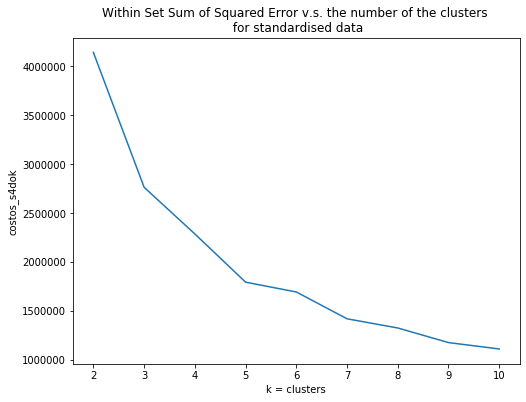

In [189]:
#Optimize choice of k in range (2,11)
costos_s4dok = np.zeros(11)
for k in range(2,11):
    kmeans_stinit4dok= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4dok.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=13))
    costos_s4dok[k] = model_scalinit4dok.computeCost(df_kmeans_scalinit4dok)
    print('Within Set - Cluster Sum of Squared Errors for ' + str(k) + ' clusters is: ' + str(costos_s4dok[k]))
#plot the Within Set Sum of Squared Error v.s. the number of the clusters'
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),costos_s4dok[2:11])
ax.set_title('Within Set Sum of Squared Error v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('costos_s4dok')

plt.show()    

### From the elbow analysis on the standardised data we could come to the result that there is no optimal number of clusters . Maybe we could test k=3 as optimal number or k = 5 

## Silhouette analysis

The Silhouette_cost for 2 clusters is: 0.41406249546857454
The Silhouette_cost for 3 clusters is: 0.5502999843821171
The Silhouette_cost for 4 clusters is: 0.49065901577662707
The Silhouette_cost for 5 clusters is: 0.5358231982236679
The Silhouette_cost for 6 clusters is: 0.46891299918293766
The Silhouette_cost for 7 clusters is: 0.5212811628140498
The Silhouette_cost for 8 clusters is: 0.5195273998208798
The Silhouette_cost for 9 clusters is: 0.4763157548982445
The Silhouette_cost for 10 clusters is: 0.47427420385615887


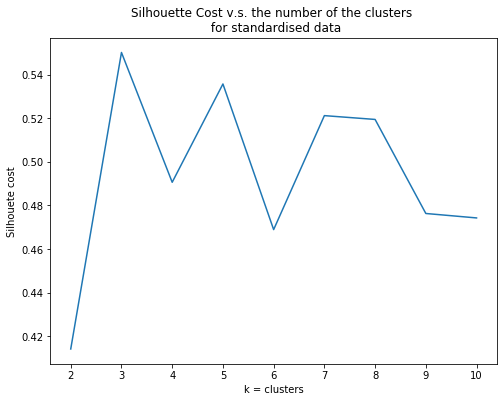

In [190]:
#Optimize choice of k in range (2,10]
evalsil4dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost4dok = np.zeros(11)

for k in range(2,11):
    kmeans_stinit4doksil= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4doksil.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=42))    
    prs = model_scalinit4dok.transform(df_kmeans_scalinit4dok)
    Silhouete_cost4dok[k] = evalsil4dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost4dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost4dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

k=3 or k=5

The Silhouette_cost for 2 clusters is: 0.5142174565552788
The Silhouette_cost for 3 clusters is: 0.5501764370476362
The Silhouette_cost for 4 clusters is: 0.5650794493935271
The Silhouette_cost for 5 clusters is: 0.5356063482389273
The Silhouette_cost for 6 clusters is: 0.5250040323117909
The Silhouette_cost for 7 clusters is: 0.4871222074653526
The Silhouette_cost for 8 clusters is: 0.5200053516225467
The Silhouette_cost for 9 clusters is: 0.47416613622136455
The Silhouette_cost for 10 clusters is: 0.44550563290283707


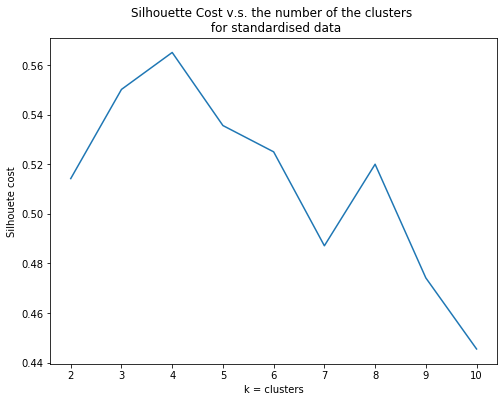

In [356]:
#Optimize choice of k in range (2,10]
evalsil4dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost4dok = np.zeros(11)

for k in range(2,11):
    kmeans_stinit4doksil= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4doksil.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=350))    
    prs = model_scalinit4dok.transform(df_kmeans_scalinit4dok)
    Silhouete_cost4dok[k] = evalsil4dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost4dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost4dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

k= 3 or k=4

The Silhouette_cost for 2 clusters is: 0.5187334428939486
The Silhouette_cost for 3 clusters is: 0.5501665167855747
The Silhouette_cost for 4 clusters is: 0.4877282064362905
The Silhouette_cost for 5 clusters is: 0.5340936835935608
The Silhouette_cost for 6 clusters is: 0.470373275229429
The Silhouette_cost for 7 clusters is: 0.532511889384972
The Silhouette_cost for 8 clusters is: 0.4839810030139652
The Silhouette_cost for 9 clusters is: 0.48496613718537845
The Silhouette_cost for 10 clusters is: 0.48060185100085345


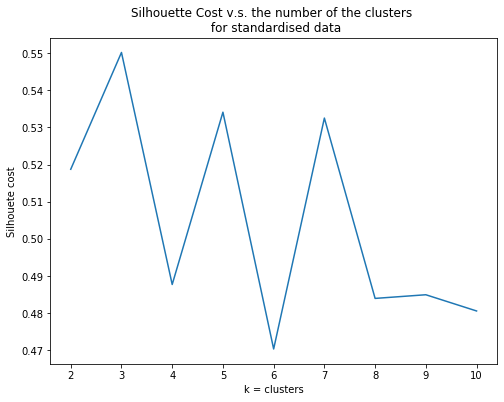

In [357]:
#Optimize choice of k in range (2,10]
evalsil4dok = ClusteringEvaluator(featuresCol='fetures')
Silhouete_cost4dok = np.zeros(11)

for k in range(2,11):
    kmeans_stinit4doksil= KMeans().setK(k).setSeed(1).setFeaturesCol("fetures")
    model_scalinit4dok = kmeans_stinit4doksil.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=13))    
    prs = model_scalinit4dok.transform(df_kmeans_scalinit4dok)
    Silhouete_cost4dok[k] = evalsil4dok.evaluate(prs) #Evaluate clustering 
    print('The Silhouette_cost for ' + str(k) + ' clusters is: ' + str(Silhouete_cost4dok[k]))
#plot the Silhouete cost
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,11),Silhouete_cost4dok[2:11])
ax.set_title('Silhouette Cost v.s. the number of the clusters \n for standardised data')
ax.set_xlabel('k = clusters')
ax.set_ylabel('Silhouete cost')

plt.show()
    

k=3 or k=5

### As before, using the Silhouete evaluator in standardised data I would not say that there is an optimal number of clusters, but I could test for k = 3 or k=4 or k = 5

# a)k=3

### cluster cenders-Understanding and labeling the components

In [358]:
#apply the above function
threeclustcentr4dok=cluster_centers_5f(df_kmeans_scalinit4dok,3,"fetures")
threeclustcentr4dok


Cluster Centers for the 3 clusters: 



,cluster_1,cluster_2,cluster_3
recency,-0.474031,0.122028,0.737326
frequency,0.817657,-0.615016,-0.734390
max_dist,-0.327259,-0.580372,1.370097
average_trans_dur,-0.489480,-0.370734,1.405878
start_trans_end_data,0.757598,-1.222445,0.174603


### TRansformation to the original data-inverse-standardization
#### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [359]:
mean_stdevn=mean_stdev.drop(columns='countt')
mean_stdevn

,recency,frequency,max_dist,average_trans_dur,start_trans_end_data
mean,45.356121,57.642532,62.375145,14.949348,409.357330
std,69.341972,60.171055,55.742538,16.091497,198.001587


In [361]:
threeclustercentroidi4dok3=originale_no_log(threeclustcentr4dok,3,mean_stdevn)
threeclustercentroidi4dok3

,cluster_1,cluster_2,cluster_3,original_cluster_1,original_cluster_2,original_cluster_3
index,,,,,,
recency,-0.474031,0.122028,0.737326,12.485877,53.817750,96.483767
frequency,0.817657,-0.615016,-0.734390,106.841827,20.636351,13.453506
max_dist,-0.327259,-0.580372,1.370097,44.132902,30.023712,138.747810
average_trans_dur,-0.489480,-0.370734,1.405878,7.072881,8.983678,37.572025
start_trans_end_data,0.757598,-1.222445,0.174603,559.362943,167.311290,443.928904


### Assign clusters to events

In [362]:
#for k=3 clusters
kmeansl = KMeans().setK(3).setSeed(1).setFeaturesCol("fetures")
model4dok3 = kmeansl.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=42))
trans_4dok3=model4dok3.transform(df_kmeans_scalinit4dok).select('client_username_s', 'prediction')
rows1s4dok3 = trans_4dok3.collect()
df_pred_for_std4dok3=spark.createDataFrame(rows1s4dok3)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust4dok3 = freq_equp2.join(df_pred_for_std4dok3, 'client_username_s', 'inner')

In [363]:
#get the mean of features for each cluster
p_mean4dok3 = pred_clust4dok3.groupBy('prediction').mean()
#convert to pandas
pd_p_mean4dok3 = p_mean4dok3.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh43=pred_clust4dok3.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust4dok3.groupBy('prediction').agg(stddev(value))
    join1 =dokimh43.join(a, dokimh43.prediction == a.prediction).drop(dokimh43.prediction) #drop dublicate
    dokimh43=join1
pd_stdev43=dokimh43.toPandas()

pd_p_mean4dok3

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,359.375526,55.072490,20.475239,29.926904,8.991938,112.511568,167.584059,0.0
1,1,214.825534,94.790171,13.707816,138.945017,37.452895,349.499219,444.289390,1.0
2,2,1939.101566,12.164457,106.953617,43.945267,7.047709,546.387757,558.552214,2.0


In [364]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev43=pd_stdev43[pd_stdev43.columns[new_order]]
pd_stdev43.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev43

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,502.544384,73.595689,23.717452,24.353384,7.815891,97.785576,99.608822
1,1,289.024243,83.357969,13.295290,50.426327,17.082859,165.015403,140.559573
2,2,1094.821387,27.689135,56.239261,30.785932,4.554071,83.413149,80.250850


In [365]:
#Get the number of clients belonged to each cluster
numb7=pred_clust4dok3.groupBy('prediction').count()
numb_perc_43=numb7.withColumn("percentage_of_total",(numb7["count"]/1218752)*100)
numb_perc_43.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|379609| 31.147354014598537|
|         1|292453| 23.996104211521292|
|         2|546690|  44.85654177388017|
+----------+------+-------------------+



## There are well separated clusters

# b) k=4

### Cluster centers-Understanding and labeling the components

In [366]:
#apply the function for cluster centers
fourclustcentr4dok=cluster_centers_5f(df_kmeans_scalinit4dok,4,"fetures")
fourclustcentr4dok


Cluster Centers for the 4 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4
recency,-0.506144,0.335884,2.255118,-0.284614
frequency,0.836977,-0.716925,-0.728657,-0.559578
max_dist,-0.340336,1.571716,-0.129860,-0.566283
average_trans_dur,-0.491441,1.495830,0.199569,-0.383970
start_trans_end_data,0.769330,0.205890,-0.302957,-1.298893


### TRansformation to the original data-inverse-standardization
### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [367]:
fourclustercentroidi4dok4=originale_no_log(fourclustcentr4dok,4,mean_stdevn)
fourclustercentroidi4dok4

,cluster_1,cluster_2,cluster_3,cluster_4,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4
index,,,,,,,,
recency,-0.506144,0.335884,2.255118,-0.284614,10.259113,68.646965,201.730444,25.620415
frequency,0.836977,-0.716925,-0.728657,-0.559578,108.004327,14.504369,13.798502,23.972142
max_dist,-0.340336,1.571716,-0.129860,-0.566283,43.403926,149.986560,55.136395,30.809103
average_trans_dur,-0.491441,1.495830,0.199569,-0.383970,7.041334,39.019487,18.160718,8.770689
start_trans_end_data,0.769330,0.205890,-0.302957,-1.298893,561.685837,450.123834,349.371389,152.174471


### Assign clusters to events

In [368]:
#for k=4 clusters
kmeansl = KMeans().setK(4).setSeed(1).setFeaturesCol("fetures")
model4dok4 = kmeansl.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=350))
trans_4dok4=model4dok4.transform(df_kmeans_scalinit4dok).select('client_username_s', 'prediction')
rows1s4dok4 = trans_4dok4.collect()
df_pred_for_std4dok4=spark.createDataFrame(rows1s4dok4)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust4dok4 = freq_equp2.join(df_pred_for_std4dok4, 'client_username_s', 'inner')

In [369]:
#get the mean of features for each cluster
p_mean4dok4 = pred_clust4dok4.groupBy('prediction').mean()
#convert to pandas
pd_p_mean4dok4 = p_mean4dok4.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh44=pred_clust4dok4.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust4dok4.groupBy('prediction').agg(stddev(value))
    join1 =dokimh44.join(a, dokimh44.prediction == a.prediction).drop(dokimh44.prediction) #drop dublicate
    dokimh44=join1
pd_stdev44=dokimh44.toPandas()
pd_p_mean4dok4

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,1964.528340,10.181246,108.162823,43.279288,7.017026,551.286945,561.468191,0.0
1,1,176.071130,200.948357,13.321270,54.902234,18.215625,145.015722,345.964079,1.0
2,3,240.055807,67.226654,14.788398,149.870379,38.789085,383.106739,450.333392,3.0
3,2,434.261060,25.492523,24.145481,30.610489,8.709600,126.641439,152.133962,2.0


In [370]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev44=pd_stdev44[pd_stdev44.columns[new_order]]
pd_stdev44.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev44

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,1094.401363,19.374644,56.414288,29.631739,4.501592,77.674912,75.938346
1,1,383.806934,51.362071,21.768159,39.320026,14.339067,137.811091,139.551618
2,3,310.362213,64.505445,14.289145,47.471757,17.542728,157.298192,143.217395
3,2,550.409325,33.513816,25.875185,24.926174,7.732647,101.268955,95.573418


In [371]:
#Get the number of clients belonged to each cluster
numb8=pred_clust4dok4.groupBy('prediction').count()
numb_perc_44=numb8.withColumn("percentage_of_total",(numb8["count"]/1218752)*100)
numb_perc_44.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|529220|  43.42310822874547|
|         1|126445| 10.374957333403351|
|         3|242639| 19.908808354776035|
|         2|320448| 26.293126083075148|
+----------+------+-------------------+



### The elbow does not agree , so I will not consider it

# c) k=5

### Cluster centers-Understanding and labeling the components

In [372]:
#apply the function for cluster centers
fiveclustcentr4dok=cluster_centers_5f(df_kmeans_scalinit4dok,5,"fetures")
fiveclustcentr4dok


Cluster Centers for the 5 clusters: 



,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
recency,-0.365353,0.650171,2.254834,-0.290431,-0.567584
frequency,-0.120592,-0.817160,-0.732098,-0.560540,1.506119
max_dist,0.273747,1.694406,-0.215064,-0.600957,-0.608549
average_trans_dur,-0.120390,1.981548,0.087184,-0.390948,-0.677119
start_trans_end_data,0.688393,0.056470,-0.365252,-1.354103,0.765271


### TRansformation to the original data-inverse-standardization
### (use of the type : stand_value * std(column) + mean(column)=originate_value

In [373]:
fiveclustercentroidi4dok5=originale_no_log(fiveclustcentr4dok,5,mean_stdevn)
fiveclustercentroidi4dok5

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,original_cluster_1,original_cluster_2,original_cluster_3,original_cluster_4,original_cluster_5
index,,,,,,,,,,
recency,-0.365353,0.650171,2.254834,-0.290431,-0.567584,20.021854,90.440282,201.710744,25.217040,5.998755
frequency,-0.120592,-0.817160,-0.732098,-0.560540,1.506119,50.386378,8.473169,13.591400,23.914259,148.267276
max_dist,0.273747,1.694406,-0.215064,-0.600957,-0.608549,77.634491,156.825662,50.386958,28.876262,28.453063
average_trans_dur,-0.120390,1.981548,0.087184,-0.390948,-0.677119,13.012088,46.835424,16.352266,8.658405,4.053496
start_trans_end_data,0.688393,0.056470,-0.365252,-1.354103,0.765271,545.660285,420.538561,337.036829,141.242834,560.882174


## Assign clusters to events

In [374]:
#for k=5 clusters
kmeansl = KMeans().setK(5).setSeed(1).setFeaturesCol("fetures")
model4dok5 = kmeansl.fit(df_kmeans_scalinit4dok.sample(False,0.1, seed=42))
trans_4dok5=model4dok5.transform(df_kmeans_scalinit4dok).select('client_username_s', 'prediction')
rows1s4dok5 = trans_4dok5.collect()
df_pred_for_std4dok5=spark.createDataFrame(rows1s4dok5)

#join the prediction spark with the initial spark datafarame with the features.
pred_clust4dok5 = freq_equp2.join(df_pred_for_std4dok5, 'client_username_s', 'inner')

In [375]:
#get the mean of features for each cluster
p_mean4dok5 = pred_clust4dok5.groupBy('prediction').mean()
#convert to pandas
pd_p_mean4dok5 = p_mean4dok5.toPandas()

c=['recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
dokimh45=pred_clust4dok5.groupBy('prediction').agg(stddev('countt'))
for value in c:
    a=pred_clust4dok5.groupBy('prediction').agg(stddev(value))
    join1 =dokimh45.join(a, dokimh45.prediction == a.prediction).drop(dokimh45.prediction) #drop dublicate
    dokimh45=join1
pd_stdev45=dokimh45.toPandas()

pd_p_mean4dok5

,prediction,avg(countt),avg(recency),avg(frequency),avg(max_dist),avg(average_trans_dur),avg(diff_maxd_mind_days),avg(start_trans_end_data),avg(prediction)
0,0,175.187011,201.852782,13.325711,49.981370,16.184782,133.623661,335.476443,0.0
1,1,2588.955861,6.113074,145.945044,28.780407,4.135511,554.209423,560.322496,1.0
2,3,429.426506,25.492880,23.905177,28.685703,8.598103,115.817856,141.310737,3.0
3,2,946.469522,20.399162,49.117794,79.702035,13.291782,523.998854,544.398016,2.0
4,4,115.988236,89.888180,8.290382,156.236457,47.068426,328.053042,417.941222,4.0


In [376]:
new_order = [6,0,1,2,3,4,5,7]
pd_stdev45=pd_stdev45[pd_stdev45.columns[new_order]]
pd_stdev45.columns = ['prediction','std(countt)','std(recency)','std(frequency)','std(max_dist)','std(average_trans_dur)','std(diff_maxd_mind_days)','std(start_trans_end_data)']
pd_stdev45

,prediction,std(countt),std(recency),std(frequency),std(max_dist),std(average_trans_dur),std(diff_maxd_mind_days),std(start_trans_end_data)
0,0,389.954899,49.631308,22.205529,37.352623,12.457382,132.748173,138.409668
1,1,965.047038,15.904068,43.541244,18.095481,1.375336,86.942686,85.849432
2,3,556.651669,33.418010,26.341135,23.065661,7.971388,89.683044,83.795573
3,2,594.721213,27.368008,23.248611,44.522858,6.612913,84.708525,80.696214
4,4,161.610458,73.431750,6.251685,47.257846,14.106780,155.479654,147.018118


In [377]:
#Get the number of clients belonged to each cluster
numb9=pred_clust4dok5.groupBy('prediction').count()
numb_perc_45=numb9.withColumn("percentage_of_total",(numb9["count"]/1218752)*100)
numb_perc_45.show()

+----------+------+-------------------+
|prediction| count|percentage_of_total|
+----------+------+-------------------+
|         0|116100|  9.526138213516777|
|         1|303315| 24.887343774615346|
|         3|305358| 25.054974268760173|
|         2|319457|  26.21181339599853|
|         4|174522| 14.319730347109175|
+----------+------+-------------------+



### There are no well separated clusters-feature avg(max_dist)

#                          !!      (:          Conclusion          : )         !!

## Visualization (on windows,3rd part)

In [378]:
#convert to pandas
pd_pred_clustl=pred_clustl.toPandas()
pd_pred_clust2dok3=pred_clust2dok3.toPandas()
#pd_pred_clust3dok3=pred_clust3dok3.toPandas()
#pd_pred_clust4dok3=pred_clust4dok3.toPandas()

In [379]:
#extract to csv 
arxeio1=pd_pred_clustl.to_csv(r'C:\Users\user\Desktop\NBG\pd_pred1dok3fromubuntu.csv',index = None, header=True)
arxeio2=pd_pred_clust2dok3.to_csv(r'C:\Users\user\Desktop\NBG\pd_pred2dok3fromubuntu.csv',index = None, header=True)
#arxeio3=pd_pred_clust3dok3.to_csv(r'C:\Users\user\Desktop\NBG\pd_pred3dok3fromubuntu.csv',index = None, header=True)
#arxeio4=pd_pred_clust4dok3.to_csv(r'C:\Users\user\Desktop\NBG\pd_pred4dok3fromubuntu.csv',index = None, header=True)

# 2DOK3 IS THE "BEST"

# Some statistics about the clusters with the "optimal" k   

##  see the statistic table for each cluster


In [391]:
#define a function that computes summary statisstics
def describe_stats(dataframe, columns, deciles=False):

    if deciles:
        percentiles = np.array(range(0, 110, 10)) #takes all the percentages from 0% -100%  with step 10 
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(dataframe.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)  #create a dataframe with the percentages
    percs['summary'] = [str(p) + '%' for p in percentiles]  #create a new column named "summary"  

    spark_describe = dataframe.describe().toPandas()  #convert the output of the command 'decribe' in panads data frame
   
    #for median
    df_pd=dataframe.toPandas()
    mc=df_pd.loc[:,"countt"].median()
    mr=df_pd.loc[:,"recency"].median()
    mf=df_pd.loc[:,"frequency"].median()
    md=df_pd.loc[:,"max_dist"].median()    
    ma=df_pd.loc[:,"average_trans_dur"].median()
    mdm=df_pd.loc[:,"diff_maxd_mind_days"].median()
    mse=df_pd.loc[:,"start_trans_end_data"].median()
    
    
    mednew= [{'countt':mc,'recency':mr,'frequency':mf,'max_dist':md,'average_trans_dur':ma,
              'diff_maxd_mind_days':mdm,'start_trans_end_data':mse}]
    median_df=pd.DataFrame(mednew, index =['median'])
    #concat the basic statistic measures from command describe and the percentiles
    new_df = pd.concat([spark_describe,median_df,percs],ignore_index=True)
    new_df = new_df.round(2)
    new_df=new_df[['summary'] + columns]
    new_df.loc[5,'summary'] = 'median'
    
    return new_df


# Cluster 0    

In [392]:
#spark dataframe for cluster 0
cluster_pred0 = pred_clust2dok3.filter(pred_clust2dok3['prediction'] == 0)

In [393]:
#apply the function for statistics 
col1=['countt','recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
summary_cluster_0=describe_stats(cluster_pred0,col1,1) 
summary_cluster_0

,summary,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,count,594478,594478,594478,594478,594478,594478,594478
1,mean,1869.0539952697998,10.476989897018898,103.61749635814951,42.48418780846389,6.2580518721944625,502.6250643421624,513.1020542391813
2,stddev,1094.58105597006,27.87448955808728,55.50652862313106,34.70950609667868,3.676361283803731,137.92884273388285,135.5826059949405
3,min,19.0,0.0,8.0,2.0,1.01,69.0,90.0
4,max,4693.0,287.0,251.0,266.0,31.63,607.0,607.0
5,median,1659,3,92,32,5.21,580,592
6,0%,19,0,8,2,1.01,69,90
7,10%,609,0,40,15,2.68,252,266
8,20%,879,1,52,20,3.25,380,397
9,30%,1121,2,65,24,3.82,481,500


## plot the max_dist for cluster 0

#### Convert the pyspark dataframe to pandas

In [394]:
#convert to pandas the whole pyspark
pd_cluster_pred0=cluster_pred0.toPandas()
##convert to pandas the max_dist
pd_max_dist_cluster_0=cluster_pred0.select([c for c in cluster_pred0.columns if c in ['max_dist']]).toPandas()


#### Histogram

<Figure size 432x288 with 0 Axes>

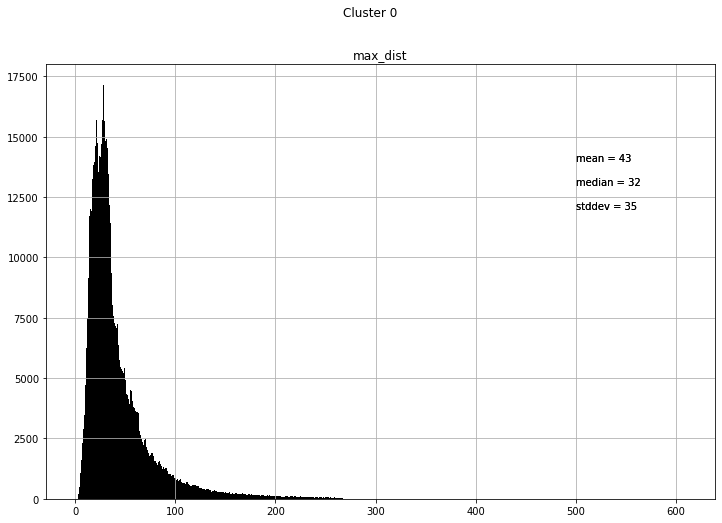

In [504]:
plt.figure()
bin_values = np.arange(start=1, stop=610, step=1)
pd_max_dist_cluster_0.hist(bins=bin_values,color='black', figsize=[12,8])
plt.text(500,14000 ,r'mean = 43')
plt.text(500,14000 ,r'mean = 43')
plt.text(500,13000 ,r'median = 32')
plt.text(500,13000 ,r'median = 32')
plt.text(500,12000 ,r'stddev = 35')
plt.text(500,12000 ,r'stddev = 35')
plt.suptitle("Cluster 0")
plt.show()

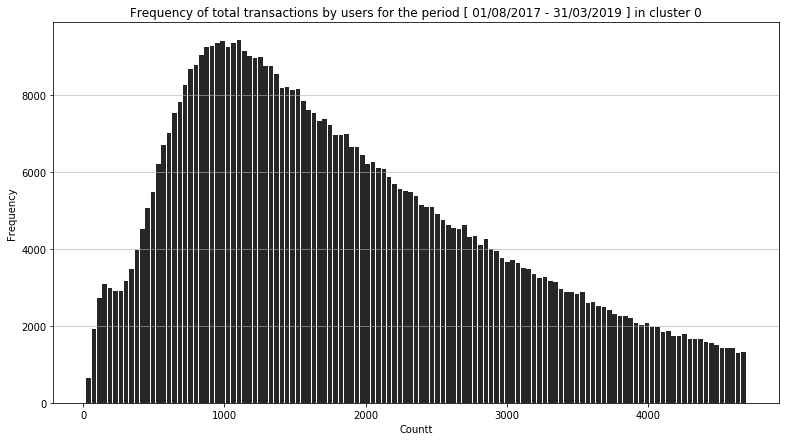

In [525]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['countt'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Countt')
plt.ylabel('Frequency')
plt.title('Frequency of total transactions by users for the period [ 01/08/2017 - 31/03/2019 ] in cluster 0')

plt.show()

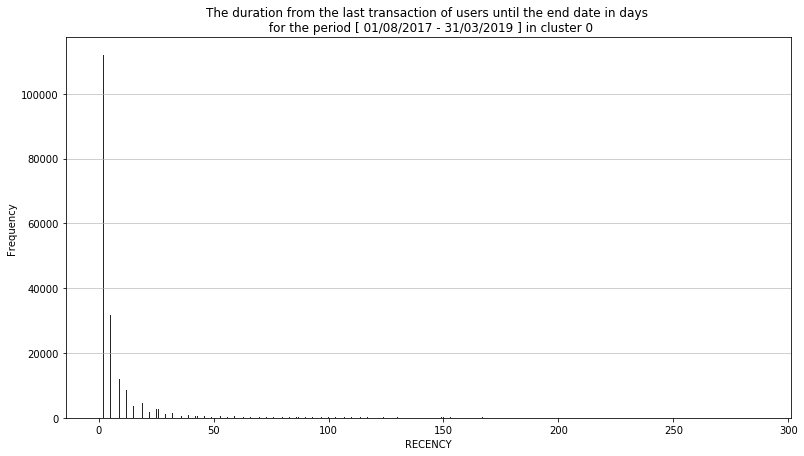

In [506]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['recency'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('RECENCY')
plt.ylabel('Frequency')
plt.title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 0')

plt.show()

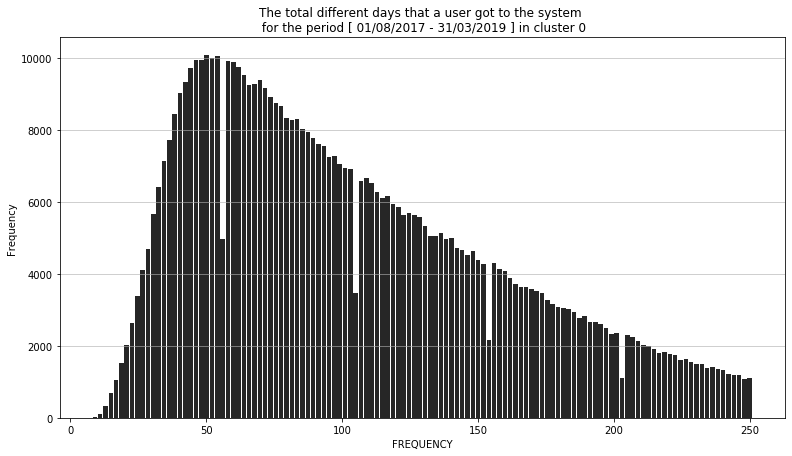

In [507]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['frequency'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('FREQUENCY')
plt.ylabel('Frequency')
plt.title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 0')
plt.show()


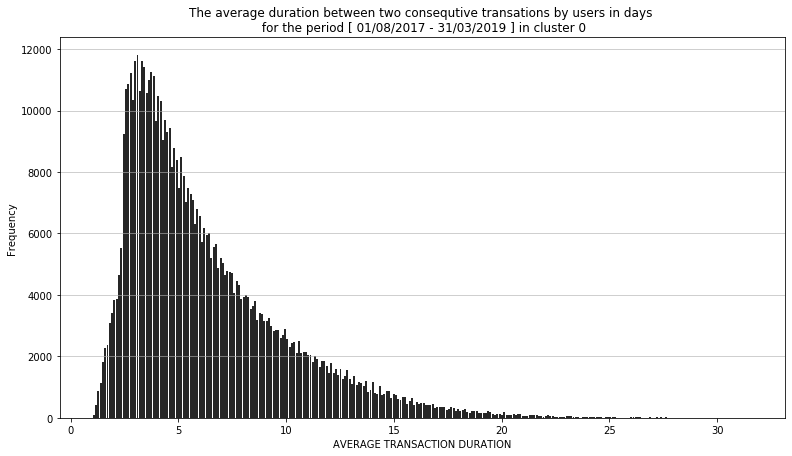

In [508]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['average_trans_dur'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('AVERAGE TRANSACTION DURATION')
plt.ylabel('Frequency')
plt.title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 0')

plt.show()

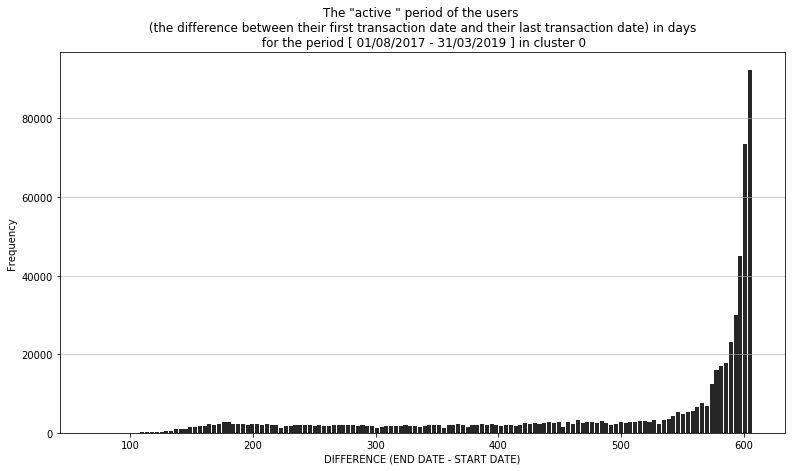

In [509]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['diff_maxd_mind_days'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('DIFFERENCE (END DATE - START DATE)')
plt.ylabel('Frequency')
plt.title('The "active " period of the users \n (the difference between their first transaction date and their last transaction date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 0')

plt.show()

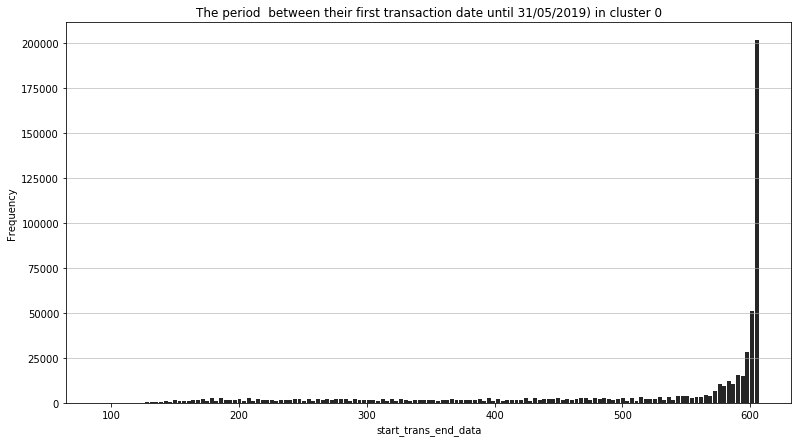

In [510]:
#hist for start_end
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred0['start_trans_end_data'], bins='auto', color='black',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('start_trans_end_data')
plt.ylabel('Frequency')
plt.title('The period  between their first transaction date until 31/05/2019) in cluster 0')
plt.show()

# Cluster 1

In [396]:
#spark dataframe for only cluster 1
cluster_pred1 = pred_clust2dok3.filter(pred_clust2dok3['prediction'] == 1)

In [397]:
#apply the function for statistics 
summary_cluster_1=describe_stats(cluster_pred1,col1,1) 
summary_cluster_1

,summary,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,count,430137,430137,430137,430137,430137,430137,430137
1,mean,230.6326565722084,89.32681680487845,14.116899964429937,111.24821626598037,31.283696799724492,314.3215603400777,403.64837714495616
2,stddev,288.58714470936707,80.03380915759712,12.664478066022724,55.92007461336481,17.126910289278573,182.1392911283346,163.81571911281534
3,min,2.0,0.0,2.0,14.0,3.22,17.0,63.0
4,max,4686.0,287.0,106.0,266.0,72.86,607.0,607.0
5,median,112,62,10,102,27,313,424
6,0%,2,0,2,14,3.22,17,63
7,10%,3,7,2,46,12.33,74,170
8,20%,7,17,3,61,15.82,117,230
9,30%,17,28,5,74,19.03,168,285


## plot the max_dist for cluster 1

#### Convert the pyspark dataframe to pandas

In [398]:
#convert to pandas the whole pyspark
pd_cluster_pred1=cluster_pred1.toPandas()
##convert to pandas the max_dist
pd_max_dist_cluster_1=cluster_pred1.select([c for c in cluster_pred1.columns if c in ['max_dist']]).toPandas()


#### Histogram

<Figure size 432x288 with 0 Axes>

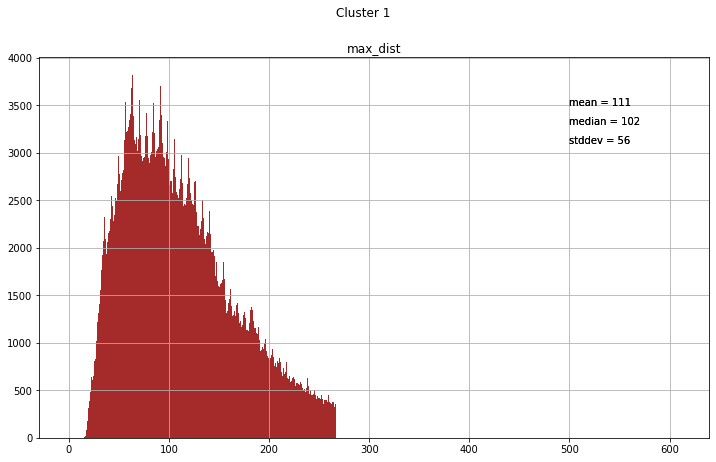

In [511]:
plt.figure()
bin_values = np.arange(start=1, stop=610, step=1)
pd_max_dist_cluster_1.hist(bins=bin_values,color='brown', figsize=[12,7])
plt.text(500,3500 ,r'mean = 111')
plt.text(500,3500 ,r'mean = 111')
plt.text(500,3300 ,r'median = 102')
plt.text(500,3300 ,r'median = 102')
plt.text(500,3100 ,r'stddev = 56')
plt.text(500,3100 ,r'stddev = 56')
plt.suptitle("Cluster 1")

plt.show()

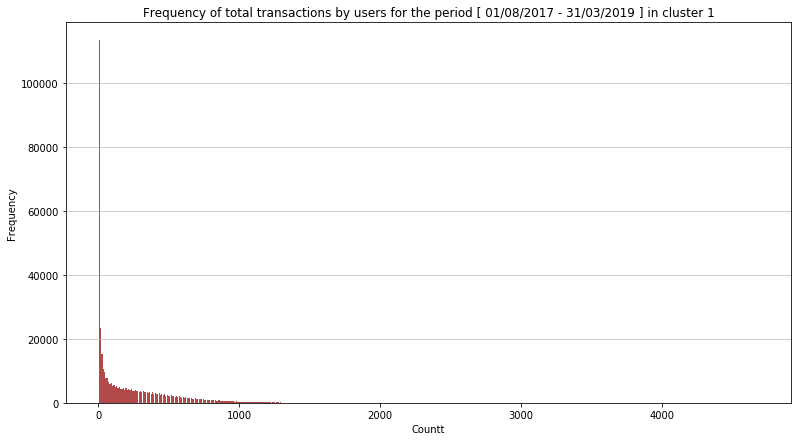

In [526]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['countt'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Countt')
plt.ylabel('Frequency')
plt.title('Frequency of total transactions by users for the period [ 01/08/2017 - 31/03/2019 ] in cluster 1')

plt.show()

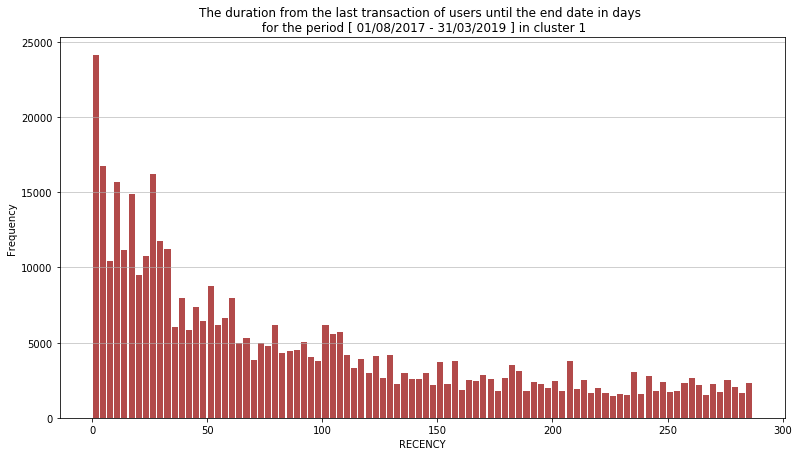

In [513]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['recency'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('RECENCY')
plt.ylabel('Frequency')
plt.title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 1')
plt.show()

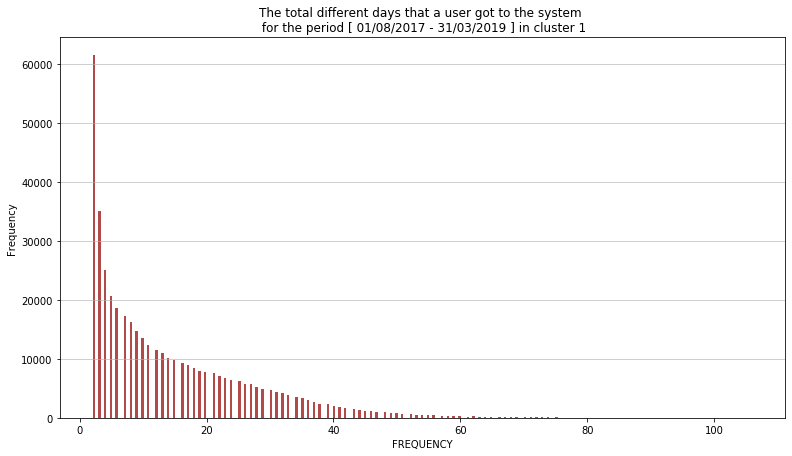

In [514]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['frequency'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('FREQUENCY')
plt.ylabel('Frequency')
plt.title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 1')
plt.show()

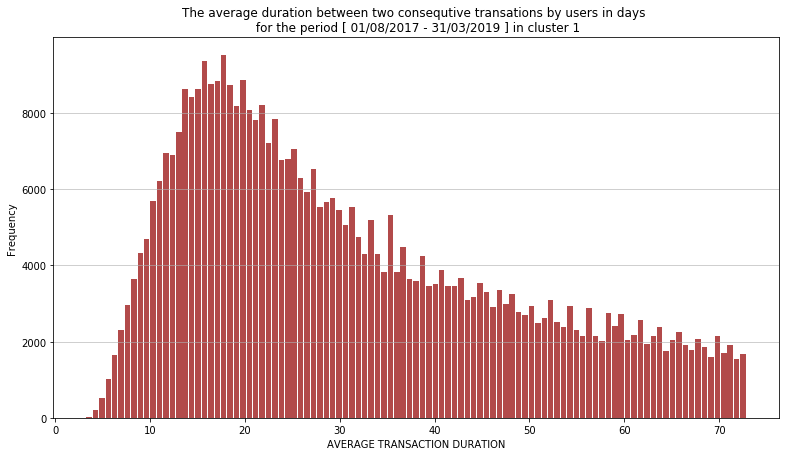

In [515]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['average_trans_dur'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('AVERAGE TRANSACTION DURATION')
plt.ylabel('Frequency')
plt.title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 1')

plt.show()

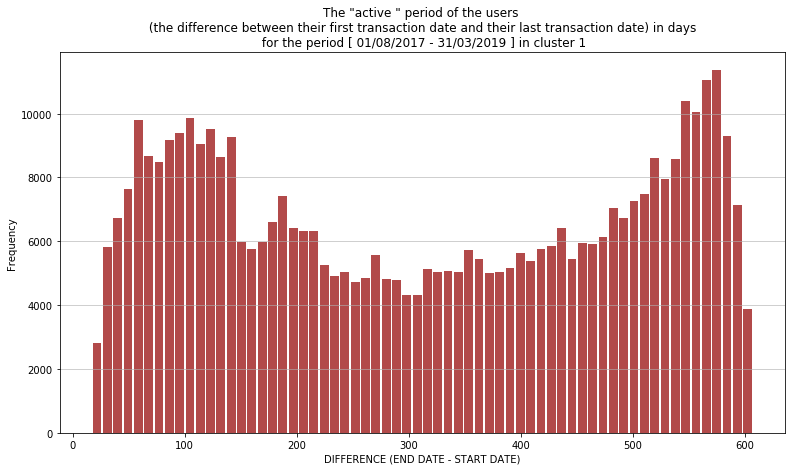

In [516]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['diff_maxd_mind_days'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('DIFFERENCE (END DATE - START DATE)')
plt.ylabel('Frequency')
plt.title('The "active " period of the users \n (the difference between their first transaction date and their last transaction date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 1')

plt.show()

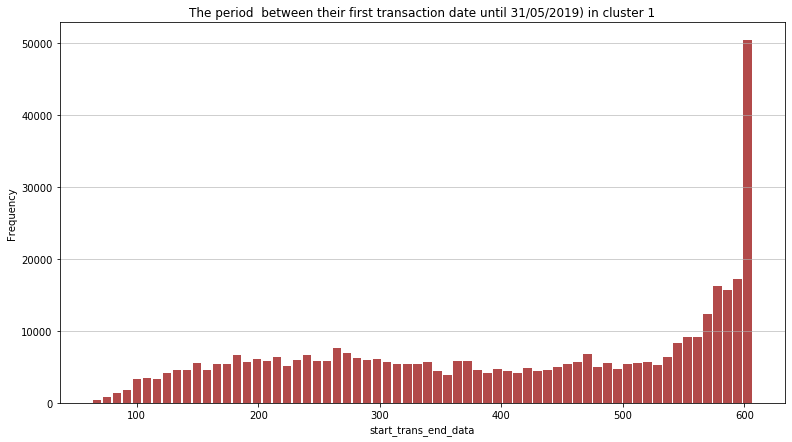

In [517]:
#hist for start_end
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred1['start_trans_end_data'], bins='auto', color='brown',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('start_trans_end_data')
plt.ylabel('Frequency')
plt.title('The period  between their first transaction date until 31/05/2019) in cluster 1')
plt.show()

# Cluster 2

In [402]:
#spark dataframe with only cluster 2
cluster_pred2 = pred_clust2dok3.filter(pred_clust2dok3['prediction'] == 2)

In [403]:
#apply the function for statistics 
summary_cluster_2=describe_stats(cluster_pred2,col1,1) 
summary_cluster_2

,summary,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data
0,count,194137,194137,194137,194137,194137,194137,194137
1,mean,252.5065855555613,54.73846304413893,13.296934638940542,14.99950035284361,5.372465323177016,49.585323766206336,104.32378681034527
2,stddev,416.4284567588798,74.27805747321258,17.40184058789287,11.865700124744238,4.479190443673416,45.20727190691475,65.53318639438776
3,min,2.0,0.0,2.0,1.0,0.5,1.0,1.0
4,max,4693.0,287.0,175.0,94.0,32.5,207.0,398.0
5,median,90,16,5,12,4,35,95
6,0%,2,0,2,1,0.5,1,1
7,10%,3,1,2,2,1,2,29
8,20%,6,2,2,4,1.7,7,47
9,30%,16,3,2,7,2.4,14,63


## plot the max_dist for cluster 2

#### Convert the pyspark dataframe to pandas 

In [404]:
#convert to pandas the whole pyspark
pd_cluster_pred2=cluster_pred2.toPandas()
##convert to pandas the max_dist
pd_max_dist_cluster_2=cluster_pred2.select([c for c in cluster_pred2.columns if c in ['max_dist']]).toPandas()

### Histogram

<Figure size 432x288 with 0 Axes>

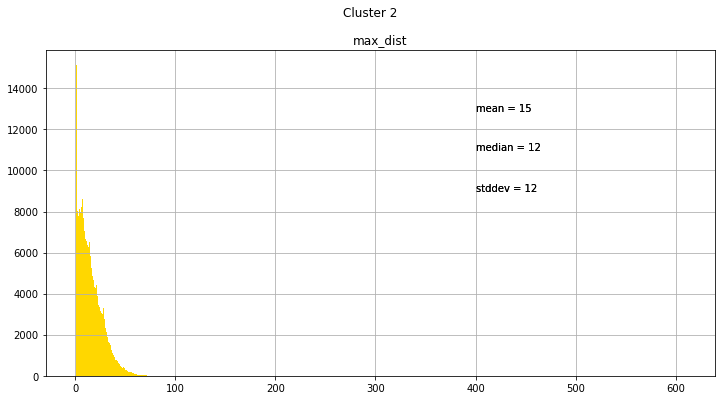

In [518]:
plt.figure()
bin_values = np.arange(start=1, stop=610, step=1)
pd_max_dist_cluster_2.hist(bins=bin_values,color='gold', figsize=[12,6])
plt.text(400,12900 ,r'mean = 15')
plt.text(400,12900 ,r'mean = 15')
plt.text(400,11000 ,r'median = 12')
plt.text(400,11000,r'median = 12')
plt.text(400,9000 ,r'stddev = 12')
plt.text(400,9000 ,r'stddev = 12')
plt.suptitle("Cluster 2")

plt.show()

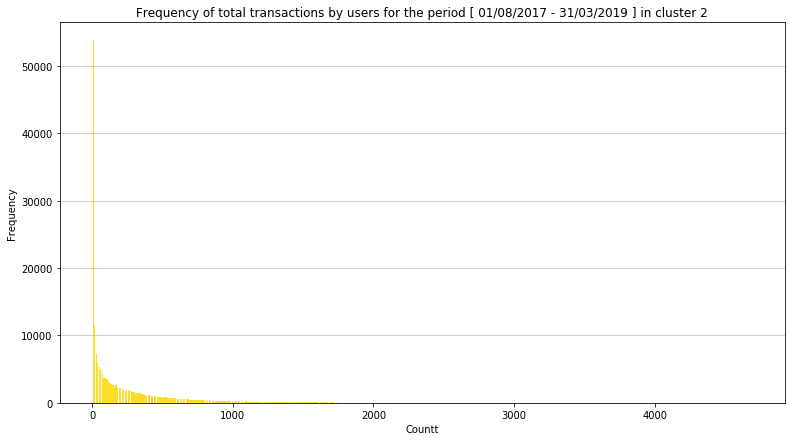

In [527]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['countt'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('Countt')
plt.ylabel('Frequency')
plt.title('Frequency of total transactions by users for the period [ 01/08/2017 - 31/03/2019 ] in cluster 2')

plt.show()

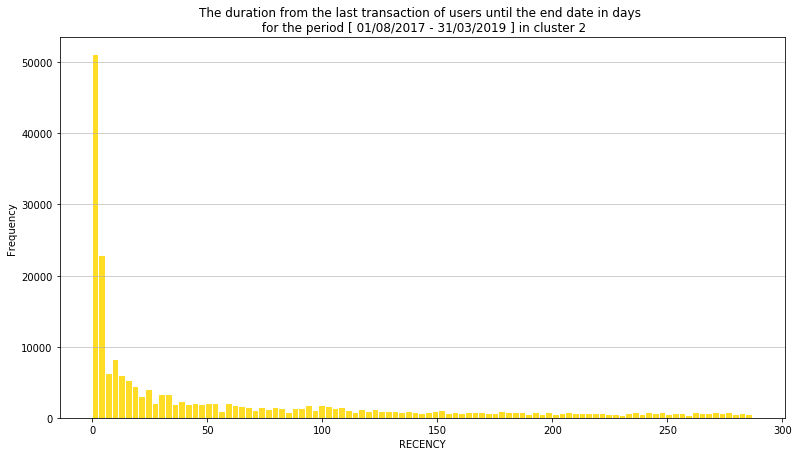

In [520]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['recency'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('RECENCY')
plt.ylabel('Frequency')
plt.title('The duration from the last transaction of users until the end date in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 2')
plt.show()

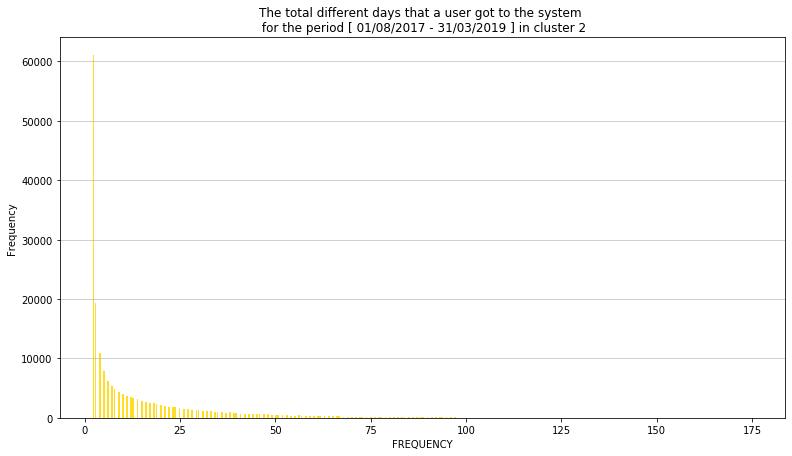

In [521]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['frequency'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('FREQUENCY')
plt.ylabel('Frequency')
plt.title('The total different days that a user got to the system \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 2')
plt.show()

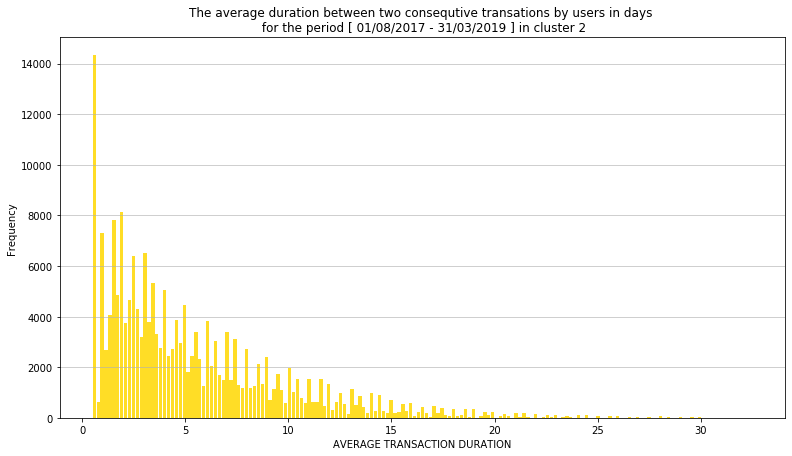

In [522]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['average_trans_dur'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('AVERAGE TRANSACTION DURATION')
plt.ylabel('Frequency')
plt.title('The average duration between two consequtive transations by users in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 2')

plt.show()

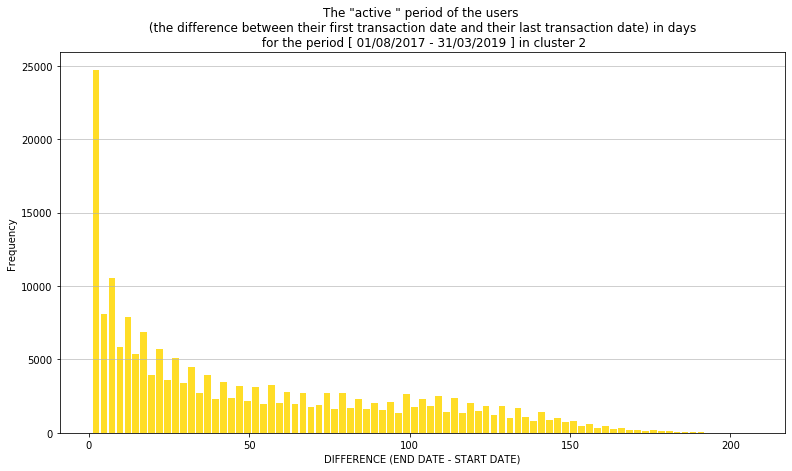

In [523]:
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['diff_maxd_mind_days'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('DIFFERENCE (END DATE - START DATE)')
plt.ylabel('Frequency')
plt.title('The "active " period of the users \n (the difference between their first transaction date and their last transaction date) in days \n for the period [ 01/08/2017 - 31/03/2019 ] in cluster 2')

plt.show()

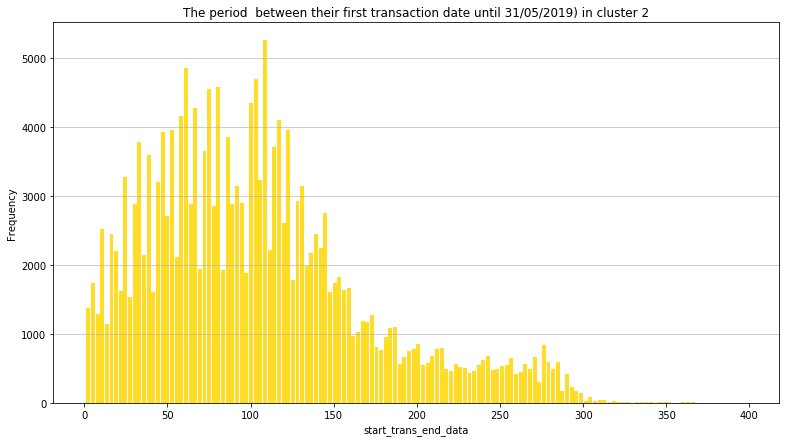

In [524]:
#hist for start_end
plt.figure(figsize = (13, 7))
n, bins, patches = plt.hist(x=pd_cluster_pred2['start_trans_end_data'], bins='auto', color='gold',alpha=0.85,rwidth=0.85)
plt.grid(axis='y',alpha=0.75)
plt.xlabel('start_trans_end_data')
plt.ylabel('Frequency')
plt.title('The period  between their first transaction date until 31/05/2019) in cluster 2')
plt.show()

# END OF THE CLUSTERING

# EXTRACTING LABELS

#       ! TIME OF PERIOD OF DATA    !

## Start date : 01/04/2019

## End date : 31/07/2019

### Read the data for the last 4 months

In [409]:
#read the spark
last4months=spark.read.csv("churn_results_6_merged.csv",header=False,sep = '\t')
#rename  the columns
last4months = last4months.selectExpr("_c0 as client_username_subset ",
                   "_c1 as countt",
                   "_c2 as recency",
                   "_c3 as frequency",
                   "_c4 as max_dist",
                   "_c5 as average_trans_dur",
                   "_c6 as diff_maxd_mind_days",
                   "_c7 as start_trans_end_data")


In [410]:
#convert to float all the features from double
FETURES_COLLSSN = ['countt','recency','frequency','max_dist','average_trans_dur','diff_maxd_mind_days','start_trans_end_data']
for col in last4months.columns:
    if col in FETURES_COLLSSN:
        last4months = last4months.withColumn(col,last4months[col].cast('float'))
#last4months.show()

In [411]:
#round a column
last4months=last4months.withColumn("average_trans_dur", func.round(last4months["average_trans_dur"], 2))
#last4months.printSchema()

In [412]:
last4months.show()

+----------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|client_username_subset|countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+----------------------+------+-------+---------+--------+-----------------+-------------------+--------------------+
|  -1383360085895621481|4441.0|    0.0|    107.0|     2.0|             1.13|              121.0|               121.0|
|  -1932624376972617513|   6.0|   19.0|      2.0|    31.0|             15.5|               31.0|                50.0|
|  -4373917140025030743|  88.0|    7.0|      2.0|    98.0|             49.0|               98.0|               105.0|
|   8138114728915753073| 530.0|    6.0|     23.0|    17.0|              5.0|              115.0|               121.0|
|   3238105438798080237| 955.0|    1.0|     60.0|    11.0|              2.0|              120.0|               121.0|
|   6715359518456271901| 713.0|    2.0|     15.0|    29.

In [413]:
last4months.dtypes

[('client_username_subset', 'string'),
 ('countt', 'float'),
 ('recency', 'float'),
 ('frequency', 'float'),
 ('max_dist', 'float'),
 ('average_trans_dur', 'float'),
 ('diff_maxd_mind_days', 'float'),
 ('start_trans_end_data', 'float')]

In [417]:
#apply the above function
count_results(last4months)

+----------------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+
|client_username_subset| countt|recency|frequency|max_dist|average_trans_dur|diff_maxd_mind_days|start_trans_end_data|
+----------------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+
|               2311471|2311471|2311471|  2311471| 2311471|          2311471|            2311471|             2311471|
+----------------------+-------+-------+---------+--------+-----------------+-------------------+--------------------+



Since the count results are the same, we have not null values

### Check for dublicates

In [418]:
#number of rows
last4months.count()

2311471

In [419]:
# Get the distinct number of values of 'client_username' 
#number of diff. users in the clenaed dataset
nsub=last4months.select("client_username_subset").distinct().count()
print("The number of  different users is : ",nsub)

The number of  different users is :  2311471


There are no dublicates

## Take the columns that I am interested in


In [420]:
last4months_cols=last4months.select([c for c in last4months.columns if c in ['client_username_subset','max_dist','frequency','start_trans_end_data']])


In [421]:
#replace the values in the column "max_dist" who have frequency=1 with the respective value in the column start_trans_end_data
last4months_cols = last4months_cols.withColumn("max_dist", \
              when(last4months_cols["frequency"] == 1,last4months_cols["start_trans_end_data"]).otherwise(last4months_cols["max_dist"]))


In [422]:
#take the columns I want
last4months_2cols=last4months_cols.select([c for c in last4months_cols.columns if c in ['client_username_subset','max_dist']])
#last4months_2cols.show()

# JOIN THE PYSPARK DATAFRAMES SO AS TO GET ONLY MY SPECIFIC USERS

In [423]:
left_join = users.join(last4months_2cols,users.client_username_s == last4months_2cols.client_username_subset,how='left')
#left_join.show()

In [424]:
#count the number of users (assess)
left_join.count()

1218752

In [425]:
#Take the columns I want
left_join=left_join.select([c for c in left_join.columns if c in ['client_username_s','max_dist']])
left_join.show()   #null values are when the user did not any transaction

+--------------------+--------+
|   client_username_s|max_dist|
+--------------------+--------+
|-1000163929915456142|     6.0|
|-1001917637217085351|    null|
|-1004642113113853355|    16.0|
|-1005915475241492533|    22.0|
| -100625782685149727|    null|
|-1006479762907683912|    null|
|-1007495709218608532|    11.0|
|-1008242054619612740|    null|
|-1012709334738752330|    25.0|
|-1015649428832020869|    13.0|
|-1018137260849293068|    45.0|
|-1018831754780105590|    87.0|
|-1020174522564360412|    18.0|
|-1020259554323918928|    51.0|
| -102127392915502803|    null|
|-1023909828366673538|    23.0|
|-1026345020972741726|    19.0|
|-1030130639507915299|    null|
| -103027882046051710|    46.0|
|-1033456804888960815|    null|
+--------------------+--------+
only showing top 20 rows



In [426]:
#convert to pandas the spark df
pd_left_join=left_join.toPandas()
pd_left_join

,client_username_s,max_dist
0,-1000163929915456142,6.0
1,-1001917637217085351,NaN
2,-1004642113113853355,16.0
3,-1005915475241492533,22.0
4,-100625782685149727,NaN
...,...,...
1218747,986771320870108620,24.0
1218748,987280583880788922,NaN
1218749,989732350174732186,14.0
1218750,996761541124855316,16.0


## For each cluster I have to separate clients to churn \ no churn

### I will add a column with the median of each cluster 
If the data are skewed (i.e. they are far from being normally distributed)the median generally gives a more appropriate idea of the data distribution.

### Cluster 0

In [430]:
#take the column I want
clusteraki0=cluster_pred0.select([c for c in cluster_pred0.columns if c in ['client_username_s']])
#convert to pandas
pd_clusteraki0=clusteraki0.toPandas()
#add new columns
pd_clusteraki0['mean(max_dist)']=43
pd_clusteraki0['2*mean(max_dist)']=2*pd_clusteraki0['mean(max_dist)']

pd_clusteraki0['median(max_dist)']=32
pd_clusteraki0['2*median(max_dist)']=2*pd_clusteraki0['median(max_dist)']

In [431]:
#oin the dfs
join_forcl0= pd.merge(pd_clusteraki0, pd_left_join, on='client_username_s')
#join_forcl0

### Define a function so as to extract the labels 

In [432]:
def target(row):
    if row['max_dist'] > row['2*mean(max_dist)'] or math.isnan(row['max_dist']):
        value = 1   # 1 = churn
    else:
        value = 0   # 0 = no churn

    return value

In [433]:
def target_by_median(row):
    if row['max_dist'] > row['2*median(max_dist)'] or math.isnan(row['max_dist']):
        value = 1   # 1 = churn
    else:
        value = 0   # 0 = no churn

    return value

In [434]:
#apply the def on pandas df
join_forcl0['Target'] = join_forcl0.apply(target, axis=1)
join_forcl0['Target_by_med']=join_forcl0.apply(target_by_median, axis=1)
join_forcl0

,client_username_s,mean(max_dist),2*mean(max_dist),median(max_dist),2*median(max_dist),max_dist,Target,Target_by_med
0,-1383360085895621481,43,86,32,64,2.0,0,0
1,-4373917140025030743,43,86,32,64,98.0,1,1
2,8138114728915753073,43,86,32,64,17.0,0,0
3,3238105438798080237,43,86,32,64,11.0,0,0
4,6715359518456271901,43,86,32,64,29.0,0,0
...,...,...,...,...,...,...,...,...
594473,8905403050974830103,43,86,32,64,12.0,0,0
594474,-6352717074677600437,43,86,32,64,31.0,0,0
594475,6215693035640726241,43,86,32,64,11.0,0,0
594476,-695014438646068338,43,86,32,64,29.0,0,0


In [435]:
#count the 'churn' by mean
print('There are ' + str(join_forcl0[join_forcl0.Target ==1].sum()["Target"]) + ' churn clients in the cluster 0 based on mean and \nthere are ' + str(len(join_forcl0)-join_forcl0[join_forcl0.Target ==1].sum()["Target"]) + ' no churn clients in the cluster 0 based on mean')


There are 29473 churn clients in the cluster 0 based on mean and 
there are 565005 no churn clients in the cluster 0 based on mean


In [436]:
#count the 'churn' by median
print('There are ' + str(join_forcl0[join_forcl0.Target_by_med ==1].sum()["Target_by_med"]) + ' churn clients in the cluster 0 based on median and \nthere are ' + str(len(join_forcl0)-join_forcl0[join_forcl0.Target_by_med ==1].sum()["Target_by_med"]) + ' no churn clients in the cluster 0 based on median')


There are 38583 churn clients in the cluster 0 based on median and 
there are 555895 no churn clients in the cluster 0 based on median


### Cluster 1

In [439]:
#take the column I want
clusteraki1=cluster_pred1.select([c for c in cluster_pred1.columns if c in ['client_username_s']])
#convert to pandas
pd_clusteraki1=clusteraki1.toPandas()
#add new columns
pd_clusteraki1['mean(max_dist)']=111
pd_clusteraki1['2*mean(max_dist)']=2*pd_clusteraki1['mean(max_dist)']

pd_clusteraki1['median(max_dist)']=102
pd_clusteraki1['2*median(max_dist)']=2*pd_clusteraki1['median(max_dist)']

In [443]:
pd_clusteraki1

,client_username_s,mean(max_dist),2*mean(max_dist),median(max_dist),2*median(max_dist)
0,-3076708436585629202,111,222,102,204
1,-1932624376972617513,111,222,102,204
2,-8064344582484646647,111,222,102,204
3,-2537030807470187043,111,222,102,204
4,-4177479135651951702,111,222,102,204
...,...,...,...,...,...
430132,-8610168720358159055,111,222,102,204
430133,-4964498208948442810,111,222,102,204
430134,1230950600678597407,111,222,102,204
430135,9193353595840245243,111,222,102,204


### For the cluster 1 we can not infer something  beacause its lead period has not yet passed. We have 204 days as lead period for the cluster 1 and our window is 4 months e.g. 121 days.

# Cluster 2

In [444]:
#take the column I want
clusteraki2=cluster_pred2.select([c for c in cluster_pred2.columns if c in ['client_username_s']])
#convert to pandas
pd_clusteraki2=clusteraki2.toPandas()
#add new columns
pd_clusteraki2['mean(max_dist)']=15
pd_clusteraki2['2*mean(max_dist)']=2*pd_clusteraki2['mean(max_dist)']

pd_clusteraki2['median(max_dist)']=12
pd_clusteraki2['2*median(max_dist)']=2*pd_clusteraki2['median(max_dist)']

In [445]:
#oin the dfs
join_forcl2= pd.merge(pd_clusteraki2, pd_left_join, on='client_username_s')
#join_forcl2

In [446]:
#apply  defs on pandas df
join_forcl2['Target'] = join_forcl2.apply(target, axis=1)
join_forcl2['Target_by_med']=join_forcl2.apply(target_by_median, axis=1)
join_forcl2

,client_username_s,mean(max_dist),2*mean(max_dist),median(max_dist),2*median(max_dist),max_dist,Target,Target_by_med
0,-8165052955687777117,15,30,12,24,15.0,0,0
1,2668027758950168641,15,30,12,24,22.0,0,0
2,9177886260668941966,15,30,12,24,77.0,1,1
3,-3392950503654926158,15,30,12,24,15.0,0,0
4,6540297600479042960,15,30,12,24,107.0,1,1
...,...,...,...,...,...,...,...,...
194132,8365652821643362314,15,30,12,24,33.0,1,1
194133,-3068585578218379012,15,30,12,24,9.0,0,0
194134,-7183973549306794591,15,30,12,24,NaN,1,1
194135,6207168172362238694,15,30,12,24,NaN,1,1


In [447]:
#count the 'churn' and no churn mean
print('There are ' + str(join_forcl2[join_forcl2.Target ==1].sum()["Target"]) + ' churn clients in the cluster 2 based on mean and \nthere are ' + str(len(join_forcl2)-join_forcl2[join_forcl2.Target ==1].sum()["Target"]) + ' no churn clients in the cluster 2 based on mean')


There are 108812 churn clients in the cluster 2 based on mean and 
there are 85325 no churn clients in the cluster 2 based on mean


In [448]:
#count the 'churn' and no churn median
print('There are ' + str(join_forcl2[join_forcl2.Target_by_med ==1].sum()["Target_by_med"]) + ' churn clients in the cluster 2 based on median and \nthere are ' + str(len(join_forcl2)-join_forcl2[join_forcl2.Target_by_med ==1].sum()["Target_by_med"]) + ' no churn clients in the cluster 2 based on median')


There are 121484 churn clients in the cluster 2 based on median and 
there are 72653 no churn clients in the cluster 2 based on median


In [452]:
#add the type of cluster 
join_forcl0['Cluster']=0

In [454]:
#add the type of cluster 
join_forcl2['Cluster']=2

In [471]:
#for cluster 0
dataforcluster0=join_forcl0[['client_username_s','Cluster','Target']]
dataforcluster0

,client_username_s,Cluster,Target
0,-1383360085895621481,0,0
1,-4373917140025030743,0,1
2,8138114728915753073,0,0
3,3238105438798080237,0,0
4,6715359518456271901,0,0
...,...,...,...
594473,8905403050974830103,0,0
594474,-6352717074677600437,0,0
594475,6215693035640726241,0,0
594476,-695014438646068338,0,0


In [473]:
#for cluster 0 median
dataforcluster0_median=join_forcl0[['client_username_s','Cluster','Target_by_med']]
dataforcluster0_median

,client_username_s,Cluster,Target_by_med
0,-1383360085895621481,0,0
1,-4373917140025030743,0,1
2,8138114728915753073,0,0
3,3238105438798080237,0,0
4,6715359518456271901,0,0
...,...,...,...
594473,8905403050974830103,0,0
594474,-6352717074677600437,0,0
594475,6215693035640726241,0,0
594476,-695014438646068338,0,0


In [472]:
#for cluster 2 mean
dataforcluster2=join_forcl2[['client_username_s','Cluster','Target']]
dataforcluster2

,client_username_s,Cluster,Target
0,-8165052955687777117,2,0
1,2668027758950168641,2,0
2,9177886260668941966,2,1
3,-3392950503654926158,2,0
4,6540297600479042960,2,1
...,...,...,...
194132,8365652821643362314,2,1
194133,-3068585578218379012,2,0
194134,-7183973549306794591,2,1
194135,6207168172362238694,2,1


In [474]:
#for cluster 2 median
dataforcluster2_median=join_forcl2[['client_username_s','Cluster','Target_by_med']]
dataforcluster2_median

,client_username_s,Cluster,Target_by_med
0,-8165052955687777117,2,0
1,2668027758950168641,2,0
2,9177886260668941966,2,1
3,-3392950503654926158,2,0
4,6540297600479042960,2,1
...,...,...,...
194132,8365652821643362314,2,1
194133,-3068585578218379012,2,0
194134,-7183973549306794591,2,1
194135,6207168172362238694,2,1


### Concat  the two dataframes

In [455]:
concatcl02=pd.concat([join_forcl0, join_forcl2])
#select the columns I want
concatcl02 = concatcl02[['client_username_s','Cluster','Target']] #based on mean 
concatcl02

,client_username_s,Cluster,Target
0,-1383360085895621481,0,0
1,-4373917140025030743,0,1
2,8138114728915753073,0,0
3,3238105438798080237,0,0
4,6715359518456271901,0,0
...,...,...,...
194132,8365652821643362314,2,1
194133,-3068585578218379012,2,0
194134,-7183973549306794591,2,1
194135,6207168172362238694,2,1


In [450]:
#count the 'churn' and no churn
print('There are ' + str(concatcl02[concatcl02.Target ==1].sum()["Target"]) + ' churn clients in the clusters 0 & 2 based on mean and \nthere are ' + str(len(concatcl02)-concatcl02[concatcl02.Target ==1].sum()["Target"]) + ' no churn clients in the clusters 0 & 2 based on mean')


There are 138285 churn clients in the clusters 0 & 2 based on mean and 
there are 650330 no churn clients in the clusters 0 & 2 based on mean


In [456]:
#concat based on  median
concatcl02_med=pd.concat([join_forcl0, join_forcl2])
#select the columns I want
concatcl02_med = concatcl02_med[['client_username_s','Cluster','Target_by_med']] #based on median 
concatcl02_med

,client_username_s,Cluster,Target_by_med
0,-1383360085895621481,0,0
1,-4373917140025030743,0,1
2,8138114728915753073,0,0
3,3238105438798080237,0,0
4,6715359518456271901,0,0
...,...,...,...
194132,8365652821643362314,2,1
194133,-3068585578218379012,2,0
194134,-7183973549306794591,2,1
194135,6207168172362238694,2,1


In [458]:
#count the 'churn' and no churn median
print('based on median\n')
print('There are ' + str(concatcl02_med[concatcl02_med.Target_by_med ==1].sum()["Target_by_med"]) + ' churn clients in the clusters 0 & 2 and \nthere are ' + str(len(concatcl02_med)-concatcl02_med[concatcl02_med.Target_by_med ==1].sum()["Target_by_med"]) + ' no churn clients in the clusters 0 & 2')


based on median

There are 160067 churn clients in the clusters 0 & 2 and 
there are 628548 no churn clients in the clusters 0 & 2


# JOin with the initial df ("stendfilt") the concatcl02 (clusters 0&2) and  extract the result 

In [476]:
#take the users of the cluster 0 & 2 
userssub=pd.DataFrame(concatcl02['client_username_s'])
#convert to pandas the stendfilt pyspark dataframe
pd_stendfilt=stendfilt.toPandas()


#take the users of the cluster 0 & 2  median
userssub_median=pd.DataFrame(concatcl02_med['client_username_s'])


##take the users of the cluster 0
userssub_cluster0=pd.DataFrame(dataforcluster0['client_username_s'])

##take the users of the cluster 0 median
userssub_cluster0_median=pd.DataFrame(dataforcluster0_median['client_username_s'])

##take the users of the cluster 2
userssub_cluster2=pd.DataFrame(dataforcluster2['client_username_s'])

##take the users of the cluster 2 median
userssub_cluster2_median=pd.DataFrame(dataforcluster2_median['client_username_s'])


In [477]:
#rename a column
pd_stendfilt=pd_stendfilt.rename(columns = {'client_username':'client_username_s'})

In [479]:
#merge the dfs
pd_joindfs=userssub.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')


pd_joindfs_median=userssub_median.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')


#for each cluster

pd_joindfs_cluster0=userssub_cluster0.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')

pd_joindfs_cluster0_median=userssub_cluster0_median.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')

pd_joindfs_cluster2=userssub_cluster2.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')

pd_joindfs_cluster2_median=userssub_cluster2_median.merge(pd_stendfilt.loc[:,:'start_trans_end_data'],on='client_username_s',how='left')



In [480]:
#assess the number of clients
print(len(pd_joindfs),len(concatcl02))

#assess the number of clients
print(len(pd_joindfs_median),len(concatcl02_med))

788615 788615
788615 788615


In [481]:
#for each cluster

#assess the number of clients
print(len(pd_joindfs_cluster0),len(dataforcluster0))
print(len(pd_joindfs_cluster0_median),len(dataforcluster0_median))

print('\n')

#assess the number of clients
print(len(pd_joindfs_cluster2),len(dataforcluster2))
print(len(pd_joindfs_cluster2_median),len(dataforcluster2_median))


594478 594478
594478 594478


194137 194137
194137 194137


In [482]:
concatcl02=concatcl02.set_index('client_username_s')
concatcl02=concatcl02.reset_index()
#concatcl02

In [483]:
concatcl02_med=concatcl02_med.set_index('client_username_s')
concatcl02_med=concatcl02_med.reset_index()
#concatcl02_med

In [484]:
dataforcluster0=dataforcluster0.set_index('client_username_s')
dataforcluster0=dataforcluster0.reset_index()
#dataforcluster0

In [485]:
dataforcluster0_median=dataforcluster0_median.set_index('client_username_s')
dataforcluster0_median=dataforcluster0_median.reset_index()
#dataforcluster0_median

In [486]:
dataforcluster2=dataforcluster2.set_index('client_username_s')
dataforcluster2=dataforcluster2.reset_index()
#dataforcluster2

In [487]:
dataforcluster2_median=dataforcluster2_median.set_index('client_username_s')
dataforcluster2_median=dataforcluster2_median.reset_index()
#dataforcluster2_median

In [466]:
#join the dfs
pd_stendfilt_with_target=pd_joindfs.join(concatcl02.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target
0,-1383360085895621481,7128.0,0.0,213.0,6.0,1.25,266.0,266.0,0,0
1,-4373917140025030743,437.0,7.0,26.0,98.0,15.00,390.0,397.0,0,1
2,8138114728915753073,2780.0,6.0,136.0,27.0,5.29,720.0,726.0,0,0
3,3238105438798080237,2050.0,1.0,154.0,31.0,4.69,723.0,724.0,0,0
4,6715359518456271901,1786.0,2.0,40.0,29.0,9.90,396.0,398.0,0,0
...,...,...,...,...,...,...,...,...,...,...
788610,8365652821643362314,576.0,0.0,34.0,120.0,6.68,227.0,227.0,2,1
788611,-3068585578218379012,1121.0,5.0,49.0,36.0,4.31,211.0,216.0,2,0
788612,-7183973549306794591,62.0,400.0,2.0,1.0,0.50,1.0,401.0,2,1
788613,6207168172362238694,2.0,138.0,2.0,1.0,0.50,1.0,139.0,2,1


In [467]:
#join the dfs
pd_stendfilt_with_target_by_median=pd_joindfs.join(concatcl02_med.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target_by_median

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target_by_med
0,-1383360085895621481,7128.0,0.0,213.0,6.0,1.25,266.0,266.0,0,0
1,-4373917140025030743,437.0,7.0,26.0,98.0,15.00,390.0,397.0,0,1
2,8138114728915753073,2780.0,6.0,136.0,27.0,5.29,720.0,726.0,0,0
3,3238105438798080237,2050.0,1.0,154.0,31.0,4.69,723.0,724.0,0,0
4,6715359518456271901,1786.0,2.0,40.0,29.0,9.90,396.0,398.0,0,0
...,...,...,...,...,...,...,...,...,...,...
788610,8365652821643362314,576.0,0.0,34.0,120.0,6.68,227.0,227.0,2,1
788611,-3068585578218379012,1121.0,5.0,49.0,36.0,4.31,211.0,216.0,2,0
788612,-7183973549306794591,62.0,400.0,2.0,1.0,0.50,1.0,401.0,2,1
788613,6207168172362238694,2.0,138.0,2.0,1.0,0.50,1.0,139.0,2,1


### the initial with  each cluster

In [488]:
#join the dfs
pd_stendfilt_with_target_cl0=pd_joindfs_cluster0.join(dataforcluster0.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target_cl0

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target
0,-1383360085895621481,7128.0,0.0,213.0,6.0,1.25,266.0,266.0,0,0
1,-4373917140025030743,437.0,7.0,26.0,98.0,15.00,390.0,397.0,0,1
2,8138114728915753073,2780.0,6.0,136.0,27.0,5.29,720.0,726.0,0,0
3,3238105438798080237,2050.0,1.0,154.0,31.0,4.69,723.0,724.0,0,0
4,6715359518456271901,1786.0,2.0,40.0,29.0,9.90,396.0,398.0,0,0
...,...,...,...,...,...,...,...,...,...,...
594473,8905403050974830103,1934.0,2.0,155.0,20.0,3.55,550.0,552.0,0,0
594474,-6352717074677600437,966.0,5.0,55.0,46.0,7.42,408.0,413.0,0,0
594475,6215693035640726241,2110.0,7.0,139.0,29.0,5.06,703.0,710.0,0,0
594476,-695014438646068338,1033.0,54.0,84.0,29.0,2.70,227.0,281.0,0,0


In [489]:
#join the dfs
pd_stendfilt_with_target_cl0_median=pd_joindfs_cluster0_median.join(dataforcluster0_median.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target_cl0_median

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target_by_med
0,-1383360085895621481,7128.0,0.0,213.0,6.0,1.25,266.0,266.0,0,0
1,-4373917140025030743,437.0,7.0,26.0,98.0,15.00,390.0,397.0,0,1
2,8138114728915753073,2780.0,6.0,136.0,27.0,5.29,720.0,726.0,0,0
3,3238105438798080237,2050.0,1.0,154.0,31.0,4.69,723.0,724.0,0,0
4,6715359518456271901,1786.0,2.0,40.0,29.0,9.90,396.0,398.0,0,0
...,...,...,...,...,...,...,...,...,...,...
594473,8905403050974830103,1934.0,2.0,155.0,20.0,3.55,550.0,552.0,0,0
594474,-6352717074677600437,966.0,5.0,55.0,46.0,7.42,408.0,413.0,0,0
594475,6215693035640726241,2110.0,7.0,139.0,29.0,5.06,703.0,710.0,0,0
594476,-695014438646068338,1033.0,54.0,84.0,29.0,2.70,227.0,281.0,0,0


In [490]:
#join the dfs
pd_stendfilt_with_target_cl2=pd_joindfs_cluster2.join(dataforcluster2.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target_cl2

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target
0,-8165052955687777117,574.0,2.0,42.0,28.0,5.33,224.0,226.0,2,0
1,2668027758950168641,584.0,12.0,21.0,30.0,12.10,254.0,266.0,2,0
2,9177886260668941966,386.0,16.0,16.0,77.0,10.06,161.0,177.0,2,1
3,-3392950503654926158,1195.0,1.0,76.0,20.0,3.43,261.0,262.0,2,0
4,6540297600479042960,230.0,107.0,16.0,84.0,10.44,167.0,274.0,2,1
...,...,...,...,...,...,...,...,...,...,...
194132,8365652821643362314,576.0,0.0,34.0,120.0,6.68,227.0,227.0,2,1
194133,-3068585578218379012,1121.0,5.0,49.0,36.0,4.31,211.0,216.0,2,0
194134,-7183973549306794591,62.0,400.0,2.0,1.0,0.50,1.0,401.0,2,1
194135,6207168172362238694,2.0,138.0,2.0,1.0,0.50,1.0,139.0,2,1


In [491]:
#join the dfs
pd_stendfilt_with_target_cl2_median=pd_joindfs_cluster2_median.join(dataforcluster2_median.set_index('client_username_s'), on='client_username_s')
pd_stendfilt_with_target_cl2_median

,client_username_s,countt,recency,frequency,max_dist,average_trans_dur,diff_maxd_mind_days,start_trans_end_data,Cluster,Target_by_med
0,-8165052955687777117,574.0,2.0,42.0,28.0,5.33,224.0,226.0,2,0
1,2668027758950168641,584.0,12.0,21.0,30.0,12.10,254.0,266.0,2,0
2,9177886260668941966,386.0,16.0,16.0,77.0,10.06,161.0,177.0,2,1
3,-3392950503654926158,1195.0,1.0,76.0,20.0,3.43,261.0,262.0,2,0
4,6540297600479042960,230.0,107.0,16.0,84.0,10.44,167.0,274.0,2,1
...,...,...,...,...,...,...,...,...,...,...
194132,8365652821643362314,576.0,0.0,34.0,120.0,6.68,227.0,227.0,2,1
194133,-3068585578218379012,1121.0,5.0,49.0,36.0,4.31,211.0,216.0,2,0
194134,-7183973549306794591,62.0,400.0,2.0,1.0,0.50,1.0,401.0,2,1
194135,6207168172362238694,2.0,138.0,2.0,1.0,0.50,1.0,139.0,2,1


## Extract to csv

In [468]:
#Extract to csv file for the window anaconda jupyter for the classification phase 
exportcsv =pd_stendfilt_with_target.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_fromubuntu.csv',index = None, header=True)


In [469]:
#Extract to csv file for the window anaconda jupyter for the classification phase median
exportcsv_median=pd_stendfilt_with_target_by_median.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_median_fromubuntu.csv',index = None, header=True)


In [492]:
#Extract to csv file for the window anaconda jupyter for the classification phase 
exportcsv0 =pd_stendfilt_with_target_cl0.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_cl0_fromubuntu.csv',index = None, header=True)
exportcsv0_median=pd_stendfilt_with_target_cl0_median.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_cl0median_fromubuntu.csv',index = None, header=True)

exportcsv2 =pd_stendfilt_with_target_cl2.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_cl2_fromubuntu.csv',index = None, header=True)
exportcsv2_median=pd_stendfilt_with_target_cl2_median.to_csv(r'C:\Users\user\Desktop\NBG\data_for_classific_cl2median_fromubuntu.csv',index = None, header=True)


#### !!!!!!!!! Some notes  !!!!!!!!!!

#### In R some implementations for clustering

#### I Tried to run PAM (K -Medoits ) but I took the error:
"Error in pam(datarsc, 10, metric = "euclidean", stand = FALSE) : 
  have 1986962 observations, but not more than 65536 are allowed "


### CLARA (Clustering Large Applications, (Kaufman and Rousseeuw 1990)) 
is an extension to k-medoids (PAM) methods to deal with data containing a large number of objects (more than several thousand observations) in order to reduce computing time and RAM storage problem. This is achieved using the sampling approach. Again, I took th error:
"Error: cannot allocate vector of size 14707.5 Gb"